# Introduction to scvi-tools

In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on data loading for more examples.

- Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [5]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir.name)
adata

INFO     Downloading file at /tmp/tmp3eo6khcf/hca_subsampled_20k.h5ad                                              



Downloading...:   0%|          | 0/65714.0 [00:00<?, ?it/s]


Downloading...:  11%|█         | 7153/65714.0 [00:00<00:00, 71483.03it/s]


Downloading...:  26%|██▌       | 17096/65714.0 [00:00<00:00, 87794.68it/s]


Downloading...:  41%|████▏     | 27113/65714.0 [00:00<00:00, 93419.28it/s]


Downloading...:  57%|█████▋    | 37303/65714.0 [00:00<00:00, 96741.63it/s]


Downloading...:  72%|███████▏  | 47595/65714.0 [00:00<00:00, 98880.12it/s]


Downloading...:  88%|████████▊ | 57923/65714.0 [00:00<00:00, 100334.83it/s]


Downloading...: 100%|██████████| 65714/65714.0 [00:00<00:00, 97162.34it/s] 

AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api.html#module-scanpy.pp).

In [6]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

```{important}
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized). scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts (e.g. SoupX-corrected counts), and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

In [7]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [8]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [9]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



```{warning}
If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.
```

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [10]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [11]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

```{important}
All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.
```

In [12]:
model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1/400:   0%|          | 1/400 [00:01<07:42,  1.16s/it]


Epoch 1/400:   0%|          | 1/400 [00:01<07:42,  1.16s/it, v_num=1, train_loss_step=331, train_loss_epoch=387]


Epoch 2/400:   0%|          | 1/400 [00:01<07:42,  1.16s/it, v_num=1, train_loss_step=331, train_loss_epoch=387]


Epoch 2/400:   0%|          | 2/400 [00:01<05:34,  1.19it/s, v_num=1, train_loss_step=331, train_loss_epoch=387]


Epoch 2/400:   0%|          | 2/400 [00:01<05:34,  1.19it/s, v_num=1, train_loss_step=392, train_loss_epoch=318]


Epoch 3/400:   0%|          | 2/400 [00:01<05:34,  1.19it/s, v_num=1, train_loss_step=392, train_loss_epoch=318]


Epoch 3/400:   1%|          | 3/400 [00:02<04:53,  1.35it/s, v_num=1, train_loss_step=392, train_loss_epoch=318]


Epoch 3/400:   1%|          | 3/400 [00:02<04:53,  1.35it/s, v_num=1, train_loss_step=328, train_loss_epoch=306]


Epoch 4/400:   1%|          | 3/400 [00:02<04:53,  1.35it/s, v_num=1, train_loss_step=328, train_loss_epoch=306]


Epoch 4/400:   1%|          | 4/400 [00:03<04:33,  1.45it/s, v_num=1, train_loss_step=328, train_loss_epoch=306]


Epoch 4/400:   1%|          | 4/400 [00:03<04:33,  1.45it/s, v_num=1, train_loss_step=259, train_loss_epoch=300]


Epoch 5/400:   1%|          | 4/400 [00:03<04:33,  1.45it/s, v_num=1, train_loss_step=259, train_loss_epoch=300]


Epoch 5/400:   1%|▏         | 5/400 [00:03<04:22,  1.51it/s, v_num=1, train_loss_step=259, train_loss_epoch=300]


Epoch 5/400:   1%|▏         | 5/400 [00:03<04:22,  1.51it/s, v_num=1, train_loss_step=283, train_loss_epoch=296]


Epoch 6/400:   1%|▏         | 5/400 [00:03<04:22,  1.51it/s, v_num=1, train_loss_step=283, train_loss_epoch=296]


Epoch 6/400:   2%|▏         | 6/400 [00:04<04:15,  1.54it/s, v_num=1, train_loss_step=283, train_loss_epoch=296]


Epoch 6/400:   2%|▏         | 6/400 [00:04<04:15,  1.54it/s, v_num=1, train_loss_step=258, train_loss_epoch=293]


Epoch 7/400:   2%|▏         | 6/400 [00:04<04:15,  1.54it/s, v_num=1, train_loss_step=258, train_loss_epoch=293]


Epoch 7/400:   2%|▏         | 7/400 [00:04<04:10,  1.57it/s, v_num=1, train_loss_step=258, train_loss_epoch=293]


Epoch 7/400:   2%|▏         | 7/400 [00:04<04:10,  1.57it/s, v_num=1, train_loss_step=346, train_loss_epoch=291]


Epoch 8/400:   2%|▏         | 7/400 [00:04<04:10,  1.57it/s, v_num=1, train_loss_step=346, train_loss_epoch=291]


Epoch 8/400:   2%|▏         | 8/400 [00:05<04:07,  1.58it/s, v_num=1, train_loss_step=346, train_loss_epoch=291]


Epoch 8/400:   2%|▏         | 8/400 [00:05<04:07,  1.58it/s, v_num=1, train_loss_step=278, train_loss_epoch=290]


Epoch 9/400:   2%|▏         | 8/400 [00:05<04:07,  1.58it/s, v_num=1, train_loss_step=278, train_loss_epoch=290]


Epoch 9/400:   2%|▏         | 9/400 [00:06<04:04,  1.60it/s, v_num=1, train_loss_step=278, train_loss_epoch=290]


Epoch 9/400:   2%|▏         | 9/400 [00:06<04:04,  1.60it/s, v_num=1, train_loss_step=277, train_loss_epoch=288]


Epoch 10/400:   2%|▏         | 9/400 [00:06<04:04,  1.60it/s, v_num=1, train_loss_step=277, train_loss_epoch=288]


Epoch 10/400:   2%|▎         | 10/400 [00:06<04:03,  1.60it/s, v_num=1, train_loss_step=277, train_loss_epoch=288]


Epoch 10/400:   2%|▎         | 10/400 [00:06<04:03,  1.60it/s, v_num=1, train_loss_step=431, train_loss_epoch=287]


Epoch 11/400:   2%|▎         | 10/400 [00:06<04:03,  1.60it/s, v_num=1, train_loss_step=431, train_loss_epoch=287]


Epoch 11/400:   3%|▎         | 11/400 [00:07<04:01,  1.61it/s, v_num=1, train_loss_step=431, train_loss_epoch=287]


Epoch 11/400:   3%|▎         | 11/400 [00:07<04:01,  1.61it/s, v_num=1, train_loss_step=302, train_loss_epoch=287]


Epoch 12/400:   3%|▎         | 11/400 [00:07<04:01,  1.61it/s, v_num=1, train_loss_step=302, train_loss_epoch=287]


Epoch 12/400:   3%|▎         | 12/400 [00:07<04:00,  1.61it/s, v_num=1, train_loss_step=302, train_loss_epoch=287]


Epoch 12/400:   3%|▎         | 12/400 [00:07<04:00,  1.61it/s, v_num=1, train_loss_step=228, train_loss_epoch=286]


Epoch 13/400:   3%|▎         | 12/400 [00:07<04:00,  1.61it/s, v_num=1, train_loss_step=228, train_loss_epoch=286]


Epoch 13/400:   3%|▎         | 13/400 [00:08<03:59,  1.62it/s, v_num=1, train_loss_step=228, train_loss_epoch=286]


Epoch 13/400:   3%|▎         | 13/400 [00:08<03:59,  1.62it/s, v_num=1, train_loss_step=296, train_loss_epoch=285]


Epoch 14/400:   3%|▎         | 13/400 [00:08<03:59,  1.62it/s, v_num=1, train_loss_step=296, train_loss_epoch=285]


Epoch 14/400:   4%|▎         | 14/400 [00:09<03:58,  1.62it/s, v_num=1, train_loss_step=296, train_loss_epoch=285]


Epoch 14/400:   4%|▎         | 14/400 [00:09<03:58,  1.62it/s, v_num=1, train_loss_step=259, train_loss_epoch=284]


Epoch 15/400:   4%|▎         | 14/400 [00:09<03:58,  1.62it/s, v_num=1, train_loss_step=259, train_loss_epoch=284]


Epoch 15/400:   4%|▍         | 15/400 [00:09<03:57,  1.62it/s, v_num=1, train_loss_step=259, train_loss_epoch=284]


Epoch 15/400:   4%|▍         | 15/400 [00:09<03:57,  1.62it/s, v_num=1, train_loss_step=322, train_loss_epoch=284]


Epoch 16/400:   4%|▍         | 15/400 [00:09<03:57,  1.62it/s, v_num=1, train_loss_step=322, train_loss_epoch=284]


Epoch 16/400:   4%|▍         | 16/400 [00:10<03:57,  1.62it/s, v_num=1, train_loss_step=322, train_loss_epoch=284]


Epoch 16/400:   4%|▍         | 16/400 [00:10<03:57,  1.62it/s, v_num=1, train_loss_step=208, train_loss_epoch=283]


Epoch 17/400:   4%|▍         | 16/400 [00:10<03:57,  1.62it/s, v_num=1, train_loss_step=208, train_loss_epoch=283]


Epoch 17/400:   4%|▍         | 17/400 [00:11<03:56,  1.62it/s, v_num=1, train_loss_step=208, train_loss_epoch=283]


Epoch 17/400:   4%|▍         | 17/400 [00:11<03:56,  1.62it/s, v_num=1, train_loss_step=240, train_loss_epoch=283]


Epoch 18/400:   4%|▍         | 17/400 [00:11<03:56,  1.62it/s, v_num=1, train_loss_step=240, train_loss_epoch=283]


Epoch 18/400:   4%|▍         | 18/400 [00:11<03:55,  1.62it/s, v_num=1, train_loss_step=240, train_loss_epoch=283]


Epoch 18/400:   4%|▍         | 18/400 [00:11<03:55,  1.62it/s, v_num=1, train_loss_step=292, train_loss_epoch=282]


Epoch 19/400:   4%|▍         | 18/400 [00:11<03:55,  1.62it/s, v_num=1, train_loss_step=292, train_loss_epoch=282]


Epoch 19/400:   5%|▍         | 19/400 [00:12<03:55,  1.62it/s, v_num=1, train_loss_step=292, train_loss_epoch=282]


Epoch 19/400:   5%|▍         | 19/400 [00:12<03:55,  1.62it/s, v_num=1, train_loss_step=346, train_loss_epoch=282]


Epoch 20/400:   5%|▍         | 19/400 [00:12<03:55,  1.62it/s, v_num=1, train_loss_step=346, train_loss_epoch=282]


Epoch 20/400:   5%|▌         | 20/400 [00:12<03:54,  1.62it/s, v_num=1, train_loss_step=346, train_loss_epoch=282]


Epoch 20/400:   5%|▌         | 20/400 [00:12<03:54,  1.62it/s, v_num=1, train_loss_step=273, train_loss_epoch=282]


Epoch 21/400:   5%|▌         | 20/400 [00:12<03:54,  1.62it/s, v_num=1, train_loss_step=273, train_loss_epoch=282]


Epoch 21/400:   5%|▌         | 21/400 [00:13<03:53,  1.62it/s, v_num=1, train_loss_step=273, train_loss_epoch=282]


Epoch 21/400:   5%|▌         | 21/400 [00:13<03:53,  1.62it/s, v_num=1, train_loss_step=319, train_loss_epoch=281]


Epoch 22/400:   5%|▌         | 21/400 [00:13<03:53,  1.62it/s, v_num=1, train_loss_step=319, train_loss_epoch=281]


Epoch 22/400:   6%|▌         | 22/400 [00:14<03:52,  1.62it/s, v_num=1, train_loss_step=319, train_loss_epoch=281]


Epoch 22/400:   6%|▌         | 22/400 [00:14<03:52,  1.62it/s, v_num=1, train_loss_step=329, train_loss_epoch=281]


Epoch 23/400:   6%|▌         | 22/400 [00:14<03:52,  1.62it/s, v_num=1, train_loss_step=329, train_loss_epoch=281]


Epoch 23/400:   6%|▌         | 23/400 [00:14<03:52,  1.62it/s, v_num=1, train_loss_step=329, train_loss_epoch=281]


Epoch 23/400:   6%|▌         | 23/400 [00:14<03:52,  1.62it/s, v_num=1, train_loss_step=268, train_loss_epoch=281]


Epoch 24/400:   6%|▌         | 23/400 [00:14<03:52,  1.62it/s, v_num=1, train_loss_step=268, train_loss_epoch=281]


Epoch 24/400:   6%|▌         | 24/400 [00:15<03:51,  1.62it/s, v_num=1, train_loss_step=268, train_loss_epoch=281]


Epoch 24/400:   6%|▌         | 24/400 [00:15<03:51,  1.62it/s, v_num=1, train_loss_step=305, train_loss_epoch=281]


Epoch 25/400:   6%|▌         | 24/400 [00:15<03:51,  1.62it/s, v_num=1, train_loss_step=305, train_loss_epoch=281]


Epoch 25/400:   6%|▋         | 25/400 [00:15<03:51,  1.62it/s, v_num=1, train_loss_step=305, train_loss_epoch=281]


Epoch 25/400:   6%|▋         | 25/400 [00:15<03:51,  1.62it/s, v_num=1, train_loss_step=271, train_loss_epoch=280]


Epoch 26/400:   6%|▋         | 25/400 [00:15<03:51,  1.62it/s, v_num=1, train_loss_step=271, train_loss_epoch=280]


Epoch 26/400:   6%|▋         | 26/400 [00:16<03:50,  1.62it/s, v_num=1, train_loss_step=271, train_loss_epoch=280]


Epoch 26/400:   6%|▋         | 26/400 [00:16<03:50,  1.62it/s, v_num=1, train_loss_step=452, train_loss_epoch=280]


Epoch 27/400:   6%|▋         | 26/400 [00:16<03:50,  1.62it/s, v_num=1, train_loss_step=452, train_loss_epoch=280]


Epoch 27/400:   7%|▋         | 27/400 [00:17<03:49,  1.62it/s, v_num=1, train_loss_step=452, train_loss_epoch=280]


Epoch 27/400:   7%|▋         | 27/400 [00:17<03:49,  1.62it/s, v_num=1, train_loss_step=354, train_loss_epoch=280]


Epoch 28/400:   7%|▋         | 27/400 [00:17<03:49,  1.62it/s, v_num=1, train_loss_step=354, train_loss_epoch=280]


Epoch 28/400:   7%|▋         | 28/400 [00:17<03:49,  1.62it/s, v_num=1, train_loss_step=354, train_loss_epoch=280]


Epoch 28/400:   7%|▋         | 28/400 [00:17<03:49,  1.62it/s, v_num=1, train_loss_step=332, train_loss_epoch=280]


Epoch 29/400:   7%|▋         | 28/400 [00:17<03:49,  1.62it/s, v_num=1, train_loss_step=332, train_loss_epoch=280]


Epoch 29/400:   7%|▋         | 29/400 [00:18<03:48,  1.62it/s, v_num=1, train_loss_step=332, train_loss_epoch=280]


Epoch 29/400:   7%|▋         | 29/400 [00:18<03:48,  1.62it/s, v_num=1, train_loss_step=270, train_loss_epoch=279]


Epoch 30/400:   7%|▋         | 29/400 [00:18<03:48,  1.62it/s, v_num=1, train_loss_step=270, train_loss_epoch=279]


Epoch 30/400:   8%|▊         | 30/400 [00:19<03:48,  1.62it/s, v_num=1, train_loss_step=270, train_loss_epoch=279]


Epoch 30/400:   8%|▊         | 30/400 [00:19<03:48,  1.62it/s, v_num=1, train_loss_step=311, train_loss_epoch=279]


Epoch 31/400:   8%|▊         | 30/400 [00:19<03:48,  1.62it/s, v_num=1, train_loss_step=311, train_loss_epoch=279]


Epoch 31/400:   8%|▊         | 31/400 [00:19<03:47,  1.62it/s, v_num=1, train_loss_step=311, train_loss_epoch=279]


Epoch 31/400:   8%|▊         | 31/400 [00:19<03:47,  1.62it/s, v_num=1, train_loss_step=363, train_loss_epoch=279]


Epoch 32/400:   8%|▊         | 31/400 [00:19<03:47,  1.62it/s, v_num=1, train_loss_step=363, train_loss_epoch=279]


Epoch 32/400:   8%|▊         | 32/400 [00:20<03:46,  1.62it/s, v_num=1, train_loss_step=363, train_loss_epoch=279]


Epoch 32/400:   8%|▊         | 32/400 [00:20<03:46,  1.62it/s, v_num=1, train_loss_step=226, train_loss_epoch=279]


Epoch 33/400:   8%|▊         | 32/400 [00:20<03:46,  1.62it/s, v_num=1, train_loss_step=226, train_loss_epoch=279]


Epoch 33/400:   8%|▊         | 33/400 [00:20<03:46,  1.62it/s, v_num=1, train_loss_step=226, train_loss_epoch=279]


Epoch 33/400:   8%|▊         | 33/400 [00:20<03:46,  1.62it/s, v_num=1, train_loss_step=308, train_loss_epoch=279]


Epoch 34/400:   8%|▊         | 33/400 [00:20<03:46,  1.62it/s, v_num=1, train_loss_step=308, train_loss_epoch=279]


Epoch 34/400:   8%|▊         | 34/400 [00:21<03:45,  1.62it/s, v_num=1, train_loss_step=308, train_loss_epoch=279]


Epoch 34/400:   8%|▊         | 34/400 [00:21<03:45,  1.62it/s, v_num=1, train_loss_step=319, train_loss_epoch=279]


Epoch 35/400:   8%|▊         | 34/400 [00:21<03:45,  1.62it/s, v_num=1, train_loss_step=319, train_loss_epoch=279]


Epoch 35/400:   9%|▉         | 35/400 [00:22<03:45,  1.62it/s, v_num=1, train_loss_step=319, train_loss_epoch=279]


Epoch 35/400:   9%|▉         | 35/400 [00:22<03:45,  1.62it/s, v_num=1, train_loss_step=248, train_loss_epoch=279]


Epoch 36/400:   9%|▉         | 35/400 [00:22<03:45,  1.62it/s, v_num=1, train_loss_step=248, train_loss_epoch=279]


Epoch 36/400:   9%|▉         | 36/400 [00:22<03:44,  1.62it/s, v_num=1, train_loss_step=248, train_loss_epoch=279]


Epoch 36/400:   9%|▉         | 36/400 [00:22<03:44,  1.62it/s, v_num=1, train_loss_step=336, train_loss_epoch=279]


Epoch 37/400:   9%|▉         | 36/400 [00:22<03:44,  1.62it/s, v_num=1, train_loss_step=336, train_loss_epoch=279]


Epoch 37/400:   9%|▉         | 37/400 [00:23<03:43,  1.62it/s, v_num=1, train_loss_step=336, train_loss_epoch=279]


Epoch 37/400:   9%|▉         | 37/400 [00:23<03:43,  1.62it/s, v_num=1, train_loss_step=329, train_loss_epoch=279]


Epoch 38/400:   9%|▉         | 37/400 [00:23<03:43,  1.62it/s, v_num=1, train_loss_step=329, train_loss_epoch=279]


Epoch 38/400:  10%|▉         | 38/400 [00:23<03:43,  1.62it/s, v_num=1, train_loss_step=329, train_loss_epoch=279]


Epoch 38/400:  10%|▉         | 38/400 [00:23<03:43,  1.62it/s, v_num=1, train_loss_step=265, train_loss_epoch=278]


Epoch 39/400:  10%|▉         | 38/400 [00:23<03:43,  1.62it/s, v_num=1, train_loss_step=265, train_loss_epoch=278]


Epoch 39/400:  10%|▉         | 39/400 [00:24<03:42,  1.62it/s, v_num=1, train_loss_step=265, train_loss_epoch=278]


Epoch 39/400:  10%|▉         | 39/400 [00:24<03:42,  1.62it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 40/400:  10%|▉         | 39/400 [00:24<03:42,  1.62it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 40/400:  10%|█         | 40/400 [00:25<03:42,  1.62it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 40/400:  10%|█         | 40/400 [00:25<03:42,  1.62it/s, v_num=1, train_loss_step=263, train_loss_epoch=278]


Epoch 41/400:  10%|█         | 40/400 [00:25<03:42,  1.62it/s, v_num=1, train_loss_step=263, train_loss_epoch=278]


Epoch 41/400:  10%|█         | 41/400 [00:25<03:41,  1.62it/s, v_num=1, train_loss_step=263, train_loss_epoch=278]


Epoch 41/400:  10%|█         | 41/400 [00:25<03:41,  1.62it/s, v_num=1, train_loss_step=345, train_loss_epoch=278]


Epoch 42/400:  10%|█         | 41/400 [00:25<03:41,  1.62it/s, v_num=1, train_loss_step=345, train_loss_epoch=278]


Epoch 42/400:  10%|█         | 42/400 [00:26<03:40,  1.62it/s, v_num=1, train_loss_step=345, train_loss_epoch=278]


Epoch 42/400:  10%|█         | 42/400 [00:26<03:40,  1.62it/s, v_num=1, train_loss_step=331, train_loss_epoch=278]


Epoch 43/400:  10%|█         | 42/400 [00:26<03:40,  1.62it/s, v_num=1, train_loss_step=331, train_loss_epoch=278]


Epoch 43/400:  11%|█         | 43/400 [00:27<03:40,  1.62it/s, v_num=1, train_loss_step=331, train_loss_epoch=278]


Epoch 43/400:  11%|█         | 43/400 [00:27<03:40,  1.62it/s, v_num=1, train_loss_step=335, train_loss_epoch=278]


Epoch 44/400:  11%|█         | 43/400 [00:27<03:40,  1.62it/s, v_num=1, train_loss_step=335, train_loss_epoch=278]


Epoch 44/400:  11%|█         | 44/400 [00:27<03:39,  1.62it/s, v_num=1, train_loss_step=335, train_loss_epoch=278]


Epoch 44/400:  11%|█         | 44/400 [00:27<03:39,  1.62it/s, v_num=1, train_loss_step=288, train_loss_epoch=278]


Epoch 45/400:  11%|█         | 44/400 [00:27<03:39,  1.62it/s, v_num=1, train_loss_step=288, train_loss_epoch=278]


Epoch 45/400:  11%|█▏        | 45/400 [00:28<03:39,  1.62it/s, v_num=1, train_loss_step=288, train_loss_epoch=278]


Epoch 45/400:  11%|█▏        | 45/400 [00:28<03:39,  1.62it/s, v_num=1, train_loss_step=191, train_loss_epoch=278]


Epoch 46/400:  11%|█▏        | 45/400 [00:28<03:39,  1.62it/s, v_num=1, train_loss_step=191, train_loss_epoch=278]


Epoch 46/400:  12%|█▏        | 46/400 [00:28<03:38,  1.62it/s, v_num=1, train_loss_step=191, train_loss_epoch=278]


Epoch 46/400:  12%|█▏        | 46/400 [00:28<03:38,  1.62it/s, v_num=1, train_loss_step=328, train_loss_epoch=278]


Epoch 47/400:  12%|█▏        | 46/400 [00:28<03:38,  1.62it/s, v_num=1, train_loss_step=328, train_loss_epoch=278]


Epoch 47/400:  12%|█▏        | 47/400 [00:29<03:37,  1.62it/s, v_num=1, train_loss_step=328, train_loss_epoch=278]


Epoch 47/400:  12%|█▏        | 47/400 [00:29<03:37,  1.62it/s, v_num=1, train_loss_step=266, train_loss_epoch=278]


Epoch 48/400:  12%|█▏        | 47/400 [00:29<03:37,  1.62it/s, v_num=1, train_loss_step=266, train_loss_epoch=278]


Epoch 48/400:  12%|█▏        | 48/400 [00:30<03:37,  1.62it/s, v_num=1, train_loss_step=266, train_loss_epoch=278]


Epoch 48/400:  12%|█▏        | 48/400 [00:30<03:37,  1.62it/s, v_num=1, train_loss_step=337, train_loss_epoch=278]


Epoch 49/400:  12%|█▏        | 48/400 [00:30<03:37,  1.62it/s, v_num=1, train_loss_step=337, train_loss_epoch=278]


Epoch 49/400:  12%|█▏        | 49/400 [00:30<03:36,  1.62it/s, v_num=1, train_loss_step=337, train_loss_epoch=278]


Epoch 49/400:  12%|█▏        | 49/400 [00:30<03:36,  1.62it/s, v_num=1, train_loss_step=284, train_loss_epoch=278]


Epoch 50/400:  12%|█▏        | 49/400 [00:30<03:36,  1.62it/s, v_num=1, train_loss_step=284, train_loss_epoch=278]


Epoch 50/400:  12%|█▎        | 50/400 [00:31<03:36,  1.62it/s, v_num=1, train_loss_step=284, train_loss_epoch=278]


Epoch 50/400:  12%|█▎        | 50/400 [00:31<03:36,  1.62it/s, v_num=1, train_loss_step=386, train_loss_epoch=278]


Epoch 51/400:  12%|█▎        | 50/400 [00:31<03:36,  1.62it/s, v_num=1, train_loss_step=386, train_loss_epoch=278]


Epoch 51/400:  13%|█▎        | 51/400 [00:31<03:35,  1.62it/s, v_num=1, train_loss_step=386, train_loss_epoch=278]


Epoch 51/400:  13%|█▎        | 51/400 [00:31<03:35,  1.62it/s, v_num=1, train_loss_step=305, train_loss_epoch=278]


Epoch 52/400:  13%|█▎        | 51/400 [00:31<03:35,  1.62it/s, v_num=1, train_loss_step=305, train_loss_epoch=278]


Epoch 52/400:  13%|█▎        | 52/400 [00:32<03:34,  1.62it/s, v_num=1, train_loss_step=305, train_loss_epoch=278]


Epoch 52/400:  13%|█▎        | 52/400 [00:32<03:34,  1.62it/s, v_num=1, train_loss_step=290, train_loss_epoch=278]


Epoch 53/400:  13%|█▎        | 52/400 [00:32<03:34,  1.62it/s, v_num=1, train_loss_step=290, train_loss_epoch=278]


Epoch 53/400:  13%|█▎        | 53/400 [00:33<03:34,  1.62it/s, v_num=1, train_loss_step=290, train_loss_epoch=278]


Epoch 53/400:  13%|█▎        | 53/400 [00:33<03:34,  1.62it/s, v_num=1, train_loss_step=273, train_loss_epoch=278]


Epoch 54/400:  13%|█▎        | 53/400 [00:33<03:34,  1.62it/s, v_num=1, train_loss_step=273, train_loss_epoch=278]


Epoch 54/400:  14%|█▎        | 54/400 [00:33<03:33,  1.62it/s, v_num=1, train_loss_step=273, train_loss_epoch=278]


Epoch 54/400:  14%|█▎        | 54/400 [00:33<03:33,  1.62it/s, v_num=1, train_loss_step=281, train_loss_epoch=278]


Epoch 55/400:  14%|█▎        | 54/400 [00:33<03:33,  1.62it/s, v_num=1, train_loss_step=281, train_loss_epoch=278]


Epoch 55/400:  14%|█▍        | 55/400 [00:34<03:32,  1.62it/s, v_num=1, train_loss_step=281, train_loss_epoch=278]


Epoch 55/400:  14%|█▍        | 55/400 [00:34<03:32,  1.62it/s, v_num=1, train_loss_step=304, train_loss_epoch=278]


Epoch 56/400:  14%|█▍        | 55/400 [00:34<03:32,  1.62it/s, v_num=1, train_loss_step=304, train_loss_epoch=278]


Epoch 56/400:  14%|█▍        | 56/400 [00:35<03:32,  1.62it/s, v_num=1, train_loss_step=304, train_loss_epoch=278]


Epoch 56/400:  14%|█▍        | 56/400 [00:35<03:32,  1.62it/s, v_num=1, train_loss_step=277, train_loss_epoch=278]


Epoch 57/400:  14%|█▍        | 56/400 [00:35<03:32,  1.62it/s, v_num=1, train_loss_step=277, train_loss_epoch=278]


Epoch 57/400:  14%|█▍        | 57/400 [00:35<03:31,  1.62it/s, v_num=1, train_loss_step=277, train_loss_epoch=278]


Epoch 57/400:  14%|█▍        | 57/400 [00:35<03:31,  1.62it/s, v_num=1, train_loss_step=280, train_loss_epoch=278]


Epoch 58/400:  14%|█▍        | 57/400 [00:35<03:31,  1.62it/s, v_num=1, train_loss_step=280, train_loss_epoch=278]


Epoch 58/400:  14%|█▍        | 58/400 [00:36<03:30,  1.62it/s, v_num=1, train_loss_step=280, train_loss_epoch=278]


Epoch 58/400:  14%|█▍        | 58/400 [00:36<03:30,  1.62it/s, v_num=1, train_loss_step=240, train_loss_epoch=278]


Epoch 59/400:  14%|█▍        | 58/400 [00:36<03:30,  1.62it/s, v_num=1, train_loss_step=240, train_loss_epoch=278]


Epoch 59/400:  15%|█▍        | 59/400 [00:36<03:30,  1.62it/s, v_num=1, train_loss_step=240, train_loss_epoch=278]


Epoch 59/400:  15%|█▍        | 59/400 [00:36<03:30,  1.62it/s, v_num=1, train_loss_step=309, train_loss_epoch=278]


Epoch 60/400:  15%|█▍        | 59/400 [00:36<03:30,  1.62it/s, v_num=1, train_loss_step=309, train_loss_epoch=278]


Epoch 60/400:  15%|█▌        | 60/400 [00:37<03:29,  1.62it/s, v_num=1, train_loss_step=309, train_loss_epoch=278]


Epoch 60/400:  15%|█▌        | 60/400 [00:37<03:29,  1.62it/s, v_num=1, train_loss_step=294, train_loss_epoch=277]


Epoch 61/400:  15%|█▌        | 60/400 [00:37<03:29,  1.62it/s, v_num=1, train_loss_step=294, train_loss_epoch=277]


Epoch 61/400:  15%|█▌        | 61/400 [00:38<03:29,  1.62it/s, v_num=1, train_loss_step=294, train_loss_epoch=277]


Epoch 61/400:  15%|█▌        | 61/400 [00:38<03:29,  1.62it/s, v_num=1, train_loss_step=265, train_loss_epoch=277]


Epoch 62/400:  15%|█▌        | 61/400 [00:38<03:29,  1.62it/s, v_num=1, train_loss_step=265, train_loss_epoch=277]


Epoch 62/400:  16%|█▌        | 62/400 [00:38<03:28,  1.62it/s, v_num=1, train_loss_step=265, train_loss_epoch=277]


Epoch 62/400:  16%|█▌        | 62/400 [00:38<03:28,  1.62it/s, v_num=1, train_loss_step=261, train_loss_epoch=278]


Epoch 63/400:  16%|█▌        | 62/400 [00:38<03:28,  1.62it/s, v_num=1, train_loss_step=261, train_loss_epoch=278]


Epoch 63/400:  16%|█▌        | 63/400 [00:39<03:27,  1.62it/s, v_num=1, train_loss_step=261, train_loss_epoch=278]


Epoch 63/400:  16%|█▌        | 63/400 [00:39<03:27,  1.62it/s, v_num=1, train_loss_step=341, train_loss_epoch=277]


Epoch 64/400:  16%|█▌        | 63/400 [00:39<03:27,  1.62it/s, v_num=1, train_loss_step=341, train_loss_epoch=277]


Epoch 64/400:  16%|█▌        | 64/400 [00:40<03:27,  1.62it/s, v_num=1, train_loss_step=341, train_loss_epoch=277]


Epoch 64/400:  16%|█▌        | 64/400 [00:40<03:27,  1.62it/s, v_num=1, train_loss_step=407, train_loss_epoch=278]


Epoch 65/400:  16%|█▌        | 64/400 [00:40<03:27,  1.62it/s, v_num=1, train_loss_step=407, train_loss_epoch=278]


Epoch 65/400:  16%|█▋        | 65/400 [00:40<03:26,  1.62it/s, v_num=1, train_loss_step=407, train_loss_epoch=278]


Epoch 65/400:  16%|█▋        | 65/400 [00:40<03:26,  1.62it/s, v_num=1, train_loss_step=307, train_loss_epoch=278]


Epoch 66/400:  16%|█▋        | 65/400 [00:40<03:26,  1.62it/s, v_num=1, train_loss_step=307, train_loss_epoch=278]


Epoch 66/400:  16%|█▋        | 66/400 [00:41<03:26,  1.62it/s, v_num=1, train_loss_step=307, train_loss_epoch=278]


Epoch 66/400:  16%|█▋        | 66/400 [00:41<03:26,  1.62it/s, v_num=1, train_loss_step=317, train_loss_epoch=278]


Epoch 67/400:  16%|█▋        | 66/400 [00:41<03:26,  1.62it/s, v_num=1, train_loss_step=317, train_loss_epoch=278]


Epoch 67/400:  17%|█▋        | 67/400 [00:41<03:25,  1.62it/s, v_num=1, train_loss_step=317, train_loss_epoch=278]


Epoch 67/400:  17%|█▋        | 67/400 [00:41<03:25,  1.62it/s, v_num=1, train_loss_step=245, train_loss_epoch=278]


Epoch 68/400:  17%|█▋        | 67/400 [00:41<03:25,  1.62it/s, v_num=1, train_loss_step=245, train_loss_epoch=278]


Epoch 68/400:  17%|█▋        | 68/400 [00:42<03:24,  1.62it/s, v_num=1, train_loss_step=245, train_loss_epoch=278]


Epoch 68/400:  17%|█▋        | 68/400 [00:42<03:24,  1.62it/s, v_num=1, train_loss_step=309, train_loss_epoch=277]


Epoch 69/400:  17%|█▋        | 68/400 [00:42<03:24,  1.62it/s, v_num=1, train_loss_step=309, train_loss_epoch=277]


Epoch 69/400:  17%|█▋        | 69/400 [00:43<03:24,  1.62it/s, v_num=1, train_loss_step=309, train_loss_epoch=277]


Epoch 69/400:  17%|█▋        | 69/400 [00:43<03:24,  1.62it/s, v_num=1, train_loss_step=291, train_loss_epoch=277]


Epoch 70/400:  17%|█▋        | 69/400 [00:43<03:24,  1.62it/s, v_num=1, train_loss_step=291, train_loss_epoch=277]


Epoch 70/400:  18%|█▊        | 70/400 [00:43<03:23,  1.62it/s, v_num=1, train_loss_step=291, train_loss_epoch=277]


Epoch 70/400:  18%|█▊        | 70/400 [00:43<03:23,  1.62it/s, v_num=1, train_loss_step=312, train_loss_epoch=278]


Epoch 71/400:  18%|█▊        | 70/400 [00:43<03:23,  1.62it/s, v_num=1, train_loss_step=312, train_loss_epoch=278]


Epoch 71/400:  18%|█▊        | 71/400 [00:44<03:23,  1.62it/s, v_num=1, train_loss_step=312, train_loss_epoch=278]


Epoch 71/400:  18%|█▊        | 71/400 [00:44<03:23,  1.62it/s, v_num=1, train_loss_step=418, train_loss_epoch=278]


Epoch 72/400:  18%|█▊        | 71/400 [00:44<03:23,  1.62it/s, v_num=1, train_loss_step=418, train_loss_epoch=278]


Epoch 72/400:  18%|█▊        | 72/400 [00:44<03:22,  1.62it/s, v_num=1, train_loss_step=418, train_loss_epoch=278]


Epoch 72/400:  18%|█▊        | 72/400 [00:44<03:22,  1.62it/s, v_num=1, train_loss_step=368, train_loss_epoch=278]


Epoch 73/400:  18%|█▊        | 72/400 [00:44<03:22,  1.62it/s, v_num=1, train_loss_step=368, train_loss_epoch=278]


Epoch 73/400:  18%|█▊        | 73/400 [00:45<03:22,  1.62it/s, v_num=1, train_loss_step=368, train_loss_epoch=278]


Epoch 73/400:  18%|█▊        | 73/400 [00:45<03:22,  1.62it/s, v_num=1, train_loss_step=224, train_loss_epoch=278]


Epoch 74/400:  18%|█▊        | 73/400 [00:45<03:22,  1.62it/s, v_num=1, train_loss_step=224, train_loss_epoch=278]


Epoch 74/400:  18%|█▊        | 74/400 [00:46<03:23,  1.60it/s, v_num=1, train_loss_step=224, train_loss_epoch=278]


Epoch 74/400:  18%|█▊        | 74/400 [00:46<03:23,  1.60it/s, v_num=1, train_loss_step=356, train_loss_epoch=277]


Epoch 75/400:  18%|█▊        | 74/400 [00:46<03:23,  1.60it/s, v_num=1, train_loss_step=356, train_loss_epoch=277]


Epoch 75/400:  19%|█▉        | 75/400 [00:46<03:24,  1.59it/s, v_num=1, train_loss_step=356, train_loss_epoch=277]


Epoch 75/400:  19%|█▉        | 75/400 [00:46<03:24,  1.59it/s, v_num=1, train_loss_step=254, train_loss_epoch=278]


Epoch 76/400:  19%|█▉        | 75/400 [00:46<03:24,  1.59it/s, v_num=1, train_loss_step=254, train_loss_epoch=278]


Epoch 76/400:  19%|█▉        | 76/400 [00:47<03:24,  1.58it/s, v_num=1, train_loss_step=254, train_loss_epoch=278]


Epoch 76/400:  19%|█▉        | 76/400 [00:47<03:24,  1.58it/s, v_num=1, train_loss_step=283, train_loss_epoch=277]


Epoch 77/400:  19%|█▉        | 76/400 [00:47<03:24,  1.58it/s, v_num=1, train_loss_step=283, train_loss_epoch=277]


Epoch 77/400:  19%|█▉        | 77/400 [00:48<03:24,  1.58it/s, v_num=1, train_loss_step=283, train_loss_epoch=277]


Epoch 77/400:  19%|█▉        | 77/400 [00:48<03:24,  1.58it/s, v_num=1, train_loss_step=252, train_loss_epoch=277]


Epoch 78/400:  19%|█▉        | 77/400 [00:48<03:24,  1.58it/s, v_num=1, train_loss_step=252, train_loss_epoch=277]


Epoch 78/400:  20%|█▉        | 78/400 [00:48<03:24,  1.57it/s, v_num=1, train_loss_step=252, train_loss_epoch=277]


Epoch 78/400:  20%|█▉        | 78/400 [00:48<03:24,  1.57it/s, v_num=1, train_loss_step=243, train_loss_epoch=277]


Epoch 79/400:  20%|█▉        | 78/400 [00:48<03:24,  1.57it/s, v_num=1, train_loss_step=243, train_loss_epoch=277]


Epoch 79/400:  20%|█▉        | 79/400 [00:49<03:24,  1.57it/s, v_num=1, train_loss_step=243, train_loss_epoch=277]


Epoch 79/400:  20%|█▉        | 79/400 [00:49<03:24,  1.57it/s, v_num=1, train_loss_step=299, train_loss_epoch=277]


Epoch 80/400:  20%|█▉        | 79/400 [00:49<03:24,  1.57it/s, v_num=1, train_loss_step=299, train_loss_epoch=277]


Epoch 80/400:  20%|██        | 80/400 [00:50<03:24,  1.57it/s, v_num=1, train_loss_step=299, train_loss_epoch=277]


Epoch 80/400:  20%|██        | 80/400 [00:50<03:24,  1.57it/s, v_num=1, train_loss_step=307, train_loss_epoch=278]


Epoch 81/400:  20%|██        | 80/400 [00:50<03:24,  1.57it/s, v_num=1, train_loss_step=307, train_loss_epoch=278]


Epoch 81/400:  20%|██        | 81/400 [00:50<03:23,  1.57it/s, v_num=1, train_loss_step=307, train_loss_epoch=278]


Epoch 81/400:  20%|██        | 81/400 [00:50<03:23,  1.57it/s, v_num=1, train_loss_step=269, train_loss_epoch=277]


Epoch 82/400:  20%|██        | 81/400 [00:50<03:23,  1.57it/s, v_num=1, train_loss_step=269, train_loss_epoch=277]


Epoch 82/400:  20%|██        | 82/400 [00:51<03:23,  1.57it/s, v_num=1, train_loss_step=269, train_loss_epoch=277]


Epoch 82/400:  20%|██        | 82/400 [00:51<03:23,  1.57it/s, v_num=1, train_loss_step=230, train_loss_epoch=277]


Epoch 83/400:  20%|██        | 82/400 [00:51<03:23,  1.57it/s, v_num=1, train_loss_step=230, train_loss_epoch=277]


Epoch 83/400:  21%|██        | 83/400 [00:51<03:22,  1.56it/s, v_num=1, train_loss_step=230, train_loss_epoch=277]


Epoch 83/400:  21%|██        | 83/400 [00:51<03:22,  1.56it/s, v_num=1, train_loss_step=243, train_loss_epoch=277]


Epoch 84/400:  21%|██        | 83/400 [00:51<03:22,  1.56it/s, v_num=1, train_loss_step=243, train_loss_epoch=277]


Epoch 84/400:  21%|██        | 84/400 [00:52<03:22,  1.56it/s, v_num=1, train_loss_step=243, train_loss_epoch=277]


Epoch 84/400:  21%|██        | 84/400 [00:52<03:22,  1.56it/s, v_num=1, train_loss_step=230, train_loss_epoch=277]


Epoch 85/400:  21%|██        | 84/400 [00:52<03:22,  1.56it/s, v_num=1, train_loss_step=230, train_loss_epoch=277]


Epoch 85/400:  21%|██▏       | 85/400 [00:53<03:21,  1.56it/s, v_num=1, train_loss_step=230, train_loss_epoch=277]


Epoch 85/400:  21%|██▏       | 85/400 [00:53<03:21,  1.56it/s, v_num=1, train_loss_step=288, train_loss_epoch=277]


Epoch 86/400:  21%|██▏       | 85/400 [00:53<03:21,  1.56it/s, v_num=1, train_loss_step=288, train_loss_epoch=277]


Epoch 86/400:  22%|██▏       | 86/400 [00:53<03:20,  1.56it/s, v_num=1, train_loss_step=288, train_loss_epoch=277]


Epoch 86/400:  22%|██▏       | 86/400 [00:53<03:20,  1.56it/s, v_num=1, train_loss_step=335, train_loss_epoch=277]


Epoch 87/400:  22%|██▏       | 86/400 [00:53<03:20,  1.56it/s, v_num=1, train_loss_step=335, train_loss_epoch=277]


Epoch 87/400:  22%|██▏       | 87/400 [00:54<03:20,  1.56it/s, v_num=1, train_loss_step=335, train_loss_epoch=277]


Epoch 87/400:  22%|██▏       | 87/400 [00:54<03:20,  1.56it/s, v_num=1, train_loss_step=309, train_loss_epoch=278]


Epoch 88/400:  22%|██▏       | 87/400 [00:54<03:20,  1.56it/s, v_num=1, train_loss_step=309, train_loss_epoch=278]


Epoch 88/400:  22%|██▏       | 88/400 [00:55<03:19,  1.56it/s, v_num=1, train_loss_step=309, train_loss_epoch=278]


Epoch 88/400:  22%|██▏       | 88/400 [00:55<03:19,  1.56it/s, v_num=1, train_loss_step=314, train_loss_epoch=277]


Epoch 89/400:  22%|██▏       | 88/400 [00:55<03:19,  1.56it/s, v_num=1, train_loss_step=314, train_loss_epoch=277]


Epoch 89/400:  22%|██▏       | 89/400 [00:55<03:18,  1.56it/s, v_num=1, train_loss_step=314, train_loss_epoch=277]


Epoch 89/400:  22%|██▏       | 89/400 [00:55<03:18,  1.56it/s, v_num=1, train_loss_step=340, train_loss_epoch=278]


Epoch 90/400:  22%|██▏       | 89/400 [00:55<03:18,  1.56it/s, v_num=1, train_loss_step=340, train_loss_epoch=278]


Epoch 90/400:  22%|██▎       | 90/400 [00:56<03:18,  1.56it/s, v_num=1, train_loss_step=340, train_loss_epoch=278]


Epoch 90/400:  22%|██▎       | 90/400 [00:56<03:18,  1.56it/s, v_num=1, train_loss_step=308, train_loss_epoch=278]


Epoch 91/400:  22%|██▎       | 90/400 [00:56<03:18,  1.56it/s, v_num=1, train_loss_step=308, train_loss_epoch=278]


Epoch 91/400:  23%|██▎       | 91/400 [00:57<03:17,  1.56it/s, v_num=1, train_loss_step=308, train_loss_epoch=278]


Epoch 91/400:  23%|██▎       | 91/400 [00:57<03:17,  1.56it/s, v_num=1, train_loss_step=194, train_loss_epoch=278]


Epoch 92/400:  23%|██▎       | 91/400 [00:57<03:17,  1.56it/s, v_num=1, train_loss_step=194, train_loss_epoch=278]


Epoch 92/400:  23%|██▎       | 92/400 [00:57<03:17,  1.56it/s, v_num=1, train_loss_step=194, train_loss_epoch=278]


Epoch 92/400:  23%|██▎       | 92/400 [00:57<03:17,  1.56it/s, v_num=1, train_loss_step=272, train_loss_epoch=277]


Epoch 93/400:  23%|██▎       | 92/400 [00:57<03:17,  1.56it/s, v_num=1, train_loss_step=272, train_loss_epoch=277]


Epoch 93/400:  23%|██▎       | 93/400 [00:58<03:15,  1.57it/s, v_num=1, train_loss_step=272, train_loss_epoch=277]


Epoch 93/400:  23%|██▎       | 93/400 [00:58<03:15,  1.57it/s, v_num=1, train_loss_step=359, train_loss_epoch=277]


Epoch 94/400:  23%|██▎       | 93/400 [00:58<03:15,  1.57it/s, v_num=1, train_loss_step=359, train_loss_epoch=277]


Epoch 94/400:  24%|██▎       | 94/400 [00:58<03:13,  1.58it/s, v_num=1, train_loss_step=359, train_loss_epoch=277]


Epoch 94/400:  24%|██▎       | 94/400 [00:58<03:13,  1.58it/s, v_num=1, train_loss_step=329, train_loss_epoch=278]


Epoch 95/400:  24%|██▎       | 94/400 [00:58<03:13,  1.58it/s, v_num=1, train_loss_step=329, train_loss_epoch=278]


Epoch 95/400:  24%|██▍       | 95/400 [00:59<03:11,  1.59it/s, v_num=1, train_loss_step=329, train_loss_epoch=278]


Epoch 95/400:  24%|██▍       | 95/400 [00:59<03:11,  1.59it/s, v_num=1, train_loss_step=223, train_loss_epoch=278]


Epoch 96/400:  24%|██▍       | 95/400 [00:59<03:11,  1.59it/s, v_num=1, train_loss_step=223, train_loss_epoch=278]


Epoch 96/400:  24%|██▍       | 96/400 [01:00<03:10,  1.60it/s, v_num=1, train_loss_step=223, train_loss_epoch=278]


Epoch 96/400:  24%|██▍       | 96/400 [01:00<03:10,  1.60it/s, v_num=1, train_loss_step=313, train_loss_epoch=277]


Epoch 97/400:  24%|██▍       | 96/400 [01:00<03:10,  1.60it/s, v_num=1, train_loss_step=313, train_loss_epoch=277]


Epoch 97/400:  24%|██▍       | 97/400 [01:00<03:08,  1.61it/s, v_num=1, train_loss_step=313, train_loss_epoch=277]


Epoch 97/400:  24%|██▍       | 97/400 [01:00<03:08,  1.61it/s, v_num=1, train_loss_step=323, train_loss_epoch=278]


Epoch 98/400:  24%|██▍       | 97/400 [01:00<03:08,  1.61it/s, v_num=1, train_loss_step=323, train_loss_epoch=278]


Epoch 98/400:  24%|██▍       | 98/400 [01:01<03:07,  1.61it/s, v_num=1, train_loss_step=323, train_loss_epoch=278]


Epoch 98/400:  24%|██▍       | 98/400 [01:01<03:07,  1.61it/s, v_num=1, train_loss_step=331, train_loss_epoch=278]


Epoch 99/400:  24%|██▍       | 98/400 [01:01<03:07,  1.61it/s, v_num=1, train_loss_step=331, train_loss_epoch=278]


Epoch 99/400:  25%|██▍       | 99/400 [01:02<03:06,  1.61it/s, v_num=1, train_loss_step=331, train_loss_epoch=278]


Epoch 99/400:  25%|██▍       | 99/400 [01:02<03:06,  1.61it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 100/400:  25%|██▍       | 99/400 [01:02<03:06,  1.61it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 100/400:  25%|██▌       | 100/400 [01:02<03:05,  1.61it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 100/400:  25%|██▌       | 100/400 [01:02<03:05,  1.61it/s, v_num=1, train_loss_step=285, train_loss_epoch=278]


Epoch 101/400:  25%|██▌       | 100/400 [01:02<03:05,  1.61it/s, v_num=1, train_loss_step=285, train_loss_epoch=278]


Epoch 101/400:  25%|██▌       | 101/400 [01:03<03:05,  1.62it/s, v_num=1, train_loss_step=285, train_loss_epoch=278]


Epoch 101/400:  25%|██▌       | 101/400 [01:03<03:05,  1.62it/s, v_num=1, train_loss_step=270, train_loss_epoch=278]


Epoch 102/400:  25%|██▌       | 101/400 [01:03<03:05,  1.62it/s, v_num=1, train_loss_step=270, train_loss_epoch=278]


Epoch 102/400:  26%|██▌       | 102/400 [01:03<03:04,  1.62it/s, v_num=1, train_loss_step=270, train_loss_epoch=278]


Epoch 102/400:  26%|██▌       | 102/400 [01:03<03:04,  1.62it/s, v_num=1, train_loss_step=295, train_loss_epoch=278]


Epoch 103/400:  26%|██▌       | 102/400 [01:03<03:04,  1.62it/s, v_num=1, train_loss_step=295, train_loss_epoch=278]


Epoch 103/400:  26%|██▌       | 103/400 [01:04<03:03,  1.62it/s, v_num=1, train_loss_step=295, train_loss_epoch=278]


Epoch 103/400:  26%|██▌       | 103/400 [01:04<03:03,  1.62it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 104/400:  26%|██▌       | 103/400 [01:04<03:03,  1.62it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 104/400:  26%|██▌       | 104/400 [01:05<03:02,  1.62it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 104/400:  26%|██▌       | 104/400 [01:05<03:02,  1.62it/s, v_num=1, train_loss_step=311, train_loss_epoch=278]


Epoch 105/400:  26%|██▌       | 104/400 [01:05<03:02,  1.62it/s, v_num=1, train_loss_step=311, train_loss_epoch=278]


Epoch 105/400:  26%|██▋       | 105/400 [01:05<03:02,  1.62it/s, v_num=1, train_loss_step=311, train_loss_epoch=278]


Epoch 105/400:  26%|██▋       | 105/400 [01:05<03:02,  1.62it/s, v_num=1, train_loss_step=293, train_loss_epoch=278]


Epoch 106/400:  26%|██▋       | 105/400 [01:05<03:02,  1.62it/s, v_num=1, train_loss_step=293, train_loss_epoch=278]


Epoch 106/400:  26%|██▋       | 106/400 [01:06<03:01,  1.62it/s, v_num=1, train_loss_step=293, train_loss_epoch=278]


Epoch 106/400:  26%|██▋       | 106/400 [01:06<03:01,  1.62it/s, v_num=1, train_loss_step=334, train_loss_epoch=278]


Epoch 107/400:  26%|██▋       | 106/400 [01:06<03:01,  1.62it/s, v_num=1, train_loss_step=334, train_loss_epoch=278]


Epoch 107/400:  27%|██▋       | 107/400 [01:07<03:01,  1.62it/s, v_num=1, train_loss_step=334, train_loss_epoch=278]


Epoch 107/400:  27%|██▋       | 107/400 [01:07<03:01,  1.62it/s, v_num=1, train_loss_step=257, train_loss_epoch=278]


Epoch 108/400:  27%|██▋       | 107/400 [01:07<03:01,  1.62it/s, v_num=1, train_loss_step=257, train_loss_epoch=278]


Epoch 108/400:  27%|██▋       | 108/400 [01:07<03:00,  1.62it/s, v_num=1, train_loss_step=257, train_loss_epoch=278]


Epoch 108/400:  27%|██▋       | 108/400 [01:07<03:00,  1.62it/s, v_num=1, train_loss_step=340, train_loss_epoch=278]


Epoch 109/400:  27%|██▋       | 108/400 [01:07<03:00,  1.62it/s, v_num=1, train_loss_step=340, train_loss_epoch=278]


Epoch 109/400:  27%|██▋       | 109/400 [01:08<03:00,  1.61it/s, v_num=1, train_loss_step=340, train_loss_epoch=278]


Epoch 109/400:  27%|██▋       | 109/400 [01:08<03:00,  1.61it/s, v_num=1, train_loss_step=320, train_loss_epoch=278]


Epoch 110/400:  27%|██▋       | 109/400 [01:08<03:00,  1.61it/s, v_num=1, train_loss_step=320, train_loss_epoch=278]


Epoch 110/400:  28%|██▊       | 110/400 [01:08<03:01,  1.60it/s, v_num=1, train_loss_step=320, train_loss_epoch=278]


Epoch 110/400:  28%|██▊       | 110/400 [01:08<03:01,  1.60it/s, v_num=1, train_loss_step=277, train_loss_epoch=278]


Epoch 111/400:  28%|██▊       | 110/400 [01:08<03:01,  1.60it/s, v_num=1, train_loss_step=277, train_loss_epoch=278]


Epoch 111/400:  28%|██▊       | 111/400 [01:09<03:02,  1.59it/s, v_num=1, train_loss_step=277, train_loss_epoch=278]


Epoch 111/400:  28%|██▊       | 111/400 [01:09<03:02,  1.59it/s, v_num=1, train_loss_step=298, train_loss_epoch=278]


Epoch 112/400:  28%|██▊       | 111/400 [01:09<03:02,  1.59it/s, v_num=1, train_loss_step=298, train_loss_epoch=278]


Epoch 112/400:  28%|██▊       | 112/400 [01:10<03:02,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=278]


Epoch 112/400:  28%|██▊       | 112/400 [01:10<03:02,  1.58it/s, v_num=1, train_loss_step=361, train_loss_epoch=278]


Epoch 113/400:  28%|██▊       | 112/400 [01:10<03:02,  1.58it/s, v_num=1, train_loss_step=361, train_loss_epoch=278]


Epoch 113/400:  28%|██▊       | 113/400 [01:10<03:01,  1.58it/s, v_num=1, train_loss_step=361, train_loss_epoch=278]


Epoch 113/400:  28%|██▊       | 113/400 [01:10<03:01,  1.58it/s, v_num=1, train_loss_step=287, train_loss_epoch=278]


Epoch 114/400:  28%|██▊       | 113/400 [01:10<03:01,  1.58it/s, v_num=1, train_loss_step=287, train_loss_epoch=278]


Epoch 114/400:  28%|██▊       | 114/400 [01:11<03:00,  1.58it/s, v_num=1, train_loss_step=287, train_loss_epoch=278]


Epoch 114/400:  28%|██▊       | 114/400 [01:11<03:00,  1.58it/s, v_num=1, train_loss_step=197, train_loss_epoch=278]


Epoch 115/400:  28%|██▊       | 114/400 [01:11<03:00,  1.58it/s, v_num=1, train_loss_step=197, train_loss_epoch=278]


Epoch 115/400:  29%|██▉       | 115/400 [01:12<03:00,  1.58it/s, v_num=1, train_loss_step=197, train_loss_epoch=278]


Epoch 115/400:  29%|██▉       | 115/400 [01:12<03:00,  1.58it/s, v_num=1, train_loss_step=311, train_loss_epoch=278]


Epoch 116/400:  29%|██▉       | 115/400 [01:12<03:00,  1.58it/s, v_num=1, train_loss_step=311, train_loss_epoch=278]


Epoch 116/400:  29%|██▉       | 116/400 [01:12<03:00,  1.57it/s, v_num=1, train_loss_step=311, train_loss_epoch=278]


Epoch 116/400:  29%|██▉       | 116/400 [01:12<03:00,  1.57it/s, v_num=1, train_loss_step=313, train_loss_epoch=278]


Epoch 117/400:  29%|██▉       | 116/400 [01:12<03:00,  1.57it/s, v_num=1, train_loss_step=313, train_loss_epoch=278]


Epoch 117/400:  29%|██▉       | 117/400 [01:13<03:00,  1.57it/s, v_num=1, train_loss_step=313, train_loss_epoch=278]


Epoch 117/400:  29%|██▉       | 117/400 [01:13<03:00,  1.57it/s, v_num=1, train_loss_step=342, train_loss_epoch=278]


Epoch 118/400:  29%|██▉       | 117/400 [01:13<03:00,  1.57it/s, v_num=1, train_loss_step=342, train_loss_epoch=278]


Epoch 118/400:  30%|██▉       | 118/400 [01:13<02:59,  1.57it/s, v_num=1, train_loss_step=342, train_loss_epoch=278]


Epoch 118/400:  30%|██▉       | 118/400 [01:13<02:59,  1.57it/s, v_num=1, train_loss_step=274, train_loss_epoch=278]


Epoch 119/400:  30%|██▉       | 118/400 [01:13<02:59,  1.57it/s, v_num=1, train_loss_step=274, train_loss_epoch=278]


Epoch 119/400:  30%|██▉       | 119/400 [01:14<02:59,  1.57it/s, v_num=1, train_loss_step=274, train_loss_epoch=278]


Epoch 119/400:  30%|██▉       | 119/400 [01:14<02:59,  1.57it/s, v_num=1, train_loss_step=282, train_loss_epoch=278]


Epoch 120/400:  30%|██▉       | 119/400 [01:14<02:59,  1.57it/s, v_num=1, train_loss_step=282, train_loss_epoch=278]


Epoch 120/400:  30%|███       | 120/400 [01:15<02:58,  1.56it/s, v_num=1, train_loss_step=282, train_loss_epoch=278]


Epoch 120/400:  30%|███       | 120/400 [01:15<02:58,  1.56it/s, v_num=1, train_loss_step=270, train_loss_epoch=278]


Epoch 121/400:  30%|███       | 120/400 [01:15<02:58,  1.56it/s, v_num=1, train_loss_step=270, train_loss_epoch=278]


Epoch 121/400:  30%|███       | 121/400 [01:15<02:58,  1.56it/s, v_num=1, train_loss_step=270, train_loss_epoch=278]


Epoch 121/400:  30%|███       | 121/400 [01:15<02:58,  1.56it/s, v_num=1, train_loss_step=386, train_loss_epoch=278]


Epoch 122/400:  30%|███       | 121/400 [01:15<02:58,  1.56it/s, v_num=1, train_loss_step=386, train_loss_epoch=278]


Epoch 122/400:  30%|███       | 122/400 [01:16<02:57,  1.56it/s, v_num=1, train_loss_step=386, train_loss_epoch=278]


Epoch 122/400:  30%|███       | 122/400 [01:16<02:57,  1.56it/s, v_num=1, train_loss_step=233, train_loss_epoch=278]


Epoch 123/400:  30%|███       | 122/400 [01:16<02:57,  1.56it/s, v_num=1, train_loss_step=233, train_loss_epoch=278]


Epoch 123/400:  31%|███       | 123/400 [01:17<02:57,  1.56it/s, v_num=1, train_loss_step=233, train_loss_epoch=278]


Epoch 123/400:  31%|███       | 123/400 [01:17<02:57,  1.56it/s, v_num=1, train_loss_step=210, train_loss_epoch=278]


Epoch 124/400:  31%|███       | 123/400 [01:17<02:57,  1.56it/s, v_num=1, train_loss_step=210, train_loss_epoch=278]


Epoch 124/400:  31%|███       | 124/400 [01:17<02:56,  1.56it/s, v_num=1, train_loss_step=210, train_loss_epoch=278]


Epoch 124/400:  31%|███       | 124/400 [01:17<02:56,  1.56it/s, v_num=1, train_loss_step=385, train_loss_epoch=278]


Epoch 125/400:  31%|███       | 124/400 [01:17<02:56,  1.56it/s, v_num=1, train_loss_step=385, train_loss_epoch=278]


Epoch 125/400:  31%|███▏      | 125/400 [01:18<02:55,  1.56it/s, v_num=1, train_loss_step=385, train_loss_epoch=278]


Epoch 125/400:  31%|███▏      | 125/400 [01:18<02:55,  1.56it/s, v_num=1, train_loss_step=267, train_loss_epoch=278]


Epoch 126/400:  31%|███▏      | 125/400 [01:18<02:55,  1.56it/s, v_num=1, train_loss_step=267, train_loss_epoch=278]


Epoch 126/400:  32%|███▏      | 126/400 [01:19<02:55,  1.56it/s, v_num=1, train_loss_step=267, train_loss_epoch=278]


Epoch 126/400:  32%|███▏      | 126/400 [01:19<02:55,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=278]


Epoch 127/400:  32%|███▏      | 126/400 [01:19<02:55,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=278]


Epoch 127/400:  32%|███▏      | 127/400 [01:19<02:54,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=278]


Epoch 127/400:  32%|███▏      | 127/400 [01:19<02:54,  1.56it/s, v_num=1, train_loss_step=294, train_loss_epoch=278]


Epoch 128/400:  32%|███▏      | 127/400 [01:19<02:54,  1.56it/s, v_num=1, train_loss_step=294, train_loss_epoch=278]


Epoch 128/400:  32%|███▏      | 128/400 [01:20<02:54,  1.56it/s, v_num=1, train_loss_step=294, train_loss_epoch=278]


Epoch 128/400:  32%|███▏      | 128/400 [01:20<02:54,  1.56it/s, v_num=1, train_loss_step=260, train_loss_epoch=278]


Epoch 129/400:  32%|███▏      | 128/400 [01:20<02:54,  1.56it/s, v_num=1, train_loss_step=260, train_loss_epoch=278]


Epoch 129/400:  32%|███▏      | 129/400 [01:21<02:53,  1.56it/s, v_num=1, train_loss_step=260, train_loss_epoch=278]


Epoch 129/400:  32%|███▏      | 129/400 [01:21<02:53,  1.56it/s, v_num=1, train_loss_step=341, train_loss_epoch=278]


Epoch 130/400:  32%|███▏      | 129/400 [01:21<02:53,  1.56it/s, v_num=1, train_loss_step=341, train_loss_epoch=278]


Epoch 130/400:  32%|███▎      | 130/400 [01:21<02:52,  1.56it/s, v_num=1, train_loss_step=341, train_loss_epoch=278]


Epoch 130/400:  32%|███▎      | 130/400 [01:21<02:52,  1.56it/s, v_num=1, train_loss_step=290, train_loss_epoch=278]


Epoch 131/400:  32%|███▎      | 130/400 [01:21<02:52,  1.56it/s, v_num=1, train_loss_step=290, train_loss_epoch=278]


Epoch 131/400:  33%|███▎      | 131/400 [01:22<02:52,  1.56it/s, v_num=1, train_loss_step=290, train_loss_epoch=278]


Epoch 131/400:  33%|███▎      | 131/400 [01:22<02:52,  1.56it/s, v_num=1, train_loss_step=220, train_loss_epoch=278]


Epoch 132/400:  33%|███▎      | 131/400 [01:22<02:52,  1.56it/s, v_num=1, train_loss_step=220, train_loss_epoch=278]


Epoch 132/400:  33%|███▎      | 132/400 [01:22<02:51,  1.56it/s, v_num=1, train_loss_step=220, train_loss_epoch=278]


Epoch 132/400:  33%|███▎      | 132/400 [01:22<02:51,  1.56it/s, v_num=1, train_loss_step=348, train_loss_epoch=278]


Epoch 133/400:  33%|███▎      | 132/400 [01:22<02:51,  1.56it/s, v_num=1, train_loss_step=348, train_loss_epoch=278]


Epoch 133/400:  33%|███▎      | 133/400 [01:23<02:50,  1.56it/s, v_num=1, train_loss_step=348, train_loss_epoch=278]


Epoch 133/400:  33%|███▎      | 133/400 [01:23<02:50,  1.56it/s, v_num=1, train_loss_step=349, train_loss_epoch=278]


Epoch 134/400:  33%|███▎      | 133/400 [01:23<02:50,  1.56it/s, v_num=1, train_loss_step=349, train_loss_epoch=278]


Epoch 134/400:  34%|███▎      | 134/400 [01:24<02:50,  1.56it/s, v_num=1, train_loss_step=349, train_loss_epoch=278]


Epoch 134/400:  34%|███▎      | 134/400 [01:24<02:50,  1.56it/s, v_num=1, train_loss_step=307, train_loss_epoch=278]


Epoch 135/400:  34%|███▎      | 134/400 [01:24<02:50,  1.56it/s, v_num=1, train_loss_step=307, train_loss_epoch=278]


Epoch 135/400:  34%|███▍      | 135/400 [01:24<02:49,  1.56it/s, v_num=1, train_loss_step=307, train_loss_epoch=278]


Epoch 135/400:  34%|███▍      | 135/400 [01:24<02:49,  1.56it/s, v_num=1, train_loss_step=394, train_loss_epoch=278]


Epoch 136/400:  34%|███▍      | 135/400 [01:24<02:49,  1.56it/s, v_num=1, train_loss_step=394, train_loss_epoch=278]


Epoch 136/400:  34%|███▍      | 136/400 [01:25<02:49,  1.56it/s, v_num=1, train_loss_step=394, train_loss_epoch=278]


Epoch 136/400:  34%|███▍      | 136/400 [01:25<02:49,  1.56it/s, v_num=1, train_loss_step=294, train_loss_epoch=278]


Epoch 137/400:  34%|███▍      | 136/400 [01:25<02:49,  1.56it/s, v_num=1, train_loss_step=294, train_loss_epoch=278]


Epoch 137/400:  34%|███▍      | 137/400 [01:26<02:48,  1.56it/s, v_num=1, train_loss_step=294, train_loss_epoch=278]


Epoch 137/400:  34%|███▍      | 137/400 [01:26<02:48,  1.56it/s, v_num=1, train_loss_step=263, train_loss_epoch=278]


Epoch 138/400:  34%|███▍      | 137/400 [01:26<02:48,  1.56it/s, v_num=1, train_loss_step=263, train_loss_epoch=278]


Epoch 138/400:  34%|███▍      | 138/400 [01:26<02:47,  1.56it/s, v_num=1, train_loss_step=263, train_loss_epoch=278]


Epoch 138/400:  34%|███▍      | 138/400 [01:26<02:47,  1.56it/s, v_num=1, train_loss_step=276, train_loss_epoch=278]


Epoch 139/400:  34%|███▍      | 138/400 [01:26<02:47,  1.56it/s, v_num=1, train_loss_step=276, train_loss_epoch=278]


Epoch 139/400:  35%|███▍      | 139/400 [01:27<02:47,  1.56it/s, v_num=1, train_loss_step=276, train_loss_epoch=278]


Epoch 139/400:  35%|███▍      | 139/400 [01:27<02:47,  1.56it/s, v_num=1, train_loss_step=337, train_loss_epoch=278]


Epoch 140/400:  35%|███▍      | 139/400 [01:27<02:47,  1.56it/s, v_num=1, train_loss_step=337, train_loss_epoch=278]


Epoch 140/400:  35%|███▌      | 140/400 [01:28<02:46,  1.56it/s, v_num=1, train_loss_step=337, train_loss_epoch=278]


Epoch 140/400:  35%|███▌      | 140/400 [01:28<02:46,  1.56it/s, v_num=1, train_loss_step=316, train_loss_epoch=278]


Epoch 141/400:  35%|███▌      | 140/400 [01:28<02:46,  1.56it/s, v_num=1, train_loss_step=316, train_loss_epoch=278]


Epoch 141/400:  35%|███▌      | 141/400 [01:28<02:45,  1.56it/s, v_num=1, train_loss_step=316, train_loss_epoch=278]


Epoch 141/400:  35%|███▌      | 141/400 [01:28<02:45,  1.56it/s, v_num=1, train_loss_step=239, train_loss_epoch=278]


Epoch 142/400:  35%|███▌      | 141/400 [01:28<02:45,  1.56it/s, v_num=1, train_loss_step=239, train_loss_epoch=278]


Epoch 142/400:  36%|███▌      | 142/400 [01:29<02:45,  1.56it/s, v_num=1, train_loss_step=239, train_loss_epoch=278]


Epoch 142/400:  36%|███▌      | 142/400 [01:29<02:45,  1.56it/s, v_num=1, train_loss_step=323, train_loss_epoch=278]


Epoch 143/400:  36%|███▌      | 142/400 [01:29<02:45,  1.56it/s, v_num=1, train_loss_step=323, train_loss_epoch=278]


Epoch 143/400:  36%|███▌      | 143/400 [01:29<02:44,  1.56it/s, v_num=1, train_loss_step=323, train_loss_epoch=278]


Epoch 143/400:  36%|███▌      | 143/400 [01:29<02:44,  1.56it/s, v_num=1, train_loss_step=324, train_loss_epoch=278]


Epoch 144/400:  36%|███▌      | 143/400 [01:30<02:44,  1.56it/s, v_num=1, train_loss_step=324, train_loss_epoch=278]


Epoch 144/400:  36%|███▌      | 144/400 [01:30<02:43,  1.56it/s, v_num=1, train_loss_step=324, train_loss_epoch=278]


Epoch 144/400:  36%|███▌      | 144/400 [01:30<02:43,  1.56it/s, v_num=1, train_loss_step=275, train_loss_epoch=278]


Epoch 145/400:  36%|███▌      | 144/400 [01:30<02:43,  1.56it/s, v_num=1, train_loss_step=275, train_loss_epoch=278]


Epoch 145/400:  36%|███▋      | 145/400 [01:31<02:43,  1.56it/s, v_num=1, train_loss_step=275, train_loss_epoch=278]


Epoch 145/400:  36%|███▋      | 145/400 [01:31<02:43,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=278]


Epoch 146/400:  36%|███▋      | 145/400 [01:31<02:43,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=278]


Epoch 146/400:  36%|███▋      | 146/400 [01:31<02:42,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=278]


Epoch 146/400:  36%|███▋      | 146/400 [01:31<02:42,  1.56it/s, v_num=1, train_loss_step=350, train_loss_epoch=278]


Epoch 147/400:  36%|███▋      | 146/400 [01:31<02:42,  1.56it/s, v_num=1, train_loss_step=350, train_loss_epoch=278]


Epoch 147/400:  37%|███▋      | 147/400 [01:32<02:41,  1.56it/s, v_num=1, train_loss_step=350, train_loss_epoch=278]


Epoch 147/400:  37%|███▋      | 147/400 [01:32<02:41,  1.56it/s, v_num=1, train_loss_step=267, train_loss_epoch=278]


Epoch 148/400:  37%|███▋      | 147/400 [01:32<02:41,  1.56it/s, v_num=1, train_loss_step=267, train_loss_epoch=278]


Epoch 148/400:  37%|███▋      | 148/400 [01:33<02:41,  1.56it/s, v_num=1, train_loss_step=267, train_loss_epoch=278]


Epoch 148/400:  37%|███▋      | 148/400 [01:33<02:41,  1.56it/s, v_num=1, train_loss_step=295, train_loss_epoch=278]


Epoch 149/400:  37%|███▋      | 148/400 [01:33<02:41,  1.56it/s, v_num=1, train_loss_step=295, train_loss_epoch=278]


Epoch 149/400:  37%|███▋      | 149/400 [01:33<02:40,  1.56it/s, v_num=1, train_loss_step=295, train_loss_epoch=278]


Epoch 149/400:  37%|███▋      | 149/400 [01:33<02:40,  1.56it/s, v_num=1, train_loss_step=246, train_loss_epoch=278]


Epoch 150/400:  37%|███▋      | 149/400 [01:33<02:40,  1.56it/s, v_num=1, train_loss_step=246, train_loss_epoch=278]


Epoch 150/400:  38%|███▊      | 150/400 [01:34<02:39,  1.56it/s, v_num=1, train_loss_step=246, train_loss_epoch=278]


Epoch 150/400:  38%|███▊      | 150/400 [01:34<02:39,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=279]


Epoch 151/400:  38%|███▊      | 150/400 [01:34<02:39,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=279]


Epoch 151/400:  38%|███▊      | 151/400 [01:35<02:39,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=279]


Epoch 151/400:  38%|███▊      | 151/400 [01:35<02:39,  1.56it/s, v_num=1, train_loss_step=277, train_loss_epoch=278]


Epoch 152/400:  38%|███▊      | 151/400 [01:35<02:39,  1.56it/s, v_num=1, train_loss_step=277, train_loss_epoch=278]


Epoch 152/400:  38%|███▊      | 152/400 [01:35<02:38,  1.56it/s, v_num=1, train_loss_step=277, train_loss_epoch=278]


Epoch 152/400:  38%|███▊      | 152/400 [01:35<02:38,  1.56it/s, v_num=1, train_loss_step=355, train_loss_epoch=278]


Epoch 153/400:  38%|███▊      | 152/400 [01:35<02:38,  1.56it/s, v_num=1, train_loss_step=355, train_loss_epoch=278]


Epoch 153/400:  38%|███▊      | 153/400 [01:36<02:38,  1.56it/s, v_num=1, train_loss_step=355, train_loss_epoch=278]


Epoch 153/400:  38%|███▊      | 153/400 [01:36<02:38,  1.56it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 154/400:  38%|███▊      | 153/400 [01:36<02:38,  1.56it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 154/400:  38%|███▊      | 154/400 [01:37<02:37,  1.56it/s, v_num=1, train_loss_step=286, train_loss_epoch=278]


Epoch 154/400:  38%|███▊      | 154/400 [01:37<02:37,  1.56it/s, v_num=1, train_loss_step=250, train_loss_epoch=279]


Epoch 155/400:  38%|███▊      | 154/400 [01:37<02:37,  1.56it/s, v_num=1, train_loss_step=250, train_loss_epoch=279]


Epoch 155/400:  39%|███▉      | 155/400 [01:37<02:36,  1.56it/s, v_num=1, train_loss_step=250, train_loss_epoch=279]


Epoch 155/400:  39%|███▉      | 155/400 [01:37<02:36,  1.56it/s, v_num=1, train_loss_step=300, train_loss_epoch=279]


Epoch 156/400:  39%|███▉      | 155/400 [01:37<02:36,  1.56it/s, v_num=1, train_loss_step=300, train_loss_epoch=279]


Epoch 156/400:  39%|███▉      | 156/400 [01:38<02:36,  1.56it/s, v_num=1, train_loss_step=300, train_loss_epoch=279]


Epoch 156/400:  39%|███▉      | 156/400 [01:38<02:36,  1.56it/s, v_num=1, train_loss_step=316, train_loss_epoch=279]


Epoch 157/400:  39%|███▉      | 156/400 [01:38<02:36,  1.56it/s, v_num=1, train_loss_step=316, train_loss_epoch=279]


Epoch 157/400:  39%|███▉      | 157/400 [01:38<02:35,  1.56it/s, v_num=1, train_loss_step=316, train_loss_epoch=279]


Epoch 157/400:  39%|███▉      | 157/400 [01:38<02:35,  1.56it/s, v_num=1, train_loss_step=286, train_loss_epoch=279]


Epoch 158/400:  39%|███▉      | 157/400 [01:38<02:35,  1.56it/s, v_num=1, train_loss_step=286, train_loss_epoch=279]


Epoch 158/400:  40%|███▉      | 158/400 [01:39<02:34,  1.56it/s, v_num=1, train_loss_step=286, train_loss_epoch=279]


Epoch 158/400:  40%|███▉      | 158/400 [01:39<02:34,  1.56it/s, v_num=1, train_loss_step=312, train_loss_epoch=279]


Epoch 159/400:  40%|███▉      | 158/400 [01:39<02:34,  1.56it/s, v_num=1, train_loss_step=312, train_loss_epoch=279]


Epoch 159/400:  40%|███▉      | 159/400 [01:40<02:34,  1.56it/s, v_num=1, train_loss_step=312, train_loss_epoch=279]


Epoch 159/400:  40%|███▉      | 159/400 [01:40<02:34,  1.56it/s, v_num=1, train_loss_step=336, train_loss_epoch=279]


Epoch 160/400:  40%|███▉      | 159/400 [01:40<02:34,  1.56it/s, v_num=1, train_loss_step=336, train_loss_epoch=279]


Epoch 160/400:  40%|████      | 160/400 [01:40<02:33,  1.56it/s, v_num=1, train_loss_step=336, train_loss_epoch=279]


Epoch 160/400:  40%|████      | 160/400 [01:40<02:33,  1.56it/s, v_num=1, train_loss_step=223, train_loss_epoch=279]


Epoch 161/400:  40%|████      | 160/400 [01:40<02:33,  1.56it/s, v_num=1, train_loss_step=223, train_loss_epoch=279]


Epoch 161/400:  40%|████      | 161/400 [01:41<02:32,  1.56it/s, v_num=1, train_loss_step=223, train_loss_epoch=279]


Epoch 161/400:  40%|████      | 161/400 [01:41<02:32,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=279]


Epoch 162/400:  40%|████      | 161/400 [01:41<02:32,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=279]


Epoch 162/400:  40%|████      | 162/400 [01:42<02:32,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=279]


Epoch 162/400:  40%|████      | 162/400 [01:42<02:32,  1.56it/s, v_num=1, train_loss_step=301, train_loss_epoch=279]


Epoch 163/400:  40%|████      | 162/400 [01:42<02:32,  1.56it/s, v_num=1, train_loss_step=301, train_loss_epoch=279]


Epoch 163/400:  41%|████      | 163/400 [01:42<02:31,  1.56it/s, v_num=1, train_loss_step=301, train_loss_epoch=279]


Epoch 163/400:  41%|████      | 163/400 [01:42<02:31,  1.56it/s, v_num=1, train_loss_step=328, train_loss_epoch=279]


Epoch 164/400:  41%|████      | 163/400 [01:42<02:31,  1.56it/s, v_num=1, train_loss_step=328, train_loss_epoch=279]


Epoch 164/400:  41%|████      | 164/400 [01:43<02:31,  1.56it/s, v_num=1, train_loss_step=328, train_loss_epoch=279]


Epoch 164/400:  41%|████      | 164/400 [01:43<02:31,  1.56it/s, v_num=1, train_loss_step=239, train_loss_epoch=279]


Epoch 165/400:  41%|████      | 164/400 [01:43<02:31,  1.56it/s, v_num=1, train_loss_step=239, train_loss_epoch=279]


Epoch 165/400:  41%|████▏     | 165/400 [01:44<02:30,  1.56it/s, v_num=1, train_loss_step=239, train_loss_epoch=279]


Epoch 165/400:  41%|████▏     | 165/400 [01:44<02:30,  1.56it/s, v_num=1, train_loss_step=251, train_loss_epoch=279]


Epoch 166/400:  41%|████▏     | 165/400 [01:44<02:30,  1.56it/s, v_num=1, train_loss_step=251, train_loss_epoch=279]


Epoch 166/400:  42%|████▏     | 166/400 [01:44<02:29,  1.56it/s, v_num=1, train_loss_step=251, train_loss_epoch=279]


Epoch 166/400:  42%|████▏     | 166/400 [01:44<02:29,  1.56it/s, v_num=1, train_loss_step=232, train_loss_epoch=279]


Epoch 167/400:  42%|████▏     | 166/400 [01:44<02:29,  1.56it/s, v_num=1, train_loss_step=232, train_loss_epoch=279]


Epoch 167/400:  42%|████▏     | 167/400 [01:45<02:29,  1.56it/s, v_num=1, train_loss_step=232, train_loss_epoch=279]


Epoch 167/400:  42%|████▏     | 167/400 [01:45<02:29,  1.56it/s, v_num=1, train_loss_step=379, train_loss_epoch=279]


Epoch 168/400:  42%|████▏     | 167/400 [01:45<02:29,  1.56it/s, v_num=1, train_loss_step=379, train_loss_epoch=279]


Epoch 168/400:  42%|████▏     | 168/400 [01:45<02:28,  1.56it/s, v_num=1, train_loss_step=379, train_loss_epoch=279]


Epoch 168/400:  42%|████▏     | 168/400 [01:46<02:28,  1.56it/s, v_num=1, train_loss_step=283, train_loss_epoch=279]


Epoch 169/400:  42%|████▏     | 168/400 [01:46<02:28,  1.56it/s, v_num=1, train_loss_step=283, train_loss_epoch=279]


Epoch 169/400:  42%|████▏     | 169/400 [01:46<02:27,  1.56it/s, v_num=1, train_loss_step=283, train_loss_epoch=279]


Epoch 169/400:  42%|████▏     | 169/400 [01:46<02:27,  1.56it/s, v_num=1, train_loss_step=227, train_loss_epoch=279]


Epoch 170/400:  42%|████▏     | 169/400 [01:46<02:27,  1.56it/s, v_num=1, train_loss_step=227, train_loss_epoch=279]


Epoch 170/400:  42%|████▎     | 170/400 [01:47<02:27,  1.56it/s, v_num=1, train_loss_step=227, train_loss_epoch=279]


Epoch 170/400:  42%|████▎     | 170/400 [01:47<02:27,  1.56it/s, v_num=1, train_loss_step=218, train_loss_epoch=279]


Epoch 171/400:  42%|████▎     | 170/400 [01:47<02:27,  1.56it/s, v_num=1, train_loss_step=218, train_loss_epoch=279]


Epoch 171/400:  43%|████▎     | 171/400 [01:47<02:26,  1.56it/s, v_num=1, train_loss_step=218, train_loss_epoch=279]


Epoch 171/400:  43%|████▎     | 171/400 [01:47<02:26,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=279]


Epoch 172/400:  43%|████▎     | 171/400 [01:47<02:26,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=279]


Epoch 172/400:  43%|████▎     | 172/400 [01:48<02:25,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=279]


Epoch 172/400:  43%|████▎     | 172/400 [01:48<02:25,  1.56it/s, v_num=1, train_loss_step=272, train_loss_epoch=279]


Epoch 173/400:  43%|████▎     | 172/400 [01:48<02:25,  1.56it/s, v_num=1, train_loss_step=272, train_loss_epoch=279]


Epoch 173/400:  43%|████▎     | 173/400 [01:49<02:25,  1.56it/s, v_num=1, train_loss_step=272, train_loss_epoch=279]


Epoch 173/400:  43%|████▎     | 173/400 [01:49<02:25,  1.56it/s, v_num=1, train_loss_step=301, train_loss_epoch=279]


Epoch 174/400:  43%|████▎     | 173/400 [01:49<02:25,  1.56it/s, v_num=1, train_loss_step=301, train_loss_epoch=279]


Epoch 174/400:  44%|████▎     | 174/400 [01:49<02:24,  1.56it/s, v_num=1, train_loss_step=301, train_loss_epoch=279]


Epoch 174/400:  44%|████▎     | 174/400 [01:49<02:24,  1.56it/s, v_num=1, train_loss_step=290, train_loss_epoch=279]


Epoch 175/400:  44%|████▎     | 174/400 [01:49<02:24,  1.56it/s, v_num=1, train_loss_step=290, train_loss_epoch=279]


Epoch 175/400:  44%|████▍     | 175/400 [01:50<02:24,  1.56it/s, v_num=1, train_loss_step=290, train_loss_epoch=279]


Epoch 175/400:  44%|████▍     | 175/400 [01:50<02:24,  1.56it/s, v_num=1, train_loss_step=270, train_loss_epoch=279]


Epoch 176/400:  44%|████▍     | 175/400 [01:50<02:24,  1.56it/s, v_num=1, train_loss_step=270, train_loss_epoch=279]


Epoch 176/400:  44%|████▍     | 176/400 [01:51<02:23,  1.56it/s, v_num=1, train_loss_step=270, train_loss_epoch=279]


Epoch 176/400:  44%|████▍     | 176/400 [01:51<02:23,  1.56it/s, v_num=1, train_loss_step=312, train_loss_epoch=279]


Epoch 177/400:  44%|████▍     | 176/400 [01:51<02:23,  1.56it/s, v_num=1, train_loss_step=312, train_loss_epoch=279]


Epoch 177/400:  44%|████▍     | 177/400 [01:51<02:22,  1.56it/s, v_num=1, train_loss_step=312, train_loss_epoch=279]


Epoch 177/400:  44%|████▍     | 177/400 [01:51<02:22,  1.56it/s, v_num=1, train_loss_step=281, train_loss_epoch=279]


Epoch 178/400:  44%|████▍     | 177/400 [01:51<02:22,  1.56it/s, v_num=1, train_loss_step=281, train_loss_epoch=279]


Epoch 178/400:  44%|████▍     | 178/400 [01:52<02:22,  1.56it/s, v_num=1, train_loss_step=281, train_loss_epoch=279]


Epoch 178/400:  44%|████▍     | 178/400 [01:52<02:22,  1.56it/s, v_num=1, train_loss_step=202, train_loss_epoch=279]


Epoch 179/400:  44%|████▍     | 178/400 [01:52<02:22,  1.56it/s, v_num=1, train_loss_step=202, train_loss_epoch=279]


Epoch 179/400:  45%|████▍     | 179/400 [01:53<02:21,  1.56it/s, v_num=1, train_loss_step=202, train_loss_epoch=279]


Epoch 179/400:  45%|████▍     | 179/400 [01:53<02:21,  1.56it/s, v_num=1, train_loss_step=322, train_loss_epoch=279]


Epoch 180/400:  45%|████▍     | 179/400 [01:53<02:21,  1.56it/s, v_num=1, train_loss_step=322, train_loss_epoch=279]


Epoch 180/400:  45%|████▌     | 180/400 [01:53<02:20,  1.56it/s, v_num=1, train_loss_step=322, train_loss_epoch=279]


Epoch 180/400:  45%|████▌     | 180/400 [01:53<02:20,  1.56it/s, v_num=1, train_loss_step=335, train_loss_epoch=279]


Epoch 181/400:  45%|████▌     | 180/400 [01:53<02:20,  1.56it/s, v_num=1, train_loss_step=335, train_loss_epoch=279]


Epoch 181/400:  45%|████▌     | 181/400 [01:54<02:20,  1.56it/s, v_num=1, train_loss_step=335, train_loss_epoch=279]


Epoch 181/400:  45%|████▌     | 181/400 [01:54<02:20,  1.56it/s, v_num=1, train_loss_step=344, train_loss_epoch=279]


Epoch 182/400:  45%|████▌     | 181/400 [01:54<02:20,  1.56it/s, v_num=1, train_loss_step=344, train_loss_epoch=279]


Epoch 182/400:  46%|████▌     | 182/400 [01:54<02:19,  1.56it/s, v_num=1, train_loss_step=344, train_loss_epoch=279]


Epoch 182/400:  46%|████▌     | 182/400 [01:54<02:19,  1.56it/s, v_num=1, train_loss_step=330, train_loss_epoch=279]


Epoch 183/400:  46%|████▌     | 182/400 [01:54<02:19,  1.56it/s, v_num=1, train_loss_step=330, train_loss_epoch=279]


Epoch 183/400:  46%|████▌     | 183/400 [01:55<02:18,  1.56it/s, v_num=1, train_loss_step=330, train_loss_epoch=279]


Epoch 183/400:  46%|████▌     | 183/400 [01:55<02:18,  1.56it/s, v_num=1, train_loss_step=291, train_loss_epoch=279]


Epoch 184/400:  46%|████▌     | 183/400 [01:55<02:18,  1.56it/s, v_num=1, train_loss_step=291, train_loss_epoch=279]


Epoch 184/400:  46%|████▌     | 184/400 [01:56<02:18,  1.56it/s, v_num=1, train_loss_step=291, train_loss_epoch=279]


Epoch 184/400:  46%|████▌     | 184/400 [01:56<02:18,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=279]


Epoch 185/400:  46%|████▌     | 184/400 [01:56<02:18,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=279]


Epoch 185/400:  46%|████▋     | 185/400 [01:56<02:17,  1.56it/s, v_num=1, train_loss_step=297, train_loss_epoch=279]


Epoch 185/400:  46%|████▋     | 185/400 [01:56<02:17,  1.56it/s, v_num=1, train_loss_step=282, train_loss_epoch=279]


Epoch 186/400:  46%|████▋     | 185/400 [01:56<02:17,  1.56it/s, v_num=1, train_loss_step=282, train_loss_epoch=279]


Epoch 186/400:  46%|████▋     | 186/400 [01:57<02:16,  1.56it/s, v_num=1, train_loss_step=282, train_loss_epoch=279]


Epoch 186/400:  46%|████▋     | 186/400 [01:57<02:16,  1.56it/s, v_num=1, train_loss_step=308, train_loss_epoch=279]


Epoch 187/400:  46%|████▋     | 186/400 [01:57<02:16,  1.56it/s, v_num=1, train_loss_step=308, train_loss_epoch=279]


Epoch 187/400:  47%|████▋     | 187/400 [01:58<02:15,  1.57it/s, v_num=1, train_loss_step=308, train_loss_epoch=279]


Epoch 187/400:  47%|████▋     | 187/400 [01:58<02:15,  1.57it/s, v_num=1, train_loss_step=264, train_loss_epoch=279]


Epoch 188/400:  47%|████▋     | 187/400 [01:58<02:15,  1.57it/s, v_num=1, train_loss_step=264, train_loss_epoch=279]


Epoch 188/400:  47%|████▋     | 188/400 [01:58<02:14,  1.57it/s, v_num=1, train_loss_step=264, train_loss_epoch=279]


Epoch 188/400:  47%|████▋     | 188/400 [01:58<02:14,  1.57it/s, v_num=1, train_loss_step=305, train_loss_epoch=279]


Epoch 189/400:  47%|████▋     | 188/400 [01:58<02:14,  1.57it/s, v_num=1, train_loss_step=305, train_loss_epoch=279]


Epoch 189/400:  47%|████▋     | 189/400 [01:59<02:13,  1.57it/s, v_num=1, train_loss_step=305, train_loss_epoch=279]


Epoch 189/400:  47%|████▋     | 189/400 [01:59<02:13,  1.57it/s, v_num=1, train_loss_step=283, train_loss_epoch=279]


Epoch 190/400:  47%|████▋     | 189/400 [01:59<02:13,  1.57it/s, v_num=1, train_loss_step=283, train_loss_epoch=279]


Epoch 190/400:  48%|████▊     | 190/400 [02:00<02:13,  1.58it/s, v_num=1, train_loss_step=283, train_loss_epoch=279]


Epoch 190/400:  48%|████▊     | 190/400 [02:00<02:13,  1.58it/s, v_num=1, train_loss_step=308, train_loss_epoch=279]


Epoch 191/400:  48%|████▊     | 190/400 [02:00<02:13,  1.58it/s, v_num=1, train_loss_step=308, train_loss_epoch=279]


Epoch 191/400:  48%|████▊     | 191/400 [02:00<02:12,  1.58it/s, v_num=1, train_loss_step=308, train_loss_epoch=279]


Epoch 191/400:  48%|████▊     | 191/400 [02:00<02:12,  1.58it/s, v_num=1, train_loss_step=255, train_loss_epoch=279]


Epoch 192/400:  48%|████▊     | 191/400 [02:00<02:12,  1.58it/s, v_num=1, train_loss_step=255, train_loss_epoch=279]


Epoch 192/400:  48%|████▊     | 192/400 [02:01<02:11,  1.58it/s, v_num=1, train_loss_step=255, train_loss_epoch=279]


Epoch 192/400:  48%|████▊     | 192/400 [02:01<02:11,  1.58it/s, v_num=1, train_loss_step=280, train_loss_epoch=279]


Epoch 193/400:  48%|████▊     | 192/400 [02:01<02:11,  1.58it/s, v_num=1, train_loss_step=280, train_loss_epoch=279]


Epoch 193/400:  48%|████▊     | 193/400 [02:01<02:10,  1.58it/s, v_num=1, train_loss_step=280, train_loss_epoch=279]


Epoch 193/400:  48%|████▊     | 193/400 [02:01<02:10,  1.58it/s, v_num=1, train_loss_step=237, train_loss_epoch=279]


Epoch 194/400:  48%|████▊     | 193/400 [02:01<02:10,  1.58it/s, v_num=1, train_loss_step=237, train_loss_epoch=279]


Epoch 194/400:  48%|████▊     | 194/400 [02:02<02:10,  1.58it/s, v_num=1, train_loss_step=237, train_loss_epoch=279]


Epoch 194/400:  48%|████▊     | 194/400 [02:02<02:10,  1.58it/s, v_num=1, train_loss_step=253, train_loss_epoch=279]


Epoch 195/400:  48%|████▊     | 194/400 [02:02<02:10,  1.58it/s, v_num=1, train_loss_step=253, train_loss_epoch=279]


Epoch 195/400:  49%|████▉     | 195/400 [02:03<02:09,  1.58it/s, v_num=1, train_loss_step=253, train_loss_epoch=279]


Epoch 195/400:  49%|████▉     | 195/400 [02:03<02:09,  1.58it/s, v_num=1, train_loss_step=352, train_loss_epoch=279]


Epoch 196/400:  49%|████▉     | 195/400 [02:03<02:09,  1.58it/s, v_num=1, train_loss_step=352, train_loss_epoch=279]


Epoch 196/400:  49%|████▉     | 196/400 [02:03<02:08,  1.58it/s, v_num=1, train_loss_step=352, train_loss_epoch=279]


Epoch 196/400:  49%|████▉     | 196/400 [02:03<02:08,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=280]


Epoch 197/400:  49%|████▉     | 196/400 [02:03<02:08,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=280]


Epoch 197/400:  49%|████▉     | 197/400 [02:04<02:08,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=280]


Epoch 197/400:  49%|████▉     | 197/400 [02:04<02:08,  1.58it/s, v_num=1, train_loss_step=264, train_loss_epoch=280]


Epoch 198/400:  49%|████▉     | 197/400 [02:04<02:08,  1.58it/s, v_num=1, train_loss_step=264, train_loss_epoch=280]


Epoch 198/400:  50%|████▉     | 198/400 [02:05<02:07,  1.58it/s, v_num=1, train_loss_step=264, train_loss_epoch=280]


Epoch 198/400:  50%|████▉     | 198/400 [02:05<02:07,  1.58it/s, v_num=1, train_loss_step=274, train_loss_epoch=280]


Epoch 199/400:  50%|████▉     | 198/400 [02:05<02:07,  1.58it/s, v_num=1, train_loss_step=274, train_loss_epoch=280]


Epoch 199/400:  50%|████▉     | 199/400 [02:05<02:07,  1.58it/s, v_num=1, train_loss_step=274, train_loss_epoch=280]


Epoch 199/400:  50%|████▉     | 199/400 [02:05<02:07,  1.58it/s, v_num=1, train_loss_step=220, train_loss_epoch=279]


Epoch 200/400:  50%|████▉     | 199/400 [02:05<02:07,  1.58it/s, v_num=1, train_loss_step=220, train_loss_epoch=279]


Epoch 200/400:  50%|█████     | 200/400 [02:06<02:06,  1.58it/s, v_num=1, train_loss_step=220, train_loss_epoch=279]


Epoch 200/400:  50%|█████     | 200/400 [02:06<02:06,  1.58it/s, v_num=1, train_loss_step=348, train_loss_epoch=279]


Epoch 201/400:  50%|█████     | 200/400 [02:06<02:06,  1.58it/s, v_num=1, train_loss_step=348, train_loss_epoch=279]


Epoch 201/400:  50%|█████     | 201/400 [02:07<02:06,  1.58it/s, v_num=1, train_loss_step=348, train_loss_epoch=279]


Epoch 201/400:  50%|█████     | 201/400 [02:07<02:06,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=280]


Epoch 202/400:  50%|█████     | 201/400 [02:07<02:06,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=280]


Epoch 202/400:  50%|█████     | 202/400 [02:07<02:05,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=280]


Epoch 202/400:  50%|█████     | 202/400 [02:07<02:05,  1.58it/s, v_num=1, train_loss_step=267, train_loss_epoch=280]


Epoch 203/400:  50%|█████     | 202/400 [02:07<02:05,  1.58it/s, v_num=1, train_loss_step=267, train_loss_epoch=280]


Epoch 203/400:  51%|█████     | 203/400 [02:08<02:05,  1.58it/s, v_num=1, train_loss_step=267, train_loss_epoch=280]


Epoch 203/400:  51%|█████     | 203/400 [02:08<02:05,  1.58it/s, v_num=1, train_loss_step=264, train_loss_epoch=280]


Epoch 204/400:  51%|█████     | 203/400 [02:08<02:05,  1.58it/s, v_num=1, train_loss_step=264, train_loss_epoch=280]


Epoch 204/400:  51%|█████     | 204/400 [02:08<02:04,  1.58it/s, v_num=1, train_loss_step=264, train_loss_epoch=280]


Epoch 204/400:  51%|█████     | 204/400 [02:08<02:04,  1.58it/s, v_num=1, train_loss_step=287, train_loss_epoch=280]


Epoch 205/400:  51%|█████     | 204/400 [02:08<02:04,  1.58it/s, v_num=1, train_loss_step=287, train_loss_epoch=280]


Epoch 205/400:  51%|█████▏    | 205/400 [02:09<02:03,  1.58it/s, v_num=1, train_loss_step=287, train_loss_epoch=280]


Epoch 205/400:  51%|█████▏    | 205/400 [02:09<02:03,  1.58it/s, v_num=1, train_loss_step=278, train_loss_epoch=280]


Epoch 206/400:  51%|█████▏    | 205/400 [02:09<02:03,  1.58it/s, v_num=1, train_loss_step=278, train_loss_epoch=280]


Epoch 206/400:  52%|█████▏    | 206/400 [02:10<02:02,  1.58it/s, v_num=1, train_loss_step=278, train_loss_epoch=280]


Epoch 206/400:  52%|█████▏    | 206/400 [02:10<02:02,  1.58it/s, v_num=1, train_loss_step=250, train_loss_epoch=280]


Epoch 207/400:  52%|█████▏    | 206/400 [02:10<02:02,  1.58it/s, v_num=1, train_loss_step=250, train_loss_epoch=280]


Epoch 207/400:  52%|█████▏    | 207/400 [02:10<02:02,  1.58it/s, v_num=1, train_loss_step=250, train_loss_epoch=280]


Epoch 207/400:  52%|█████▏    | 207/400 [02:10<02:02,  1.58it/s, v_num=1, train_loss_step=247, train_loss_epoch=280]


Epoch 208/400:  52%|█████▏    | 207/400 [02:10<02:02,  1.58it/s, v_num=1, train_loss_step=247, train_loss_epoch=280]


Epoch 208/400:  52%|█████▏    | 208/400 [02:11<02:01,  1.58it/s, v_num=1, train_loss_step=247, train_loss_epoch=280]


Epoch 208/400:  52%|█████▏    | 208/400 [02:11<02:01,  1.58it/s, v_num=1, train_loss_step=276, train_loss_epoch=280]


Epoch 209/400:  52%|█████▏    | 208/400 [02:11<02:01,  1.58it/s, v_num=1, train_loss_step=276, train_loss_epoch=280]


Epoch 209/400:  52%|█████▏    | 209/400 [02:12<02:00,  1.58it/s, v_num=1, train_loss_step=276, train_loss_epoch=280]


Epoch 209/400:  52%|█████▏    | 209/400 [02:12<02:00,  1.58it/s, v_num=1, train_loss_step=333, train_loss_epoch=280]


Epoch 210/400:  52%|█████▏    | 209/400 [02:12<02:00,  1.58it/s, v_num=1, train_loss_step=333, train_loss_epoch=280]


Epoch 210/400:  52%|█████▎    | 210/400 [02:12<02:00,  1.58it/s, v_num=1, train_loss_step=333, train_loss_epoch=280]


Epoch 210/400:  52%|█████▎    | 210/400 [02:12<02:00,  1.58it/s, v_num=1, train_loss_step=299, train_loss_epoch=280]


Epoch 211/400:  52%|█████▎    | 210/400 [02:12<02:00,  1.58it/s, v_num=1, train_loss_step=299, train_loss_epoch=280]


Epoch 211/400:  53%|█████▎    | 211/400 [02:13<01:59,  1.58it/s, v_num=1, train_loss_step=299, train_loss_epoch=280]


Epoch 211/400:  53%|█████▎    | 211/400 [02:13<01:59,  1.58it/s, v_num=1, train_loss_step=295, train_loss_epoch=280]


Epoch 212/400:  53%|█████▎    | 211/400 [02:13<01:59,  1.58it/s, v_num=1, train_loss_step=295, train_loss_epoch=280]


Epoch 212/400:  53%|█████▎    | 212/400 [02:13<01:59,  1.58it/s, v_num=1, train_loss_step=295, train_loss_epoch=280]


Epoch 212/400:  53%|█████▎    | 212/400 [02:13<01:59,  1.58it/s, v_num=1, train_loss_step=303, train_loss_epoch=280]


Epoch 213/400:  53%|█████▎    | 212/400 [02:13<01:59,  1.58it/s, v_num=1, train_loss_step=303, train_loss_epoch=280]


Epoch 213/400:  53%|█████▎    | 213/400 [02:14<01:58,  1.58it/s, v_num=1, train_loss_step=303, train_loss_epoch=280]


Epoch 213/400:  53%|█████▎    | 213/400 [02:14<01:58,  1.58it/s, v_num=1, train_loss_step=268, train_loss_epoch=280]


Epoch 214/400:  53%|█████▎    | 213/400 [02:14<01:58,  1.58it/s, v_num=1, train_loss_step=268, train_loss_epoch=280]


Epoch 214/400:  54%|█████▎    | 214/400 [02:15<01:57,  1.58it/s, v_num=1, train_loss_step=268, train_loss_epoch=280]


Epoch 214/400:  54%|█████▎    | 214/400 [02:15<01:57,  1.58it/s, v_num=1, train_loss_step=263, train_loss_epoch=280]


Epoch 215/400:  54%|█████▎    | 214/400 [02:15<01:57,  1.58it/s, v_num=1, train_loss_step=263, train_loss_epoch=280]


Epoch 215/400:  54%|█████▍    | 215/400 [02:15<01:57,  1.58it/s, v_num=1, train_loss_step=263, train_loss_epoch=280]


Epoch 215/400:  54%|█████▍    | 215/400 [02:15<01:57,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=280]


Epoch 216/400:  54%|█████▍    | 215/400 [02:15<01:57,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=280]


Epoch 216/400:  54%|█████▍    | 216/400 [02:16<01:56,  1.58it/s, v_num=1, train_loss_step=298, train_loss_epoch=280]


Epoch 216/400:  54%|█████▍    | 216/400 [02:16<01:56,  1.58it/s, v_num=1, train_loss_step=257, train_loss_epoch=280]


Epoch 217/400:  54%|█████▍    | 216/400 [02:16<01:56,  1.58it/s, v_num=1, train_loss_step=257, train_loss_epoch=280]


Epoch 217/400:  54%|█████▍    | 217/400 [02:17<01:55,  1.58it/s, v_num=1, train_loss_step=257, train_loss_epoch=280]


Epoch 217/400:  54%|█████▍    | 217/400 [02:17<01:55,  1.58it/s, v_num=1, train_loss_step=293, train_loss_epoch=280]


Epoch 218/400:  54%|█████▍    | 217/400 [02:17<01:55,  1.58it/s, v_num=1, train_loss_step=293, train_loss_epoch=280]


Epoch 218/400:  55%|█████▍    | 218/400 [02:17<01:55,  1.58it/s, v_num=1, train_loss_step=293, train_loss_epoch=280]


Epoch 218/400:  55%|█████▍    | 218/400 [02:17<01:55,  1.58it/s, v_num=1, train_loss_step=314, train_loss_epoch=280]


Epoch 219/400:  55%|█████▍    | 218/400 [02:17<01:55,  1.58it/s, v_num=1, train_loss_step=314, train_loss_epoch=280]


Epoch 219/400:  55%|█████▍    | 219/400 [02:18<01:54,  1.58it/s, v_num=1, train_loss_step=314, train_loss_epoch=280]


Epoch 219/400:  55%|█████▍    | 219/400 [02:18<01:54,  1.58it/s, v_num=1, train_loss_step=270, train_loss_epoch=280]


Epoch 220/400:  55%|█████▍    | 219/400 [02:18<01:54,  1.58it/s, v_num=1, train_loss_step=270, train_loss_epoch=280]


Epoch 220/400:  55%|█████▌    | 220/400 [02:19<01:53,  1.58it/s, v_num=1, train_loss_step=270, train_loss_epoch=280]


Epoch 220/400:  55%|█████▌    | 220/400 [02:19<01:53,  1.58it/s, v_num=1, train_loss_step=274, train_loss_epoch=280]


Epoch 221/400:  55%|█████▌    | 220/400 [02:19<01:53,  1.58it/s, v_num=1, train_loss_step=274, train_loss_epoch=280]


Epoch 221/400:  55%|█████▌    | 221/400 [02:19<01:53,  1.58it/s, v_num=1, train_loss_step=274, train_loss_epoch=280]


Epoch 221/400:  55%|█████▌    | 221/400 [02:19<01:53,  1.58it/s, v_num=1, train_loss_step=293, train_loss_epoch=280]


Epoch 222/400:  55%|█████▌    | 221/400 [02:19<01:53,  1.58it/s, v_num=1, train_loss_step=293, train_loss_epoch=280]


Epoch 222/400:  56%|█████▌    | 222/400 [02:20<01:52,  1.58it/s, v_num=1, train_loss_step=293, train_loss_epoch=280]


Epoch 222/400:  56%|█████▌    | 222/400 [02:20<01:52,  1.58it/s, v_num=1, train_loss_step=266, train_loss_epoch=280]


Epoch 223/400:  56%|█████▌    | 222/400 [02:20<01:52,  1.58it/s, v_num=1, train_loss_step=266, train_loss_epoch=280]


Epoch 223/400:  56%|█████▌    | 223/400 [02:20<01:52,  1.58it/s, v_num=1, train_loss_step=266, train_loss_epoch=280]


Epoch 223/400:  56%|█████▌    | 223/400 [02:20<01:52,  1.58it/s, v_num=1, train_loss_step=240, train_loss_epoch=280]


Epoch 224/400:  56%|█████▌    | 223/400 [02:20<01:52,  1.58it/s, v_num=1, train_loss_step=240, train_loss_epoch=280]


Epoch 224/400:  56%|█████▌    | 224/400 [02:21<01:51,  1.58it/s, v_num=1, train_loss_step=240, train_loss_epoch=280]


Epoch 224/400:  56%|█████▌    | 224/400 [02:21<01:51,  1.58it/s, v_num=1, train_loss_step=331, train_loss_epoch=280]


Epoch 225/400:  56%|█████▌    | 224/400 [02:21<01:51,  1.58it/s, v_num=1, train_loss_step=331, train_loss_epoch=280]


Epoch 225/400:  56%|█████▋    | 225/400 [02:22<01:50,  1.58it/s, v_num=1, train_loss_step=331, train_loss_epoch=280]


Epoch 225/400:  56%|█████▋    | 225/400 [02:22<01:50,  1.58it/s, v_num=1, train_loss_step=281, train_loss_epoch=280]


Epoch 226/400:  56%|█████▋    | 225/400 [02:22<01:50,  1.58it/s, v_num=1, train_loss_step=281, train_loss_epoch=280]


Epoch 226/400:  56%|█████▋    | 226/400 [02:22<01:50,  1.58it/s, v_num=1, train_loss_step=281, train_loss_epoch=280]


Epoch 226/400:  56%|█████▋    | 226/400 [02:22<01:50,  1.58it/s, v_num=1, train_loss_step=326, train_loss_epoch=280]


Epoch 227/400:  56%|█████▋    | 226/400 [02:22<01:50,  1.58it/s, v_num=1, train_loss_step=326, train_loss_epoch=280]


Epoch 227/400:  57%|█████▋    | 227/400 [02:23<01:49,  1.58it/s, v_num=1, train_loss_step=326, train_loss_epoch=280]


Epoch 227/400:  57%|█████▋    | 227/400 [02:23<01:49,  1.58it/s, v_num=1, train_loss_step=357, train_loss_epoch=280]


Epoch 228/400:  57%|█████▋    | 227/400 [02:23<01:49,  1.58it/s, v_num=1, train_loss_step=357, train_loss_epoch=280]


Epoch 228/400:  57%|█████▋    | 228/400 [02:24<01:48,  1.58it/s, v_num=1, train_loss_step=357, train_loss_epoch=280]


Epoch 228/400:  57%|█████▋    | 228/400 [02:24<01:48,  1.58it/s, v_num=1, train_loss_step=383, train_loss_epoch=280]


Epoch 229/400:  57%|█████▋    | 228/400 [02:24<01:48,  1.58it/s, v_num=1, train_loss_step=383, train_loss_epoch=280]


Epoch 229/400:  57%|█████▋    | 229/400 [02:24<01:48,  1.58it/s, v_num=1, train_loss_step=383, train_loss_epoch=280]


Epoch 229/400:  57%|█████▋    | 229/400 [02:24<01:48,  1.58it/s, v_num=1, train_loss_step=365, train_loss_epoch=280]


Epoch 230/400:  57%|█████▋    | 229/400 [02:24<01:48,  1.58it/s, v_num=1, train_loss_step=365, train_loss_epoch=280]


Epoch 230/400:  57%|█████▊    | 230/400 [02:25<01:47,  1.58it/s, v_num=1, train_loss_step=365, train_loss_epoch=280]


Epoch 230/400:  57%|█████▊    | 230/400 [02:25<01:47,  1.58it/s, v_num=1, train_loss_step=279, train_loss_epoch=280]


Epoch 231/400:  57%|█████▊    | 230/400 [02:25<01:47,  1.58it/s, v_num=1, train_loss_step=279, train_loss_epoch=280]


Epoch 231/400:  58%|█████▊    | 231/400 [02:26<01:46,  1.58it/s, v_num=1, train_loss_step=279, train_loss_epoch=280]


Epoch 231/400:  58%|█████▊    | 231/400 [02:26<01:46,  1.58it/s, v_num=1, train_loss_step=323, train_loss_epoch=280]


Epoch 232/400:  58%|█████▊    | 231/400 [02:26<01:46,  1.58it/s, v_num=1, train_loss_step=323, train_loss_epoch=280]


Epoch 232/400:  58%|█████▊    | 232/400 [02:26<01:46,  1.58it/s, v_num=1, train_loss_step=323, train_loss_epoch=280]


Epoch 232/400:  58%|█████▊    | 232/400 [02:26<01:46,  1.58it/s, v_num=1, train_loss_step=258, train_loss_epoch=280]


Epoch 233/400:  58%|█████▊    | 232/400 [02:26<01:46,  1.58it/s, v_num=1, train_loss_step=258, train_loss_epoch=280]


Epoch 233/400:  58%|█████▊    | 233/400 [02:27<01:45,  1.58it/s, v_num=1, train_loss_step=258, train_loss_epoch=280]


Epoch 233/400:  58%|█████▊    | 233/400 [02:27<01:45,  1.58it/s, v_num=1, train_loss_step=284, train_loss_epoch=280]


Epoch 234/400:  58%|█████▊    | 233/400 [02:27<01:45,  1.58it/s, v_num=1, train_loss_step=284, train_loss_epoch=280]


Epoch 234/400:  58%|█████▊    | 234/400 [02:27<01:45,  1.58it/s, v_num=1, train_loss_step=284, train_loss_epoch=280]


Epoch 234/400:  58%|█████▊    | 234/400 [02:27<01:45,  1.58it/s, v_num=1, train_loss_step=241, train_loss_epoch=280]


Epoch 235/400:  58%|█████▊    | 234/400 [02:27<01:45,  1.58it/s, v_num=1, train_loss_step=241, train_loss_epoch=280]


Epoch 235/400:  59%|█████▉    | 235/400 [02:28<01:45,  1.57it/s, v_num=1, train_loss_step=241, train_loss_epoch=280]


Epoch 235/400:  59%|█████▉    | 235/400 [02:28<01:45,  1.57it/s, v_num=1, train_loss_step=270, train_loss_epoch=280]


Epoch 236/400:  59%|█████▉    | 235/400 [02:28<01:45,  1.57it/s, v_num=1, train_loss_step=270, train_loss_epoch=280]


Epoch 236/400:  59%|█████▉    | 236/400 [02:29<01:44,  1.57it/s, v_num=1, train_loss_step=270, train_loss_epoch=280]


Epoch 236/400:  59%|█████▉    | 236/400 [02:29<01:44,  1.57it/s, v_num=1, train_loss_step=306, train_loss_epoch=280]


Epoch 237/400:  59%|█████▉    | 236/400 [02:29<01:44,  1.57it/s, v_num=1, train_loss_step=306, train_loss_epoch=280]


Epoch 237/400:  59%|█████▉    | 237/400 [02:29<01:44,  1.56it/s, v_num=1, train_loss_step=306, train_loss_epoch=280]


Epoch 237/400:  59%|█████▉    | 237/400 [02:29<01:44,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=280]


Epoch 238/400:  59%|█████▉    | 237/400 [02:29<01:44,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=280]


Epoch 238/400:  60%|█████▉    | 238/400 [02:30<01:43,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=280]


Epoch 238/400:  60%|█████▉    | 238/400 [02:30<01:43,  1.56it/s, v_num=1, train_loss_step=260, train_loss_epoch=280]


Epoch 239/400:  60%|█████▉    | 238/400 [02:30<01:43,  1.56it/s, v_num=1, train_loss_step=260, train_loss_epoch=280]


Epoch 239/400:  60%|█████▉    | 239/400 [02:31<01:43,  1.56it/s, v_num=1, train_loss_step=260, train_loss_epoch=280]


Epoch 239/400:  60%|█████▉    | 239/400 [02:31<01:43,  1.56it/s, v_num=1, train_loss_step=218, train_loss_epoch=280]


Epoch 240/400:  60%|█████▉    | 239/400 [02:31<01:43,  1.56it/s, v_num=1, train_loss_step=218, train_loss_epoch=280]


Epoch 240/400:  60%|██████    | 240/400 [02:31<01:42,  1.56it/s, v_num=1, train_loss_step=218, train_loss_epoch=280]


Epoch 240/400:  60%|██████    | 240/400 [02:31<01:42,  1.56it/s, v_num=1, train_loss_step=340, train_loss_epoch=280]


Epoch 241/400:  60%|██████    | 240/400 [02:31<01:42,  1.56it/s, v_num=1, train_loss_step=340, train_loss_epoch=280]


Epoch 241/400:  60%|██████    | 241/400 [02:32<01:41,  1.56it/s, v_num=1, train_loss_step=340, train_loss_epoch=280]


Epoch 241/400:  60%|██████    | 241/400 [02:32<01:41,  1.56it/s, v_num=1, train_loss_step=285, train_loss_epoch=281]


Epoch 242/400:  60%|██████    | 241/400 [02:32<01:41,  1.56it/s, v_num=1, train_loss_step=285, train_loss_epoch=281]


Epoch 242/400:  60%|██████    | 242/400 [02:33<01:41,  1.56it/s, v_num=1, train_loss_step=285, train_loss_epoch=281]


Epoch 242/400:  60%|██████    | 242/400 [02:33<01:41,  1.56it/s, v_num=1, train_loss_step=327, train_loss_epoch=280]


Epoch 243/400:  60%|██████    | 242/400 [02:33<01:41,  1.56it/s, v_num=1, train_loss_step=327, train_loss_epoch=280]


Epoch 243/400:  61%|██████    | 243/400 [02:33<01:40,  1.56it/s, v_num=1, train_loss_step=327, train_loss_epoch=280]


Epoch 243/400:  61%|██████    | 243/400 [02:33<01:40,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=281]


Epoch 244/400:  61%|██████    | 243/400 [02:33<01:40,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=281]


Epoch 244/400:  61%|██████    | 244/400 [02:34<01:40,  1.56it/s, v_num=1, train_loss_step=268, train_loss_epoch=281]


Epoch 244/400:  61%|██████    | 244/400 [02:34<01:40,  1.56it/s, v_num=1, train_loss_step=313, train_loss_epoch=281]


Epoch 245/400:  61%|██████    | 244/400 [02:34<01:40,  1.56it/s, v_num=1, train_loss_step=313, train_loss_epoch=281]


Epoch 245/400:  61%|██████▏   | 245/400 [02:34<01:39,  1.56it/s, v_num=1, train_loss_step=313, train_loss_epoch=281]


Epoch 245/400:  61%|██████▏   | 245/400 [02:34<01:39,  1.56it/s, v_num=1, train_loss_step=277, train_loss_epoch=281]


Epoch 246/400:  61%|██████▏   | 245/400 [02:34<01:39,  1.56it/s, v_num=1, train_loss_step=277, train_loss_epoch=281]


Epoch 246/400:  62%|██████▏   | 246/400 [02:35<01:37,  1.59it/s, v_num=1, train_loss_step=277, train_loss_epoch=281]


Epoch 246/400:  62%|██████▏   | 246/400 [02:35<01:37,  1.59it/s, v_num=1, train_loss_step=250, train_loss_epoch=281]


Epoch 247/400:  62%|██████▏   | 246/400 [02:35<01:37,  1.59it/s, v_num=1, train_loss_step=250, train_loss_epoch=281]


Epoch 247/400:  62%|██████▏   | 247/400 [02:36<01:35,  1.61it/s, v_num=1, train_loss_step=250, train_loss_epoch=281]


Epoch 247/400:  62%|██████▏   | 247/400 [02:36<01:35,  1.61it/s, v_num=1, train_loss_step=246, train_loss_epoch=281]


Epoch 248/400:  62%|██████▏   | 247/400 [02:36<01:35,  1.61it/s, v_num=1, train_loss_step=246, train_loss_epoch=281]


Epoch 248/400:  62%|██████▏   | 248/400 [02:36<01:33,  1.62it/s, v_num=1, train_loss_step=246, train_loss_epoch=281]


Epoch 248/400:  62%|██████▏   | 248/400 [02:36<01:33,  1.62it/s, v_num=1, train_loss_step=260, train_loss_epoch=281]


Epoch 249/400:  62%|██████▏   | 248/400 [02:36<01:33,  1.62it/s, v_num=1, train_loss_step=260, train_loss_epoch=281]


Epoch 249/400:  62%|██████▏   | 249/400 [02:37<01:32,  1.63it/s, v_num=1, train_loss_step=260, train_loss_epoch=281]


Epoch 249/400:  62%|██████▏   | 249/400 [02:37<01:32,  1.63it/s, v_num=1, train_loss_step=345, train_loss_epoch=281]


Epoch 250/400:  62%|██████▏   | 249/400 [02:37<01:32,  1.63it/s, v_num=1, train_loss_step=345, train_loss_epoch=281]


Epoch 250/400:  62%|██████▎   | 250/400 [02:37<01:31,  1.64it/s, v_num=1, train_loss_step=345, train_loss_epoch=281]


Epoch 250/400:  62%|██████▎   | 250/400 [02:37<01:31,  1.64it/s, v_num=1, train_loss_step=268, train_loss_epoch=281]


Epoch 251/400:  62%|██████▎   | 250/400 [02:37<01:31,  1.64it/s, v_num=1, train_loss_step=268, train_loss_epoch=281]


Epoch 251/400:  63%|██████▎   | 251/400 [02:38<01:30,  1.64it/s, v_num=1, train_loss_step=268, train_loss_epoch=281]


Epoch 251/400:  63%|██████▎   | 251/400 [02:38<01:30,  1.64it/s, v_num=1, train_loss_step=317, train_loss_epoch=281]


Epoch 252/400:  63%|██████▎   | 251/400 [02:38<01:30,  1.64it/s, v_num=1, train_loss_step=317, train_loss_epoch=281]


Epoch 252/400:  63%|██████▎   | 252/400 [02:39<01:29,  1.65it/s, v_num=1, train_loss_step=317, train_loss_epoch=281]


Epoch 252/400:  63%|██████▎   | 252/400 [02:39<01:29,  1.65it/s, v_num=1, train_loss_step=311, train_loss_epoch=281]


Epoch 253/400:  63%|██████▎   | 252/400 [02:39<01:29,  1.65it/s, v_num=1, train_loss_step=311, train_loss_epoch=281]


Epoch 253/400:  63%|██████▎   | 253/400 [02:39<01:29,  1.65it/s, v_num=1, train_loss_step=311, train_loss_epoch=281]


Epoch 253/400:  63%|██████▎   | 253/400 [02:39<01:29,  1.65it/s, v_num=1, train_loss_step=291, train_loss_epoch=281]


Epoch 254/400:  63%|██████▎   | 253/400 [02:39<01:29,  1.65it/s, v_num=1, train_loss_step=291, train_loss_epoch=281]


Epoch 254/400:  64%|██████▎   | 254/400 [02:40<01:28,  1.65it/s, v_num=1, train_loss_step=291, train_loss_epoch=281]


Epoch 254/400:  64%|██████▎   | 254/400 [02:40<01:28,  1.65it/s, v_num=1, train_loss_step=273, train_loss_epoch=281]


Epoch 255/400:  64%|██████▎   | 254/400 [02:40<01:28,  1.65it/s, v_num=1, train_loss_step=273, train_loss_epoch=281]


Epoch 255/400:  64%|██████▍   | 255/400 [02:41<01:27,  1.65it/s, v_num=1, train_loss_step=273, train_loss_epoch=281]


Epoch 255/400:  64%|██████▍   | 255/400 [02:41<01:27,  1.65it/s, v_num=1, train_loss_step=264, train_loss_epoch=281]


Epoch 256/400:  64%|██████▍   | 255/400 [02:41<01:27,  1.65it/s, v_num=1, train_loss_step=264, train_loss_epoch=281]


Epoch 256/400:  64%|██████▍   | 256/400 [02:41<01:27,  1.66it/s, v_num=1, train_loss_step=264, train_loss_epoch=281]


Epoch 256/400:  64%|██████▍   | 256/400 [02:41<01:27,  1.66it/s, v_num=1, train_loss_step=282, train_loss_epoch=281]


Epoch 257/400:  64%|██████▍   | 256/400 [02:41<01:27,  1.66it/s, v_num=1, train_loss_step=282, train_loss_epoch=281]


Epoch 257/400:  64%|██████▍   | 257/400 [02:42<01:26,  1.66it/s, v_num=1, train_loss_step=282, train_loss_epoch=281]


Epoch 257/400:  64%|██████▍   | 257/400 [02:42<01:26,  1.66it/s, v_num=1, train_loss_step=311, train_loss_epoch=281]


Epoch 258/400:  64%|██████▍   | 257/400 [02:42<01:26,  1.66it/s, v_num=1, train_loss_step=311, train_loss_epoch=281]


Epoch 258/400:  64%|██████▍   | 258/400 [02:42<01:25,  1.66it/s, v_num=1, train_loss_step=311, train_loss_epoch=281]


Epoch 258/400:  64%|██████▍   | 258/400 [02:42<01:25,  1.66it/s, v_num=1, train_loss_step=289, train_loss_epoch=281]


Epoch 259/400:  64%|██████▍   | 258/400 [02:42<01:25,  1.66it/s, v_num=1, train_loss_step=289, train_loss_epoch=281]


Epoch 259/400:  65%|██████▍   | 259/400 [02:43<01:25,  1.66it/s, v_num=1, train_loss_step=289, train_loss_epoch=281]


Epoch 259/400:  65%|██████▍   | 259/400 [02:43<01:25,  1.66it/s, v_num=1, train_loss_step=243, train_loss_epoch=281]


Epoch 260/400:  65%|██████▍   | 259/400 [02:43<01:25,  1.66it/s, v_num=1, train_loss_step=243, train_loss_epoch=281]


Epoch 260/400:  65%|██████▌   | 260/400 [02:44<01:24,  1.66it/s, v_num=1, train_loss_step=243, train_loss_epoch=281]


Epoch 260/400:  65%|██████▌   | 260/400 [02:44<01:24,  1.66it/s, v_num=1, train_loss_step=442, train_loss_epoch=281]


Epoch 261/400:  65%|██████▌   | 260/400 [02:44<01:24,  1.66it/s, v_num=1, train_loss_step=442, train_loss_epoch=281]


Epoch 261/400:  65%|██████▌   | 261/400 [02:44<01:23,  1.66it/s, v_num=1, train_loss_step=442, train_loss_epoch=281]


Epoch 261/400:  65%|██████▌   | 261/400 [02:44<01:23,  1.66it/s, v_num=1, train_loss_step=277, train_loss_epoch=281]


Epoch 262/400:  65%|██████▌   | 261/400 [02:44<01:23,  1.66it/s, v_num=1, train_loss_step=277, train_loss_epoch=281]


Epoch 262/400:  66%|██████▌   | 262/400 [02:45<01:23,  1.66it/s, v_num=1, train_loss_step=277, train_loss_epoch=281]


Epoch 262/400:  66%|██████▌   | 262/400 [02:45<01:23,  1.66it/s, v_num=1, train_loss_step=271, train_loss_epoch=281]


Epoch 263/400:  66%|██████▌   | 262/400 [02:45<01:23,  1.66it/s, v_num=1, train_loss_step=271, train_loss_epoch=281]


Epoch 263/400:  66%|██████▌   | 263/400 [02:45<01:22,  1.66it/s, v_num=1, train_loss_step=271, train_loss_epoch=281]


Epoch 263/400:  66%|██████▌   | 263/400 [02:45<01:22,  1.66it/s, v_num=1, train_loss_step=325, train_loss_epoch=281]


Epoch 264/400:  66%|██████▌   | 263/400 [02:45<01:22,  1.66it/s, v_num=1, train_loss_step=325, train_loss_epoch=281]


Epoch 264/400:  66%|██████▌   | 264/400 [02:46<01:22,  1.66it/s, v_num=1, train_loss_step=325, train_loss_epoch=281]


Epoch 264/400:  66%|██████▌   | 264/400 [02:46<01:22,  1.66it/s, v_num=1, train_loss_step=292, train_loss_epoch=281]


Epoch 265/400:  66%|██████▌   | 264/400 [02:46<01:22,  1.66it/s, v_num=1, train_loss_step=292, train_loss_epoch=281]


Epoch 265/400:  66%|██████▋   | 265/400 [02:47<01:21,  1.66it/s, v_num=1, train_loss_step=292, train_loss_epoch=281]


Epoch 265/400:  66%|██████▋   | 265/400 [02:47<01:21,  1.66it/s, v_num=1, train_loss_step=299, train_loss_epoch=281]


Epoch 266/400:  66%|██████▋   | 265/400 [02:47<01:21,  1.66it/s, v_num=1, train_loss_step=299, train_loss_epoch=281]


Epoch 266/400:  66%|██████▋   | 266/400 [02:47<01:20,  1.66it/s, v_num=1, train_loss_step=299, train_loss_epoch=281]


Epoch 266/400:  66%|██████▋   | 266/400 [02:47<01:20,  1.66it/s, v_num=1, train_loss_step=341, train_loss_epoch=281]


Epoch 267/400:  66%|██████▋   | 266/400 [02:47<01:20,  1.66it/s, v_num=1, train_loss_step=341, train_loss_epoch=281]


Epoch 267/400:  67%|██████▋   | 267/400 [02:48<01:20,  1.66it/s, v_num=1, train_loss_step=341, train_loss_epoch=281]


Epoch 267/400:  67%|██████▋   | 267/400 [02:48<01:20,  1.66it/s, v_num=1, train_loss_step=195, train_loss_epoch=281]


Epoch 268/400:  67%|██████▋   | 267/400 [02:48<01:20,  1.66it/s, v_num=1, train_loss_step=195, train_loss_epoch=281]


Epoch 268/400:  67%|██████▋   | 268/400 [02:48<01:19,  1.66it/s, v_num=1, train_loss_step=195, train_loss_epoch=281]


Epoch 268/400:  67%|██████▋   | 268/400 [02:48<01:19,  1.66it/s, v_num=1, train_loss_step=351, train_loss_epoch=281]


Epoch 269/400:  67%|██████▋   | 268/400 [02:48<01:19,  1.66it/s, v_num=1, train_loss_step=351, train_loss_epoch=281]


Epoch 269/400:  67%|██████▋   | 269/400 [02:49<01:19,  1.66it/s, v_num=1, train_loss_step=351, train_loss_epoch=281]


Epoch 269/400:  67%|██████▋   | 269/400 [02:49<01:19,  1.66it/s, v_num=1, train_loss_step=537, train_loss_epoch=281]


Epoch 270/400:  67%|██████▋   | 269/400 [02:49<01:19,  1.66it/s, v_num=1, train_loss_step=537, train_loss_epoch=281]


Epoch 270/400:  68%|██████▊   | 270/400 [02:50<01:18,  1.66it/s, v_num=1, train_loss_step=537, train_loss_epoch=281]


Epoch 270/400:  68%|██████▊   | 270/400 [02:50<01:18,  1.66it/s, v_num=1, train_loss_step=395, train_loss_epoch=281]


Epoch 271/400:  68%|██████▊   | 270/400 [02:50<01:18,  1.66it/s, v_num=1, train_loss_step=395, train_loss_epoch=281]


Epoch 271/400:  68%|██████▊   | 271/400 [02:50<01:17,  1.66it/s, v_num=1, train_loss_step=395, train_loss_epoch=281]


Epoch 271/400:  68%|██████▊   | 271/400 [02:50<01:17,  1.66it/s, v_num=1, train_loss_step=246, train_loss_epoch=281]


Epoch 272/400:  68%|██████▊   | 271/400 [02:50<01:17,  1.66it/s, v_num=1, train_loss_step=246, train_loss_epoch=281]


Epoch 272/400:  68%|██████▊   | 272/400 [02:51<01:17,  1.66it/s, v_num=1, train_loss_step=246, train_loss_epoch=281]


Epoch 272/400:  68%|██████▊   | 272/400 [02:51<01:17,  1.66it/s, v_num=1, train_loss_step=336, train_loss_epoch=281]


Epoch 273/400:  68%|██████▊   | 272/400 [02:51<01:17,  1.66it/s, v_num=1, train_loss_step=336, train_loss_epoch=281]


Epoch 273/400:  68%|██████▊   | 273/400 [02:51<01:16,  1.66it/s, v_num=1, train_loss_step=336, train_loss_epoch=281]


Epoch 273/400:  68%|██████▊   | 273/400 [02:51<01:16,  1.66it/s, v_num=1, train_loss_step=374, train_loss_epoch=281]


Epoch 274/400:  68%|██████▊   | 273/400 [02:51<01:16,  1.66it/s, v_num=1, train_loss_step=374, train_loss_epoch=281]


Epoch 274/400:  68%|██████▊   | 274/400 [02:52<01:16,  1.66it/s, v_num=1, train_loss_step=374, train_loss_epoch=281]


Epoch 274/400:  68%|██████▊   | 274/400 [02:52<01:16,  1.66it/s, v_num=1, train_loss_step=277, train_loss_epoch=281]


Epoch 275/400:  68%|██████▊   | 274/400 [02:52<01:16,  1.66it/s, v_num=1, train_loss_step=277, train_loss_epoch=281]


Epoch 275/400:  69%|██████▉   | 275/400 [02:53<01:15,  1.66it/s, v_num=1, train_loss_step=277, train_loss_epoch=281]


Epoch 275/400:  69%|██████▉   | 275/400 [02:53<01:15,  1.66it/s, v_num=1, train_loss_step=346, train_loss_epoch=281]


Epoch 276/400:  69%|██████▉   | 275/400 [02:53<01:15,  1.66it/s, v_num=1, train_loss_step=346, train_loss_epoch=281]


Epoch 276/400:  69%|██████▉   | 276/400 [02:53<01:14,  1.66it/s, v_num=1, train_loss_step=346, train_loss_epoch=281]


Epoch 276/400:  69%|██████▉   | 276/400 [02:53<01:14,  1.66it/s, v_num=1, train_loss_step=330, train_loss_epoch=281]


Epoch 277/400:  69%|██████▉   | 276/400 [02:53<01:14,  1.66it/s, v_num=1, train_loss_step=330, train_loss_epoch=281]


Epoch 277/400:  69%|██████▉   | 277/400 [02:54<01:14,  1.66it/s, v_num=1, train_loss_step=330, train_loss_epoch=281]


Epoch 277/400:  69%|██████▉   | 277/400 [02:54<01:14,  1.66it/s, v_num=1, train_loss_step=297, train_loss_epoch=281]


Epoch 278/400:  69%|██████▉   | 277/400 [02:54<01:14,  1.66it/s, v_num=1, train_loss_step=297, train_loss_epoch=281]


Epoch 278/400:  70%|██████▉   | 278/400 [02:54<01:13,  1.66it/s, v_num=1, train_loss_step=297, train_loss_epoch=281]


Epoch 278/400:  70%|██████▉   | 278/400 [02:54<01:13,  1.66it/s, v_num=1, train_loss_step=294, train_loss_epoch=281]


Epoch 279/400:  70%|██████▉   | 278/400 [02:54<01:13,  1.66it/s, v_num=1, train_loss_step=294, train_loss_epoch=281]


Epoch 279/400:  70%|██████▉   | 279/400 [02:55<01:13,  1.66it/s, v_num=1, train_loss_step=294, train_loss_epoch=281]


Epoch 279/400:  70%|██████▉   | 279/400 [02:55<01:13,  1.66it/s, v_num=1, train_loss_step=266, train_loss_epoch=281]


Epoch 280/400:  70%|██████▉   | 279/400 [02:55<01:13,  1.66it/s, v_num=1, train_loss_step=266, train_loss_epoch=281]


Epoch 280/400:  70%|███████   | 280/400 [02:56<01:12,  1.66it/s, v_num=1, train_loss_step=266, train_loss_epoch=281]


Epoch 280/400:  70%|███████   | 280/400 [02:56<01:12,  1.66it/s, v_num=1, train_loss_step=375, train_loss_epoch=281]


Epoch 281/400:  70%|███████   | 280/400 [02:56<01:12,  1.66it/s, v_num=1, train_loss_step=375, train_loss_epoch=281]


Epoch 281/400:  70%|███████   | 281/400 [02:56<01:11,  1.66it/s, v_num=1, train_loss_step=375, train_loss_epoch=281]


Epoch 281/400:  70%|███████   | 281/400 [02:56<01:11,  1.66it/s, v_num=1, train_loss_step=291, train_loss_epoch=282]


Epoch 282/400:  70%|███████   | 281/400 [02:56<01:11,  1.66it/s, v_num=1, train_loss_step=291, train_loss_epoch=282]


Epoch 282/400:  70%|███████   | 282/400 [02:57<01:11,  1.66it/s, v_num=1, train_loss_step=291, train_loss_epoch=282]


Epoch 282/400:  70%|███████   | 282/400 [02:57<01:11,  1.66it/s, v_num=1, train_loss_step=272, train_loss_epoch=281]


Epoch 283/400:  70%|███████   | 282/400 [02:57<01:11,  1.66it/s, v_num=1, train_loss_step=272, train_loss_epoch=281]


Epoch 283/400:  71%|███████   | 283/400 [02:57<01:10,  1.66it/s, v_num=1, train_loss_step=272, train_loss_epoch=281]


Epoch 283/400:  71%|███████   | 283/400 [02:57<01:10,  1.66it/s, v_num=1, train_loss_step=323, train_loss_epoch=281]


Epoch 284/400:  71%|███████   | 283/400 [02:57<01:10,  1.66it/s, v_num=1, train_loss_step=323, train_loss_epoch=281]


Epoch 284/400:  71%|███████   | 284/400 [02:58<01:09,  1.66it/s, v_num=1, train_loss_step=323, train_loss_epoch=281]


Epoch 284/400:  71%|███████   | 284/400 [02:58<01:09,  1.66it/s, v_num=1, train_loss_step=234, train_loss_epoch=281]


Epoch 285/400:  71%|███████   | 284/400 [02:58<01:09,  1.66it/s, v_num=1, train_loss_step=234, train_loss_epoch=281]


Epoch 285/400:  71%|███████▏  | 285/400 [02:59<01:09,  1.65it/s, v_num=1, train_loss_step=234, train_loss_epoch=281]


Epoch 285/400:  71%|███████▏  | 285/400 [02:59<01:09,  1.65it/s, v_num=1, train_loss_step=286, train_loss_epoch=282]


Epoch 286/400:  71%|███████▏  | 285/400 [02:59<01:09,  1.65it/s, v_num=1, train_loss_step=286, train_loss_epoch=282]


Epoch 286/400:  72%|███████▏  | 286/400 [02:59<01:09,  1.65it/s, v_num=1, train_loss_step=286, train_loss_epoch=282]


Epoch 286/400:  72%|███████▏  | 286/400 [02:59<01:09,  1.65it/s, v_num=1, train_loss_step=257, train_loss_epoch=282]


Epoch 287/400:  72%|███████▏  | 286/400 [02:59<01:09,  1.65it/s, v_num=1, train_loss_step=257, train_loss_epoch=282]


Epoch 287/400:  72%|███████▏  | 287/400 [03:00<01:08,  1.65it/s, v_num=1, train_loss_step=257, train_loss_epoch=282]


Epoch 287/400:  72%|███████▏  | 287/400 [03:00<01:08,  1.65it/s, v_num=1, train_loss_step=280, train_loss_epoch=281]


Epoch 288/400:  72%|███████▏  | 287/400 [03:00<01:08,  1.65it/s, v_num=1, train_loss_step=280, train_loss_epoch=281]


Epoch 288/400:  72%|███████▏  | 288/400 [03:00<01:07,  1.65it/s, v_num=1, train_loss_step=280, train_loss_epoch=281]


Epoch 288/400:  72%|███████▏  | 288/400 [03:00<01:07,  1.65it/s, v_num=1, train_loss_step=348, train_loss_epoch=282]


Epoch 289/400:  72%|███████▏  | 288/400 [03:00<01:07,  1.65it/s, v_num=1, train_loss_step=348, train_loss_epoch=282]


Epoch 289/400:  72%|███████▏  | 289/400 [03:01<01:07,  1.65it/s, v_num=1, train_loss_step=348, train_loss_epoch=282]


Epoch 289/400:  72%|███████▏  | 289/400 [03:01<01:07,  1.65it/s, v_num=1, train_loss_step=280, train_loss_epoch=282]


Epoch 290/400:  72%|███████▏  | 289/400 [03:01<01:07,  1.65it/s, v_num=1, train_loss_step=280, train_loss_epoch=282]


Epoch 290/400:  72%|███████▎  | 290/400 [03:02<01:06,  1.65it/s, v_num=1, train_loss_step=280, train_loss_epoch=282]


Epoch 290/400:  72%|███████▎  | 290/400 [03:02<01:06,  1.65it/s, v_num=1, train_loss_step=311, train_loss_epoch=282]


Epoch 291/400:  72%|███████▎  | 290/400 [03:02<01:06,  1.65it/s, v_num=1, train_loss_step=311, train_loss_epoch=282]


Epoch 291/400:  73%|███████▎  | 291/400 [03:02<01:06,  1.64it/s, v_num=1, train_loss_step=311, train_loss_epoch=282]


Epoch 291/400:  73%|███████▎  | 291/400 [03:02<01:06,  1.64it/s, v_num=1, train_loss_step=366, train_loss_epoch=282]


Epoch 292/400:  73%|███████▎  | 291/400 [03:02<01:06,  1.64it/s, v_num=1, train_loss_step=366, train_loss_epoch=282]


Epoch 292/400:  73%|███████▎  | 292/400 [03:03<01:05,  1.64it/s, v_num=1, train_loss_step=366, train_loss_epoch=282]


Epoch 292/400:  73%|███████▎  | 292/400 [03:03<01:05,  1.64it/s, v_num=1, train_loss_step=245, train_loss_epoch=282]


Epoch 293/400:  73%|███████▎  | 292/400 [03:03<01:05,  1.64it/s, v_num=1, train_loss_step=245, train_loss_epoch=282]


Epoch 293/400:  73%|███████▎  | 293/400 [03:03<01:05,  1.65it/s, v_num=1, train_loss_step=245, train_loss_epoch=282]


Epoch 293/400:  73%|███████▎  | 293/400 [03:03<01:05,  1.65it/s, v_num=1, train_loss_step=326, train_loss_epoch=282]


Epoch 294/400:  73%|███████▎  | 293/400 [03:03<01:05,  1.65it/s, v_num=1, train_loss_step=326, train_loss_epoch=282]


Epoch 294/400:  74%|███████▎  | 294/400 [03:04<01:04,  1.64it/s, v_num=1, train_loss_step=326, train_loss_epoch=282]


Epoch 294/400:  74%|███████▎  | 294/400 [03:04<01:04,  1.64it/s, v_num=1, train_loss_step=372, train_loss_epoch=282]


Epoch 295/400:  74%|███████▎  | 294/400 [03:04<01:04,  1.64it/s, v_num=1, train_loss_step=372, train_loss_epoch=282]


Epoch 295/400:  74%|███████▍  | 295/400 [03:05<01:03,  1.64it/s, v_num=1, train_loss_step=372, train_loss_epoch=282]


Epoch 295/400:  74%|███████▍  | 295/400 [03:05<01:03,  1.64it/s, v_num=1, train_loss_step=333, train_loss_epoch=282]


Epoch 296/400:  74%|███████▍  | 295/400 [03:05<01:03,  1.64it/s, v_num=1, train_loss_step=333, train_loss_epoch=282]


Epoch 296/400:  74%|███████▍  | 296/400 [03:05<01:03,  1.64it/s, v_num=1, train_loss_step=333, train_loss_epoch=282]


Epoch 296/400:  74%|███████▍  | 296/400 [03:05<01:03,  1.64it/s, v_num=1, train_loss_step=282, train_loss_epoch=282]


Epoch 297/400:  74%|███████▍  | 296/400 [03:05<01:03,  1.64it/s, v_num=1, train_loss_step=282, train_loss_epoch=282]


Epoch 297/400:  74%|███████▍  | 297/400 [03:06<01:02,  1.64it/s, v_num=1, train_loss_step=282, train_loss_epoch=282]


Epoch 297/400:  74%|███████▍  | 297/400 [03:06<01:02,  1.64it/s, v_num=1, train_loss_step=297, train_loss_epoch=282]


Epoch 298/400:  74%|███████▍  | 297/400 [03:06<01:02,  1.64it/s, v_num=1, train_loss_step=297, train_loss_epoch=282]


Epoch 298/400:  74%|███████▍  | 298/400 [03:07<01:02,  1.64it/s, v_num=1, train_loss_step=297, train_loss_epoch=282]


Epoch 298/400:  74%|███████▍  | 298/400 [03:07<01:02,  1.64it/s, v_num=1, train_loss_step=285, train_loss_epoch=282]


Epoch 299/400:  74%|███████▍  | 298/400 [03:07<01:02,  1.64it/s, v_num=1, train_loss_step=285, train_loss_epoch=282]


Epoch 299/400:  75%|███████▍  | 299/400 [03:07<01:01,  1.64it/s, v_num=1, train_loss_step=285, train_loss_epoch=282]


Epoch 299/400:  75%|███████▍  | 299/400 [03:07<01:01,  1.64it/s, v_num=1, train_loss_step=235, train_loss_epoch=282]


Epoch 300/400:  75%|███████▍  | 299/400 [03:07<01:01,  1.64it/s, v_num=1, train_loss_step=235, train_loss_epoch=282]


Epoch 300/400:  75%|███████▌  | 300/400 [03:08<01:00,  1.64it/s, v_num=1, train_loss_step=235, train_loss_epoch=282]


Epoch 300/400:  75%|███████▌  | 300/400 [03:08<01:00,  1.64it/s, v_num=1, train_loss_step=368, train_loss_epoch=282]


Epoch 301/400:  75%|███████▌  | 300/400 [03:08<01:00,  1.64it/s, v_num=1, train_loss_step=368, train_loss_epoch=282]


Epoch 301/400:  75%|███████▌  | 301/400 [03:08<01:00,  1.64it/s, v_num=1, train_loss_step=368, train_loss_epoch=282]


Epoch 301/400:  75%|███████▌  | 301/400 [03:08<01:00,  1.64it/s, v_num=1, train_loss_step=388, train_loss_epoch=282]


Epoch 302/400:  75%|███████▌  | 301/400 [03:08<01:00,  1.64it/s, v_num=1, train_loss_step=388, train_loss_epoch=282]


Epoch 302/400:  76%|███████▌  | 302/400 [03:09<00:59,  1.64it/s, v_num=1, train_loss_step=388, train_loss_epoch=282]


Epoch 302/400:  76%|███████▌  | 302/400 [03:09<00:59,  1.64it/s, v_num=1, train_loss_step=305, train_loss_epoch=282]


Epoch 303/400:  76%|███████▌  | 302/400 [03:09<00:59,  1.64it/s, v_num=1, train_loss_step=305, train_loss_epoch=282]


Epoch 303/400:  76%|███████▌  | 303/400 [03:10<00:58,  1.64it/s, v_num=1, train_loss_step=305, train_loss_epoch=282]


Epoch 303/400:  76%|███████▌  | 303/400 [03:10<00:58,  1.64it/s, v_num=1, train_loss_step=297, train_loss_epoch=282]


Epoch 304/400:  76%|███████▌  | 303/400 [03:10<00:58,  1.64it/s, v_num=1, train_loss_step=297, train_loss_epoch=282]


Epoch 304/400:  76%|███████▌  | 304/400 [03:10<00:58,  1.64it/s, v_num=1, train_loss_step=297, train_loss_epoch=282]


Epoch 304/400:  76%|███████▌  | 304/400 [03:10<00:58,  1.64it/s, v_num=1, train_loss_step=298, train_loss_epoch=282]


Epoch 305/400:  76%|███████▌  | 304/400 [03:10<00:58,  1.64it/s, v_num=1, train_loss_step=298, train_loss_epoch=282]


Epoch 305/400:  76%|███████▋  | 305/400 [03:11<00:57,  1.64it/s, v_num=1, train_loss_step=298, train_loss_epoch=282]


Epoch 305/400:  76%|███████▋  | 305/400 [03:11<00:57,  1.64it/s, v_num=1, train_loss_step=310, train_loss_epoch=282]


Epoch 306/400:  76%|███████▋  | 305/400 [03:11<00:57,  1.64it/s, v_num=1, train_loss_step=310, train_loss_epoch=282]


Epoch 306/400:  76%|███████▋  | 306/400 [03:11<00:57,  1.64it/s, v_num=1, train_loss_step=310, train_loss_epoch=282]


Epoch 306/400:  76%|███████▋  | 306/400 [03:11<00:57,  1.64it/s, v_num=1, train_loss_step=288, train_loss_epoch=282]


Epoch 307/400:  76%|███████▋  | 306/400 [03:11<00:57,  1.64it/s, v_num=1, train_loss_step=288, train_loss_epoch=282]


Epoch 307/400:  77%|███████▋  | 307/400 [03:12<00:56,  1.64it/s, v_num=1, train_loss_step=288, train_loss_epoch=282]


Epoch 307/400:  77%|███████▋  | 307/400 [03:12<00:56,  1.64it/s, v_num=1, train_loss_step=335, train_loss_epoch=282]


Epoch 308/400:  77%|███████▋  | 307/400 [03:12<00:56,  1.64it/s, v_num=1, train_loss_step=335, train_loss_epoch=282]


Epoch 308/400:  77%|███████▋  | 308/400 [03:13<00:55,  1.64it/s, v_num=1, train_loss_step=335, train_loss_epoch=282]


Epoch 308/400:  77%|███████▋  | 308/400 [03:13<00:55,  1.64it/s, v_num=1, train_loss_step=255, train_loss_epoch=282]


Epoch 309/400:  77%|███████▋  | 308/400 [03:13<00:55,  1.64it/s, v_num=1, train_loss_step=255, train_loss_epoch=282]


Epoch 309/400:  77%|███████▋  | 309/400 [03:13<00:55,  1.64it/s, v_num=1, train_loss_step=255, train_loss_epoch=282]


Epoch 309/400:  77%|███████▋  | 309/400 [03:13<00:55,  1.64it/s, v_num=1, train_loss_step=283, train_loss_epoch=282]


Epoch 310/400:  77%|███████▋  | 309/400 [03:13<00:55,  1.64it/s, v_num=1, train_loss_step=283, train_loss_epoch=282]


Epoch 310/400:  78%|███████▊  | 310/400 [03:14<00:54,  1.64it/s, v_num=1, train_loss_step=283, train_loss_epoch=282]


Epoch 310/400:  78%|███████▊  | 310/400 [03:14<00:54,  1.64it/s, v_num=1, train_loss_step=314, train_loss_epoch=282]


Epoch 311/400:  78%|███████▊  | 310/400 [03:14<00:54,  1.64it/s, v_num=1, train_loss_step=314, train_loss_epoch=282]


Epoch 311/400:  78%|███████▊  | 311/400 [03:14<00:54,  1.64it/s, v_num=1, train_loss_step=314, train_loss_epoch=282]


Epoch 311/400:  78%|███████▊  | 311/400 [03:14<00:54,  1.64it/s, v_num=1, train_loss_step=289, train_loss_epoch=282]


Epoch 312/400:  78%|███████▊  | 311/400 [03:14<00:54,  1.64it/s, v_num=1, train_loss_step=289, train_loss_epoch=282]


Epoch 312/400:  78%|███████▊  | 312/400 [03:15<00:53,  1.64it/s, v_num=1, train_loss_step=289, train_loss_epoch=282]


Epoch 312/400:  78%|███████▊  | 312/400 [03:15<00:53,  1.64it/s, v_num=1, train_loss_step=317, train_loss_epoch=282]


Epoch 313/400:  78%|███████▊  | 312/400 [03:15<00:53,  1.64it/s, v_num=1, train_loss_step=317, train_loss_epoch=282]


Epoch 313/400:  78%|███████▊  | 313/400 [03:16<00:52,  1.64it/s, v_num=1, train_loss_step=317, train_loss_epoch=282]


Epoch 313/400:  78%|███████▊  | 313/400 [03:16<00:52,  1.64it/s, v_num=1, train_loss_step=278, train_loss_epoch=282]


Epoch 314/400:  78%|███████▊  | 313/400 [03:16<00:52,  1.64it/s, v_num=1, train_loss_step=278, train_loss_epoch=282]


Epoch 314/400:  78%|███████▊  | 314/400 [03:16<00:52,  1.64it/s, v_num=1, train_loss_step=278, train_loss_epoch=282]


Epoch 314/400:  78%|███████▊  | 314/400 [03:16<00:52,  1.64it/s, v_num=1, train_loss_step=218, train_loss_epoch=282]


Epoch 315/400:  78%|███████▊  | 314/400 [03:16<00:52,  1.64it/s, v_num=1, train_loss_step=218, train_loss_epoch=282]


Epoch 315/400:  79%|███████▉  | 315/400 [03:17<00:51,  1.64it/s, v_num=1, train_loss_step=218, train_loss_epoch=282]


Epoch 315/400:  79%|███████▉  | 315/400 [03:17<00:51,  1.64it/s, v_num=1, train_loss_step=365, train_loss_epoch=282]


Epoch 316/400:  79%|███████▉  | 315/400 [03:17<00:51,  1.64it/s, v_num=1, train_loss_step=365, train_loss_epoch=282]


Epoch 316/400:  79%|███████▉  | 316/400 [03:17<00:51,  1.64it/s, v_num=1, train_loss_step=365, train_loss_epoch=282]


Epoch 316/400:  79%|███████▉  | 316/400 [03:17<00:51,  1.64it/s, v_num=1, train_loss_step=364, train_loss_epoch=282]


Epoch 317/400:  79%|███████▉  | 316/400 [03:17<00:51,  1.64it/s, v_num=1, train_loss_step=364, train_loss_epoch=282]


Epoch 317/400:  79%|███████▉  | 317/400 [03:18<00:50,  1.64it/s, v_num=1, train_loss_step=364, train_loss_epoch=282]


Epoch 317/400:  79%|███████▉  | 317/400 [03:18<00:50,  1.64it/s, v_num=1, train_loss_step=380, train_loss_epoch=282]


Epoch 318/400:  79%|███████▉  | 317/400 [03:18<00:50,  1.64it/s, v_num=1, train_loss_step=380, train_loss_epoch=282]


Epoch 318/400:  80%|███████▉  | 318/400 [03:19<00:49,  1.64it/s, v_num=1, train_loss_step=380, train_loss_epoch=282]


Epoch 318/400:  80%|███████▉  | 318/400 [03:19<00:49,  1.64it/s, v_num=1, train_loss_step=405, train_loss_epoch=282]


Epoch 319/400:  80%|███████▉  | 318/400 [03:19<00:49,  1.64it/s, v_num=1, train_loss_step=405, train_loss_epoch=282]


Epoch 319/400:  80%|███████▉  | 319/400 [03:19<00:49,  1.64it/s, v_num=1, train_loss_step=405, train_loss_epoch=282]


Epoch 319/400:  80%|███████▉  | 319/400 [03:19<00:49,  1.64it/s, v_num=1, train_loss_step=252, train_loss_epoch=282]


Epoch 320/400:  80%|███████▉  | 319/400 [03:19<00:49,  1.64it/s, v_num=1, train_loss_step=252, train_loss_epoch=282]


Epoch 320/400:  80%|████████  | 320/400 [03:20<00:48,  1.64it/s, v_num=1, train_loss_step=252, train_loss_epoch=282]


Epoch 320/400:  80%|████████  | 320/400 [03:20<00:48,  1.64it/s, v_num=1, train_loss_step=381, train_loss_epoch=282]


Epoch 321/400:  80%|████████  | 320/400 [03:20<00:48,  1.64it/s, v_num=1, train_loss_step=381, train_loss_epoch=282]


Epoch 321/400:  80%|████████  | 321/400 [03:21<00:48,  1.64it/s, v_num=1, train_loss_step=381, train_loss_epoch=282]


Epoch 321/400:  80%|████████  | 321/400 [03:21<00:48,  1.64it/s, v_num=1, train_loss_step=392, train_loss_epoch=283]


Epoch 322/400:  80%|████████  | 321/400 [03:21<00:48,  1.64it/s, v_num=1, train_loss_step=392, train_loss_epoch=283]


Epoch 322/400:  80%|████████  | 322/400 [03:21<00:47,  1.64it/s, v_num=1, train_loss_step=392, train_loss_epoch=283]


Epoch 322/400:  80%|████████  | 322/400 [03:21<00:47,  1.64it/s, v_num=1, train_loss_step=251, train_loss_epoch=282]


Epoch 323/400:  80%|████████  | 322/400 [03:21<00:47,  1.64it/s, v_num=1, train_loss_step=251, train_loss_epoch=282]


Epoch 323/400:  81%|████████  | 323/400 [03:22<00:46,  1.64it/s, v_num=1, train_loss_step=251, train_loss_epoch=282]


Epoch 323/400:  81%|████████  | 323/400 [03:22<00:46,  1.64it/s, v_num=1, train_loss_step=324, train_loss_epoch=282]


Epoch 324/400:  81%|████████  | 323/400 [03:22<00:46,  1.64it/s, v_num=1, train_loss_step=324, train_loss_epoch=282]


Epoch 324/400:  81%|████████  | 324/400 [03:22<00:46,  1.64it/s, v_num=1, train_loss_step=324, train_loss_epoch=282]


Epoch 324/400:  81%|████████  | 324/400 [03:22<00:46,  1.64it/s, v_num=1, train_loss_step=216, train_loss_epoch=282]


Epoch 325/400:  81%|████████  | 324/400 [03:22<00:46,  1.64it/s, v_num=1, train_loss_step=216, train_loss_epoch=282]


Epoch 325/400:  81%|████████▏ | 325/400 [03:23<00:45,  1.64it/s, v_num=1, train_loss_step=216, train_loss_epoch=282]


Epoch 325/400:  81%|████████▏ | 325/400 [03:23<00:45,  1.64it/s, v_num=1, train_loss_step=311, train_loss_epoch=282]


Epoch 326/400:  81%|████████▏ | 325/400 [03:23<00:45,  1.64it/s, v_num=1, train_loss_step=311, train_loss_epoch=282]


Epoch 326/400:  82%|████████▏ | 326/400 [03:24<00:45,  1.64it/s, v_num=1, train_loss_step=311, train_loss_epoch=282]


Epoch 326/400:  82%|████████▏ | 326/400 [03:24<00:45,  1.64it/s, v_num=1, train_loss_step=279, train_loss_epoch=282]


Epoch 327/400:  82%|████████▏ | 326/400 [03:24<00:45,  1.64it/s, v_num=1, train_loss_step=279, train_loss_epoch=282]


Epoch 327/400:  82%|████████▏ | 327/400 [03:24<00:44,  1.64it/s, v_num=1, train_loss_step=279, train_loss_epoch=282]


Epoch 327/400:  82%|████████▏ | 327/400 [03:24<00:44,  1.64it/s, v_num=1, train_loss_step=271, train_loss_epoch=282]


Epoch 328/400:  82%|████████▏ | 327/400 [03:24<00:44,  1.64it/s, v_num=1, train_loss_step=271, train_loss_epoch=282]


Epoch 328/400:  82%|████████▏ | 328/400 [03:25<00:43,  1.65it/s, v_num=1, train_loss_step=271, train_loss_epoch=282]


Epoch 328/400:  82%|████████▏ | 328/400 [03:25<00:43,  1.65it/s, v_num=1, train_loss_step=249, train_loss_epoch=283]


Epoch 329/400:  82%|████████▏ | 328/400 [03:25<00:43,  1.65it/s, v_num=1, train_loss_step=249, train_loss_epoch=283]


Epoch 329/400:  82%|████████▏ | 329/400 [03:25<00:43,  1.64it/s, v_num=1, train_loss_step=249, train_loss_epoch=283]


Epoch 329/400:  82%|████████▏ | 329/400 [03:25<00:43,  1.64it/s, v_num=1, train_loss_step=348, train_loss_epoch=282]


Epoch 330/400:  82%|████████▏ | 329/400 [03:25<00:43,  1.64it/s, v_num=1, train_loss_step=348, train_loss_epoch=282]


Epoch 330/400:  82%|████████▎ | 330/400 [03:26<00:42,  1.64it/s, v_num=1, train_loss_step=348, train_loss_epoch=282]


Epoch 330/400:  82%|████████▎ | 330/400 [03:26<00:42,  1.64it/s, v_num=1, train_loss_step=323, train_loss_epoch=283]


Epoch 331/400:  82%|████████▎ | 330/400 [03:26<00:42,  1.64it/s, v_num=1, train_loss_step=323, train_loss_epoch=283]


Epoch 331/400:  83%|████████▎ | 331/400 [03:27<00:41,  1.64it/s, v_num=1, train_loss_step=323, train_loss_epoch=283]


Epoch 331/400:  83%|████████▎ | 331/400 [03:27<00:41,  1.64it/s, v_num=1, train_loss_step=275, train_loss_epoch=283]


Epoch 332/400:  83%|████████▎ | 331/400 [03:27<00:41,  1.64it/s, v_num=1, train_loss_step=275, train_loss_epoch=283]


Epoch 332/400:  83%|████████▎ | 332/400 [03:27<00:41,  1.64it/s, v_num=1, train_loss_step=275, train_loss_epoch=283]


Epoch 332/400:  83%|████████▎ | 332/400 [03:27<00:41,  1.64it/s, v_num=1, train_loss_step=322, train_loss_epoch=283]


Epoch 333/400:  83%|████████▎ | 332/400 [03:27<00:41,  1.64it/s, v_num=1, train_loss_step=322, train_loss_epoch=283]


Epoch 333/400:  83%|████████▎ | 333/400 [03:28<00:40,  1.64it/s, v_num=1, train_loss_step=322, train_loss_epoch=283]


Epoch 333/400:  83%|████████▎ | 333/400 [03:28<00:40,  1.64it/s, v_num=1, train_loss_step=291, train_loss_epoch=283]


Epoch 334/400:  83%|████████▎ | 333/400 [03:28<00:40,  1.64it/s, v_num=1, train_loss_step=291, train_loss_epoch=283]


Epoch 334/400:  84%|████████▎ | 334/400 [03:28<00:40,  1.64it/s, v_num=1, train_loss_step=291, train_loss_epoch=283]


Epoch 334/400:  84%|████████▎ | 334/400 [03:28<00:40,  1.64it/s, v_num=1, train_loss_step=258, train_loss_epoch=283]


Epoch 335/400:  84%|████████▎ | 334/400 [03:28<00:40,  1.64it/s, v_num=1, train_loss_step=258, train_loss_epoch=283]


Epoch 335/400:  84%|████████▍ | 335/400 [03:29<00:39,  1.64it/s, v_num=1, train_loss_step=258, train_loss_epoch=283]


Epoch 335/400:  84%|████████▍ | 335/400 [03:29<00:39,  1.64it/s, v_num=1, train_loss_step=289, train_loss_epoch=283]


Epoch 336/400:  84%|████████▍ | 335/400 [03:29<00:39,  1.64it/s, v_num=1, train_loss_step=289, train_loss_epoch=283]


Epoch 336/400:  84%|████████▍ | 336/400 [03:30<00:38,  1.64it/s, v_num=1, train_loss_step=289, train_loss_epoch=283]


Epoch 336/400:  84%|████████▍ | 336/400 [03:30<00:38,  1.64it/s, v_num=1, train_loss_step=309, train_loss_epoch=283]


Epoch 337/400:  84%|████████▍ | 336/400 [03:30<00:38,  1.64it/s, v_num=1, train_loss_step=309, train_loss_epoch=283]


Epoch 337/400:  84%|████████▍ | 337/400 [03:30<00:38,  1.64it/s, v_num=1, train_loss_step=309, train_loss_epoch=283]


Epoch 337/400:  84%|████████▍ | 337/400 [03:30<00:38,  1.64it/s, v_num=1, train_loss_step=245, train_loss_epoch=283]


Epoch 338/400:  84%|████████▍ | 337/400 [03:30<00:38,  1.64it/s, v_num=1, train_loss_step=245, train_loss_epoch=283]


Epoch 338/400:  84%|████████▍ | 338/400 [03:31<00:37,  1.64it/s, v_num=1, train_loss_step=245, train_loss_epoch=283]


Epoch 338/400:  84%|████████▍ | 338/400 [03:31<00:37,  1.64it/s, v_num=1, train_loss_step=387, train_loss_epoch=283]


Epoch 339/400:  84%|████████▍ | 338/400 [03:31<00:37,  1.64it/s, v_num=1, train_loss_step=387, train_loss_epoch=283]


Epoch 339/400:  85%|████████▍ | 339/400 [03:31<00:37,  1.64it/s, v_num=1, train_loss_step=387, train_loss_epoch=283]


Epoch 339/400:  85%|████████▍ | 339/400 [03:31<00:37,  1.64it/s, v_num=1, train_loss_step=290, train_loss_epoch=283]


Epoch 340/400:  85%|████████▍ | 339/400 [03:31<00:37,  1.64it/s, v_num=1, train_loss_step=290, train_loss_epoch=283]


Epoch 340/400:  85%|████████▌ | 340/400 [03:32<00:36,  1.64it/s, v_num=1, train_loss_step=290, train_loss_epoch=283]


Epoch 340/400:  85%|████████▌ | 340/400 [03:32<00:36,  1.64it/s, v_num=1, train_loss_step=322, train_loss_epoch=283]


Epoch 341/400:  85%|████████▌ | 340/400 [03:32<00:36,  1.64it/s, v_num=1, train_loss_step=322, train_loss_epoch=283]


Epoch 341/400:  85%|████████▌ | 341/400 [03:33<00:35,  1.65it/s, v_num=1, train_loss_step=322, train_loss_epoch=283]


Epoch 341/400:  85%|████████▌ | 341/400 [03:33<00:35,  1.65it/s, v_num=1, train_loss_step=299, train_loss_epoch=283]


Epoch 342/400:  85%|████████▌ | 341/400 [03:33<00:35,  1.65it/s, v_num=1, train_loss_step=299, train_loss_epoch=283]


Epoch 342/400:  86%|████████▌ | 342/400 [03:33<00:35,  1.64it/s, v_num=1, train_loss_step=299, train_loss_epoch=283]


Epoch 342/400:  86%|████████▌ | 342/400 [03:33<00:35,  1.64it/s, v_num=1, train_loss_step=293, train_loss_epoch=283]


Epoch 343/400:  86%|████████▌ | 342/400 [03:33<00:35,  1.64it/s, v_num=1, train_loss_step=293, train_loss_epoch=283]


Epoch 343/400:  86%|████████▌ | 343/400 [03:34<00:34,  1.64it/s, v_num=1, train_loss_step=293, train_loss_epoch=283]


Epoch 343/400:  86%|████████▌ | 343/400 [03:34<00:34,  1.64it/s, v_num=1, train_loss_step=291, train_loss_epoch=283]


Epoch 344/400:  86%|████████▌ | 343/400 [03:34<00:34,  1.64it/s, v_num=1, train_loss_step=291, train_loss_epoch=283]


Epoch 344/400:  86%|████████▌ | 344/400 [03:35<00:34,  1.64it/s, v_num=1, train_loss_step=291, train_loss_epoch=283]


Epoch 344/400:  86%|████████▌ | 344/400 [03:35<00:34,  1.64it/s, v_num=1, train_loss_step=315, train_loss_epoch=283]


Epoch 345/400:  86%|████████▌ | 344/400 [03:35<00:34,  1.64it/s, v_num=1, train_loss_step=315, train_loss_epoch=283]


Epoch 345/400:  86%|████████▋ | 345/400 [03:35<00:33,  1.64it/s, v_num=1, train_loss_step=315, train_loss_epoch=283]


Epoch 345/400:  86%|████████▋ | 345/400 [03:35<00:33,  1.64it/s, v_num=1, train_loss_step=223, train_loss_epoch=283]


Epoch 346/400:  86%|████████▋ | 345/400 [03:35<00:33,  1.64it/s, v_num=1, train_loss_step=223, train_loss_epoch=283]


Epoch 346/400:  86%|████████▋ | 346/400 [03:36<00:32,  1.64it/s, v_num=1, train_loss_step=223, train_loss_epoch=283]


Epoch 346/400:  86%|████████▋ | 346/400 [03:36<00:32,  1.64it/s, v_num=1, train_loss_step=204, train_loss_epoch=283]


Epoch 347/400:  86%|████████▋ | 346/400 [03:36<00:32,  1.64it/s, v_num=1, train_loss_step=204, train_loss_epoch=283]


Epoch 347/400:  87%|████████▋ | 347/400 [03:36<00:32,  1.64it/s, v_num=1, train_loss_step=204, train_loss_epoch=283]


Epoch 347/400:  87%|████████▋ | 347/400 [03:36<00:32,  1.64it/s, v_num=1, train_loss_step=230, train_loss_epoch=283]


Epoch 348/400:  87%|████████▋ | 347/400 [03:36<00:32,  1.64it/s, v_num=1, train_loss_step=230, train_loss_epoch=283]


Epoch 348/400:  87%|████████▋ | 348/400 [03:37<00:31,  1.64it/s, v_num=1, train_loss_step=230, train_loss_epoch=283]


Epoch 348/400:  87%|████████▋ | 348/400 [03:37<00:31,  1.64it/s, v_num=1, train_loss_step=288, train_loss_epoch=283]


Epoch 349/400:  87%|████████▋ | 348/400 [03:37<00:31,  1.64it/s, v_num=1, train_loss_step=288, train_loss_epoch=283]


Epoch 349/400:  87%|████████▋ | 349/400 [03:38<00:31,  1.64it/s, v_num=1, train_loss_step=288, train_loss_epoch=283]


Epoch 349/400:  87%|████████▋ | 349/400 [03:38<00:31,  1.64it/s, v_num=1, train_loss_step=249, train_loss_epoch=283]


Epoch 350/400:  87%|████████▋ | 349/400 [03:38<00:31,  1.64it/s, v_num=1, train_loss_step=249, train_loss_epoch=283]


Epoch 350/400:  88%|████████▊ | 350/400 [03:38<00:30,  1.64it/s, v_num=1, train_loss_step=249, train_loss_epoch=283]


Epoch 350/400:  88%|████████▊ | 350/400 [03:38<00:30,  1.64it/s, v_num=1, train_loss_step=303, train_loss_epoch=283]


Epoch 351/400:  88%|████████▊ | 350/400 [03:38<00:30,  1.64it/s, v_num=1, train_loss_step=303, train_loss_epoch=283]


Epoch 351/400:  88%|████████▊ | 351/400 [03:39<00:29,  1.64it/s, v_num=1, train_loss_step=303, train_loss_epoch=283]


Epoch 351/400:  88%|████████▊ | 351/400 [03:39<00:29,  1.64it/s, v_num=1, train_loss_step=277, train_loss_epoch=283]


Epoch 352/400:  88%|████████▊ | 351/400 [03:39<00:29,  1.64it/s, v_num=1, train_loss_step=277, train_loss_epoch=283]


Epoch 352/400:  88%|████████▊ | 352/400 [03:39<00:29,  1.64it/s, v_num=1, train_loss_step=277, train_loss_epoch=283]


Epoch 352/400:  88%|████████▊ | 352/400 [03:39<00:29,  1.64it/s, v_num=1, train_loss_step=310, train_loss_epoch=283]


Epoch 353/400:  88%|████████▊ | 352/400 [03:39<00:29,  1.64it/s, v_num=1, train_loss_step=310, train_loss_epoch=283]


Epoch 353/400:  88%|████████▊ | 353/400 [03:40<00:28,  1.64it/s, v_num=1, train_loss_step=310, train_loss_epoch=283]


Epoch 353/400:  88%|████████▊ | 353/400 [03:40<00:28,  1.64it/s, v_num=1, train_loss_step=260, train_loss_epoch=283]


Epoch 354/400:  88%|████████▊ | 353/400 [03:40<00:28,  1.64it/s, v_num=1, train_loss_step=260, train_loss_epoch=283]


Epoch 354/400:  88%|████████▊ | 354/400 [03:41<00:27,  1.64it/s, v_num=1, train_loss_step=260, train_loss_epoch=283]


Epoch 354/400:  88%|████████▊ | 354/400 [03:41<00:27,  1.64it/s, v_num=1, train_loss_step=347, train_loss_epoch=283]


Epoch 355/400:  88%|████████▊ | 354/400 [03:41<00:27,  1.64it/s, v_num=1, train_loss_step=347, train_loss_epoch=283]


Epoch 355/400:  89%|████████▉ | 355/400 [03:41<00:27,  1.64it/s, v_num=1, train_loss_step=347, train_loss_epoch=283]


Epoch 355/400:  89%|████████▉ | 355/400 [03:41<00:27,  1.64it/s, v_num=1, train_loss_step=256, train_loss_epoch=283]


Epoch 356/400:  89%|████████▉ | 355/400 [03:41<00:27,  1.64it/s, v_num=1, train_loss_step=256, train_loss_epoch=283]


Epoch 356/400:  89%|████████▉ | 356/400 [03:42<00:26,  1.64it/s, v_num=1, train_loss_step=256, train_loss_epoch=283]


Epoch 356/400:  89%|████████▉ | 356/400 [03:42<00:26,  1.64it/s, v_num=1, train_loss_step=328, train_loss_epoch=283]


Epoch 357/400:  89%|████████▉ | 356/400 [03:42<00:26,  1.64it/s, v_num=1, train_loss_step=328, train_loss_epoch=283]


Epoch 357/400:  89%|████████▉ | 357/400 [03:42<00:26,  1.64it/s, v_num=1, train_loss_step=328, train_loss_epoch=283]


Epoch 357/400:  89%|████████▉ | 357/400 [03:42<00:26,  1.64it/s, v_num=1, train_loss_step=350, train_loss_epoch=283]


Epoch 358/400:  89%|████████▉ | 357/400 [03:42<00:26,  1.64it/s, v_num=1, train_loss_step=350, train_loss_epoch=283]


Epoch 358/400:  90%|████████▉ | 358/400 [03:43<00:25,  1.64it/s, v_num=1, train_loss_step=350, train_loss_epoch=283]


Epoch 358/400:  90%|████████▉ | 358/400 [03:43<00:25,  1.64it/s, v_num=1, train_loss_step=391, train_loss_epoch=283]


Epoch 359/400:  90%|████████▉ | 358/400 [03:43<00:25,  1.64it/s, v_num=1, train_loss_step=391, train_loss_epoch=283]


Epoch 359/400:  90%|████████▉ | 359/400 [03:44<00:24,  1.64it/s, v_num=1, train_loss_step=391, train_loss_epoch=283]


Epoch 359/400:  90%|████████▉ | 359/400 [03:44<00:24,  1.64it/s, v_num=1, train_loss_step=256, train_loss_epoch=283]


Epoch 360/400:  90%|████████▉ | 359/400 [03:44<00:24,  1.64it/s, v_num=1, train_loss_step=256, train_loss_epoch=283]


Epoch 360/400:  90%|█████████ | 360/400 [03:44<00:24,  1.64it/s, v_num=1, train_loss_step=256, train_loss_epoch=283]


Epoch 360/400:  90%|█████████ | 360/400 [03:44<00:24,  1.64it/s, v_num=1, train_loss_step=242, train_loss_epoch=283]


Epoch 361/400:  90%|█████████ | 360/400 [03:44<00:24,  1.64it/s, v_num=1, train_loss_step=242, train_loss_epoch=283]


Epoch 361/400:  90%|█████████ | 361/400 [03:45<00:23,  1.64it/s, v_num=1, train_loss_step=242, train_loss_epoch=283]


Epoch 361/400:  90%|█████████ | 361/400 [03:45<00:23,  1.64it/s, v_num=1, train_loss_step=261, train_loss_epoch=283]


Epoch 362/400:  90%|█████████ | 361/400 [03:45<00:23,  1.64it/s, v_num=1, train_loss_step=261, train_loss_epoch=283]


Epoch 362/400:  90%|█████████ | 362/400 [03:45<00:23,  1.64it/s, v_num=1, train_loss_step=261, train_loss_epoch=283]


Epoch 362/400:  90%|█████████ | 362/400 [03:45<00:23,  1.64it/s, v_num=1, train_loss_step=301, train_loss_epoch=283]


Epoch 363/400:  90%|█████████ | 362/400 [03:45<00:23,  1.64it/s, v_num=1, train_loss_step=301, train_loss_epoch=283]


Epoch 363/400:  91%|█████████ | 363/400 [03:46<00:22,  1.64it/s, v_num=1, train_loss_step=301, train_loss_epoch=283]


Epoch 363/400:  91%|█████████ | 363/400 [03:46<00:22,  1.64it/s, v_num=1, train_loss_step=242, train_loss_epoch=283]


Epoch 364/400:  91%|█████████ | 363/400 [03:46<00:22,  1.64it/s, v_num=1, train_loss_step=242, train_loss_epoch=283]


Epoch 364/400:  91%|█████████ | 364/400 [03:47<00:22,  1.63it/s, v_num=1, train_loss_step=242, train_loss_epoch=283]


Epoch 364/400:  91%|█████████ | 364/400 [03:47<00:22,  1.63it/s, v_num=1, train_loss_step=257, train_loss_epoch=283]


Epoch 365/400:  91%|█████████ | 364/400 [03:47<00:22,  1.63it/s, v_num=1, train_loss_step=257, train_loss_epoch=283]


Epoch 365/400:  91%|█████████▏| 365/400 [03:47<00:21,  1.61it/s, v_num=1, train_loss_step=257, train_loss_epoch=283]


Epoch 365/400:  91%|█████████▏| 365/400 [03:47<00:21,  1.61it/s, v_num=1, train_loss_step=319, train_loss_epoch=283]


Epoch 366/400:  91%|█████████▏| 365/400 [03:47<00:21,  1.61it/s, v_num=1, train_loss_step=319, train_loss_epoch=283]


Epoch 366/400:  92%|█████████▏| 366/400 [03:48<00:21,  1.60it/s, v_num=1, train_loss_step=319, train_loss_epoch=283]


Epoch 366/400:  92%|█████████▏| 366/400 [03:48<00:21,  1.60it/s, v_num=1, train_loss_step=319, train_loss_epoch=283]


Epoch 367/400:  92%|█████████▏| 366/400 [03:48<00:21,  1.60it/s, v_num=1, train_loss_step=319, train_loss_epoch=283]


Epoch 367/400:  92%|█████████▏| 367/400 [03:49<00:20,  1.59it/s, v_num=1, train_loss_step=319, train_loss_epoch=283]


Epoch 367/400:  92%|█████████▏| 367/400 [03:49<00:20,  1.59it/s, v_num=1, train_loss_step=266, train_loss_epoch=283]


Epoch 368/400:  92%|█████████▏| 367/400 [03:49<00:20,  1.59it/s, v_num=1, train_loss_step=266, train_loss_epoch=283]


Epoch 368/400:  92%|█████████▏| 368/400 [03:49<00:20,  1.58it/s, v_num=1, train_loss_step=266, train_loss_epoch=283]


Epoch 368/400:  92%|█████████▏| 368/400 [03:49<00:20,  1.58it/s, v_num=1, train_loss_step=294, train_loss_epoch=283]


Epoch 369/400:  92%|█████████▏| 368/400 [03:49<00:20,  1.58it/s, v_num=1, train_loss_step=294, train_loss_epoch=283]


Epoch 369/400:  92%|█████████▏| 369/400 [03:50<00:19,  1.58it/s, v_num=1, train_loss_step=294, train_loss_epoch=283]


Epoch 369/400:  92%|█████████▏| 369/400 [03:50<00:19,  1.58it/s, v_num=1, train_loss_step=234, train_loss_epoch=283]


Epoch 370/400:  92%|█████████▏| 369/400 [03:50<00:19,  1.58it/s, v_num=1, train_loss_step=234, train_loss_epoch=283]


Epoch 370/400:  92%|█████████▎| 370/400 [03:51<00:19,  1.58it/s, v_num=1, train_loss_step=234, train_loss_epoch=283]


Epoch 370/400:  92%|█████████▎| 370/400 [03:51<00:19,  1.58it/s, v_num=1, train_loss_step=322, train_loss_epoch=283]


Epoch 371/400:  92%|█████████▎| 370/400 [03:51<00:19,  1.58it/s, v_num=1, train_loss_step=322, train_loss_epoch=283]


Epoch 371/400:  93%|█████████▎| 371/400 [03:51<00:18,  1.58it/s, v_num=1, train_loss_step=322, train_loss_epoch=283]


Epoch 371/400:  93%|█████████▎| 371/400 [03:51<00:18,  1.58it/s, v_num=1, train_loss_step=327, train_loss_epoch=283]


Epoch 372/400:  93%|█████████▎| 371/400 [03:51<00:18,  1.58it/s, v_num=1, train_loss_step=327, train_loss_epoch=283]


Epoch 372/400:  93%|█████████▎| 372/400 [03:52<00:17,  1.57it/s, v_num=1, train_loss_step=327, train_loss_epoch=283]


Epoch 372/400:  93%|█████████▎| 372/400 [03:52<00:17,  1.57it/s, v_num=1, train_loss_step=252, train_loss_epoch=284]


Epoch 373/400:  93%|█████████▎| 372/400 [03:52<00:17,  1.57it/s, v_num=1, train_loss_step=252, train_loss_epoch=284]


Epoch 373/400:  93%|█████████▎| 373/400 [03:52<00:17,  1.57it/s, v_num=1, train_loss_step=252, train_loss_epoch=284]


Epoch 373/400:  93%|█████████▎| 373/400 [03:52<00:17,  1.57it/s, v_num=1, train_loss_step=280, train_loss_epoch=283]


Epoch 374/400:  93%|█████████▎| 373/400 [03:52<00:17,  1.57it/s, v_num=1, train_loss_step=280, train_loss_epoch=283]


Epoch 374/400:  94%|█████████▎| 374/400 [03:53<00:16,  1.57it/s, v_num=1, train_loss_step=280, train_loss_epoch=283]


Epoch 374/400:  94%|█████████▎| 374/400 [03:53<00:16,  1.57it/s, v_num=1, train_loss_step=283, train_loss_epoch=284]


Epoch 375/400:  94%|█████████▎| 374/400 [03:53<00:16,  1.57it/s, v_num=1, train_loss_step=283, train_loss_epoch=284]


Epoch 375/400:  94%|█████████▍| 375/400 [03:54<00:15,  1.57it/s, v_num=1, train_loss_step=283, train_loss_epoch=284]


Epoch 375/400:  94%|█████████▍| 375/400 [03:54<00:15,  1.57it/s, v_num=1, train_loss_step=278, train_loss_epoch=284]


Epoch 376/400:  94%|█████████▍| 375/400 [03:54<00:15,  1.57it/s, v_num=1, train_loss_step=278, train_loss_epoch=284]


Epoch 376/400:  94%|█████████▍| 376/400 [03:54<00:15,  1.57it/s, v_num=1, train_loss_step=278, train_loss_epoch=284]


Epoch 376/400:  94%|█████████▍| 376/400 [03:54<00:15,  1.57it/s, v_num=1, train_loss_step=301, train_loss_epoch=283]


Epoch 377/400:  94%|█████████▍| 376/400 [03:54<00:15,  1.57it/s, v_num=1, train_loss_step=301, train_loss_epoch=283]


Epoch 377/400:  94%|█████████▍| 377/400 [03:55<00:14,  1.57it/s, v_num=1, train_loss_step=301, train_loss_epoch=283]


Epoch 377/400:  94%|█████████▍| 377/400 [03:55<00:14,  1.57it/s, v_num=1, train_loss_step=331, train_loss_epoch=284]


Epoch 378/400:  94%|█████████▍| 377/400 [03:55<00:14,  1.57it/s, v_num=1, train_loss_step=331, train_loss_epoch=284]


Epoch 378/400:  94%|█████████▍| 378/400 [03:56<00:13,  1.57it/s, v_num=1, train_loss_step=331, train_loss_epoch=284]


Epoch 378/400:  94%|█████████▍| 378/400 [03:56<00:13,  1.57it/s, v_num=1, train_loss_step=227, train_loss_epoch=284]


Epoch 379/400:  94%|█████████▍| 378/400 [03:56<00:13,  1.57it/s, v_num=1, train_loss_step=227, train_loss_epoch=284]


Epoch 379/400:  95%|█████████▍| 379/400 [03:56<00:13,  1.57it/s, v_num=1, train_loss_step=227, train_loss_epoch=284]


Epoch 379/400:  95%|█████████▍| 379/400 [03:56<00:13,  1.57it/s, v_num=1, train_loss_step=313, train_loss_epoch=284]


Epoch 380/400:  95%|█████████▍| 379/400 [03:56<00:13,  1.57it/s, v_num=1, train_loss_step=313, train_loss_epoch=284]


Epoch 380/400:  95%|█████████▌| 380/400 [03:57<00:12,  1.57it/s, v_num=1, train_loss_step=313, train_loss_epoch=284]


Epoch 380/400:  95%|█████████▌| 380/400 [03:57<00:12,  1.57it/s, v_num=1, train_loss_step=344, train_loss_epoch=284]


Epoch 381/400:  95%|█████████▌| 380/400 [03:57<00:12,  1.57it/s, v_num=1, train_loss_step=344, train_loss_epoch=284]


Epoch 381/400:  95%|█████████▌| 381/400 [03:58<00:12,  1.57it/s, v_num=1, train_loss_step=344, train_loss_epoch=284]


Epoch 381/400:  95%|█████████▌| 381/400 [03:58<00:12,  1.57it/s, v_num=1, train_loss_step=257, train_loss_epoch=284]


Epoch 382/400:  95%|█████████▌| 381/400 [03:58<00:12,  1.57it/s, v_num=1, train_loss_step=257, train_loss_epoch=284]


Epoch 382/400:  96%|█████████▌| 382/400 [03:58<00:11,  1.58it/s, v_num=1, train_loss_step=257, train_loss_epoch=284]


Epoch 382/400:  96%|█████████▌| 382/400 [03:58<00:11,  1.58it/s, v_num=1, train_loss_step=279, train_loss_epoch=284]


Epoch 383/400:  96%|█████████▌| 382/400 [03:58<00:11,  1.58it/s, v_num=1, train_loss_step=279, train_loss_epoch=284]


Epoch 383/400:  96%|█████████▌| 383/400 [03:59<00:10,  1.58it/s, v_num=1, train_loss_step=279, train_loss_epoch=284]


Epoch 383/400:  96%|█████████▌| 383/400 [03:59<00:10,  1.58it/s, v_num=1, train_loss_step=352, train_loss_epoch=284]


Epoch 384/400:  96%|█████████▌| 383/400 [03:59<00:10,  1.58it/s, v_num=1, train_loss_step=352, train_loss_epoch=284]


Epoch 384/400:  96%|█████████▌| 384/400 [03:59<00:10,  1.58it/s, v_num=1, train_loss_step=352, train_loss_epoch=284]


Epoch 384/400:  96%|█████████▌| 384/400 [03:59<00:10,  1.58it/s, v_num=1, train_loss_step=372, train_loss_epoch=284]


Epoch 385/400:  96%|█████████▌| 384/400 [03:59<00:10,  1.58it/s, v_num=1, train_loss_step=372, train_loss_epoch=284]


Epoch 385/400:  96%|█████████▋| 385/400 [04:00<00:09,  1.58it/s, v_num=1, train_loss_step=372, train_loss_epoch=284]


Epoch 385/400:  96%|█████████▋| 385/400 [04:00<00:09,  1.58it/s, v_num=1, train_loss_step=407, train_loss_epoch=284]


Epoch 386/400:  96%|█████████▋| 385/400 [04:00<00:09,  1.58it/s, v_num=1, train_loss_step=407, train_loss_epoch=284]


Epoch 386/400:  96%|█████████▋| 386/400 [04:01<00:08,  1.58it/s, v_num=1, train_loss_step=407, train_loss_epoch=284]


Epoch 386/400:  96%|█████████▋| 386/400 [04:01<00:08,  1.58it/s, v_num=1, train_loss_step=260, train_loss_epoch=284]


Epoch 387/400:  96%|█████████▋| 386/400 [04:01<00:08,  1.58it/s, v_num=1, train_loss_step=260, train_loss_epoch=284]


Epoch 387/400:  97%|█████████▋| 387/400 [04:01<00:08,  1.58it/s, v_num=1, train_loss_step=260, train_loss_epoch=284]


Epoch 387/400:  97%|█████████▋| 387/400 [04:01<00:08,  1.58it/s, v_num=1, train_loss_step=331, train_loss_epoch=284]


Epoch 388/400:  97%|█████████▋| 387/400 [04:01<00:08,  1.58it/s, v_num=1, train_loss_step=331, train_loss_epoch=284]


Epoch 388/400:  97%|█████████▋| 388/400 [04:02<00:07,  1.58it/s, v_num=1, train_loss_step=331, train_loss_epoch=284]


Epoch 388/400:  97%|█████████▋| 388/400 [04:02<00:07,  1.58it/s, v_num=1, train_loss_step=313, train_loss_epoch=284]


Epoch 389/400:  97%|█████████▋| 388/400 [04:02<00:07,  1.58it/s, v_num=1, train_loss_step=313, train_loss_epoch=284]


Epoch 389/400:  97%|█████████▋| 389/400 [04:03<00:06,  1.58it/s, v_num=1, train_loss_step=313, train_loss_epoch=284]


Epoch 389/400:  97%|█████████▋| 389/400 [04:03<00:06,  1.58it/s, v_num=1, train_loss_step=272, train_loss_epoch=284]


Epoch 390/400:  97%|█████████▋| 389/400 [04:03<00:06,  1.58it/s, v_num=1, train_loss_step=272, train_loss_epoch=284]


Epoch 390/400:  98%|█████████▊| 390/400 [04:03<00:06,  1.58it/s, v_num=1, train_loss_step=272, train_loss_epoch=284]


Epoch 390/400:  98%|█████████▊| 390/400 [04:03<00:06,  1.58it/s, v_num=1, train_loss_step=320, train_loss_epoch=284]


Epoch 391/400:  98%|█████████▊| 390/400 [04:03<00:06,  1.58it/s, v_num=1, train_loss_step=320, train_loss_epoch=284]


Epoch 391/400:  98%|█████████▊| 391/400 [04:04<00:05,  1.58it/s, v_num=1, train_loss_step=320, train_loss_epoch=284]


Epoch 391/400:  98%|█████████▊| 391/400 [04:04<00:05,  1.58it/s, v_num=1, train_loss_step=283, train_loss_epoch=284]


Epoch 392/400:  98%|█████████▊| 391/400 [04:04<00:05,  1.58it/s, v_num=1, train_loss_step=283, train_loss_epoch=284]


Epoch 392/400:  98%|█████████▊| 392/400 [04:04<00:05,  1.58it/s, v_num=1, train_loss_step=283, train_loss_epoch=284]


Epoch 392/400:  98%|█████████▊| 392/400 [04:04<00:05,  1.58it/s, v_num=1, train_loss_step=347, train_loss_epoch=284]


Epoch 393/400:  98%|█████████▊| 392/400 [04:04<00:05,  1.58it/s, v_num=1, train_loss_step=347, train_loss_epoch=284]


Epoch 393/400:  98%|█████████▊| 393/400 [04:05<00:04,  1.58it/s, v_num=1, train_loss_step=347, train_loss_epoch=284]


Epoch 393/400:  98%|█████████▊| 393/400 [04:05<00:04,  1.58it/s, v_num=1, train_loss_step=278, train_loss_epoch=284]


Epoch 394/400:  98%|█████████▊| 393/400 [04:05<00:04,  1.58it/s, v_num=1, train_loss_step=278, train_loss_epoch=284]


Epoch 394/400:  98%|█████████▊| 394/400 [04:06<00:03,  1.58it/s, v_num=1, train_loss_step=278, train_loss_epoch=284]


Epoch 394/400:  98%|█████████▊| 394/400 [04:06<00:03,  1.58it/s, v_num=1, train_loss_step=290, train_loss_epoch=284]


Epoch 395/400:  98%|█████████▊| 394/400 [04:06<00:03,  1.58it/s, v_num=1, train_loss_step=290, train_loss_epoch=284]


Epoch 395/400:  99%|█████████▉| 395/400 [04:06<00:03,  1.58it/s, v_num=1, train_loss_step=290, train_loss_epoch=284]


Epoch 395/400:  99%|█████████▉| 395/400 [04:06<00:03,  1.58it/s, v_num=1, train_loss_step=239, train_loss_epoch=284]


Epoch 396/400:  99%|█████████▉| 395/400 [04:06<00:03,  1.58it/s, v_num=1, train_loss_step=239, train_loss_epoch=284]


Epoch 396/400:  99%|█████████▉| 396/400 [04:07<00:02,  1.58it/s, v_num=1, train_loss_step=239, train_loss_epoch=284]


Epoch 396/400:  99%|█████████▉| 396/400 [04:07<00:02,  1.58it/s, v_num=1, train_loss_step=307, train_loss_epoch=284]


Epoch 397/400:  99%|█████████▉| 396/400 [04:07<00:02,  1.58it/s, v_num=1, train_loss_step=307, train_loss_epoch=284]


Epoch 397/400:  99%|█████████▉| 397/400 [04:08<00:01,  1.58it/s, v_num=1, train_loss_step=307, train_loss_epoch=284]


Epoch 397/400:  99%|█████████▉| 397/400 [04:08<00:01,  1.58it/s, v_num=1, train_loss_step=321, train_loss_epoch=284]


Epoch 398/400:  99%|█████████▉| 397/400 [04:08<00:01,  1.58it/s, v_num=1, train_loss_step=321, train_loss_epoch=284]


Epoch 398/400: 100%|█████████▉| 398/400 [04:08<00:01,  1.58it/s, v_num=1, train_loss_step=321, train_loss_epoch=284]


Epoch 398/400: 100%|█████████▉| 398/400 [04:08<00:01,  1.58it/s, v_num=1, train_loss_step=308, train_loss_epoch=284]


Epoch 399/400: 100%|█████████▉| 398/400 [04:08<00:01,  1.58it/s, v_num=1, train_loss_step=308, train_loss_epoch=284]


Epoch 399/400: 100%|█████████▉| 399/400 [04:09<00:00,  1.58it/s, v_num=1, train_loss_step=308, train_loss_epoch=284]


Epoch 399/400: 100%|█████████▉| 399/400 [04:09<00:00,  1.58it/s, v_num=1, train_loss_step=297, train_loss_epoch=284]


Epoch 400/400: 100%|█████████▉| 399/400 [04:09<00:00,  1.58it/s, v_num=1, train_loss_step=297, train_loss_epoch=284]


Epoch 400/400: 100%|██████████| 400/400 [04:10<00:00,  1.58it/s, v_num=1, train_loss_step=297, train_loss_epoch=284]


Epoch 400/400: 100%|██████████| 400/400 [04:10<00:00,  1.58it/s, v_num=1, train_loss_step=288, train_loss_epoch=284]

`Trainer.fit` stopped: `max_epochs=400` reached.



Epoch 400/400: 100%|██████████| 400/400 [04:10<00:00,  1.60it/s, v_num=1, train_loss_step=288, train_loss_epoch=284]

### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [13]:
model_dir = os.path.join(save_dir.name, "scvi_model")
model.save(model_dir, overwrite=True)

In [14]:
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File /tmp/tmp3eo6khcf/scvi_model/model.pt already downloaded                                              


## Obtaining model outputs

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [15]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

The `model.get...()` functions default to using the AnnData that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [16]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)
latent.shape

INFO     Received view of anndata, making copy.                                                                    


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(18641, 10)

In [17]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.889837,0.113730,1.054312,0.037727,2.076400
GAGTCATTCTCCGTGT-1-HCAHeart8287128,0.778895,0.004289,3.078809,0.016278,18.101097
CCTCTGATCGTGACAT-1-HCAHeart7702881,1.439638,0.039679,1.504393,0.060827,1.923764
CGCCATTCATCATCTT-1-H0035_apex,0.387342,0.090731,0.946302,0.033189,6.200400
TCGTAGAGTAGGACTG-1-H0015_septum,0.554884,0.316629,0.357524,0.137598,5.206352


Let's store the normalized values back in the anndata.

In [18]:
SCVI_NORMALIZED_KEY = "scvi_normalized"

adata.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4)

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

### Visualization without batch correction

```{warning}
We use UMAP to *qualitatively* assess our low-dimension embeddings of cells. We do not advise using UMAP or any similar approach quantitatively. We do recommend using the embeddings produced by scVI as a plug-in replacement of what you would get from PCA, as we show below.
```

First, we demonstrate the presence of nuisance variation with respect to nuclei/whole cell, age group, and donor by plotting the UMAP results of the top 30 PCA components for the raw count data.

In [19]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


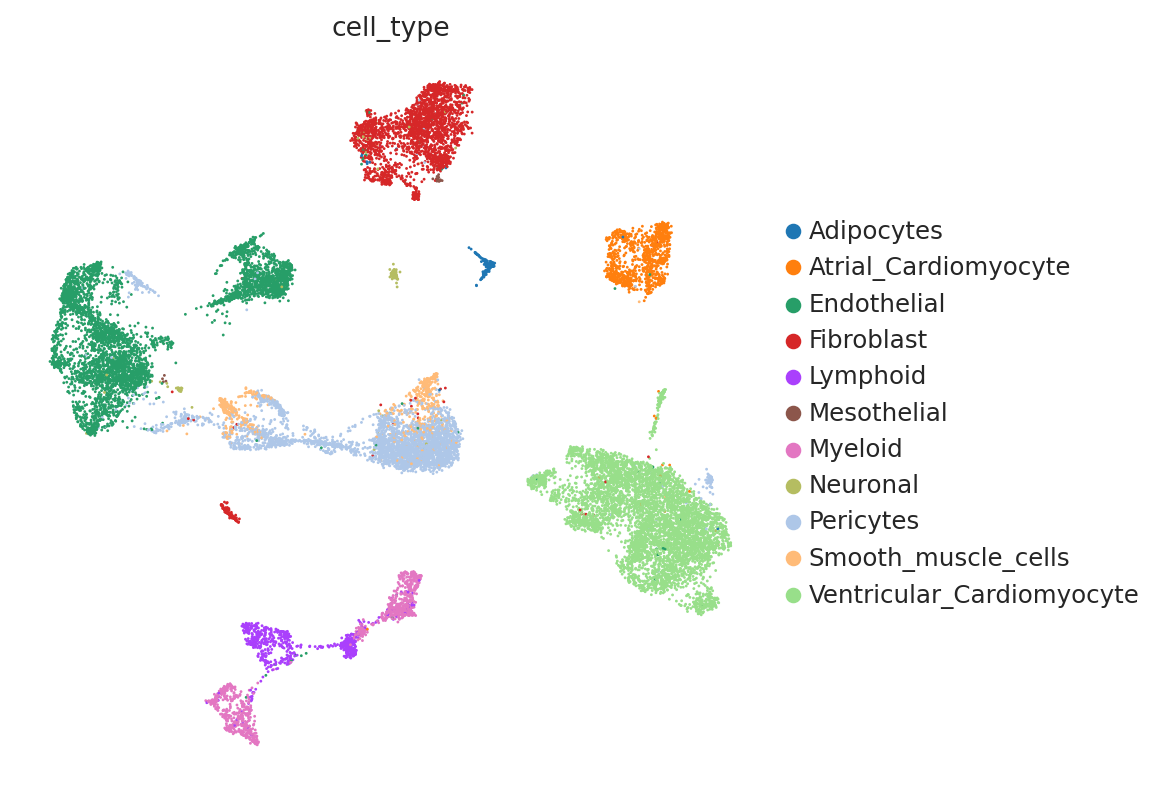

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

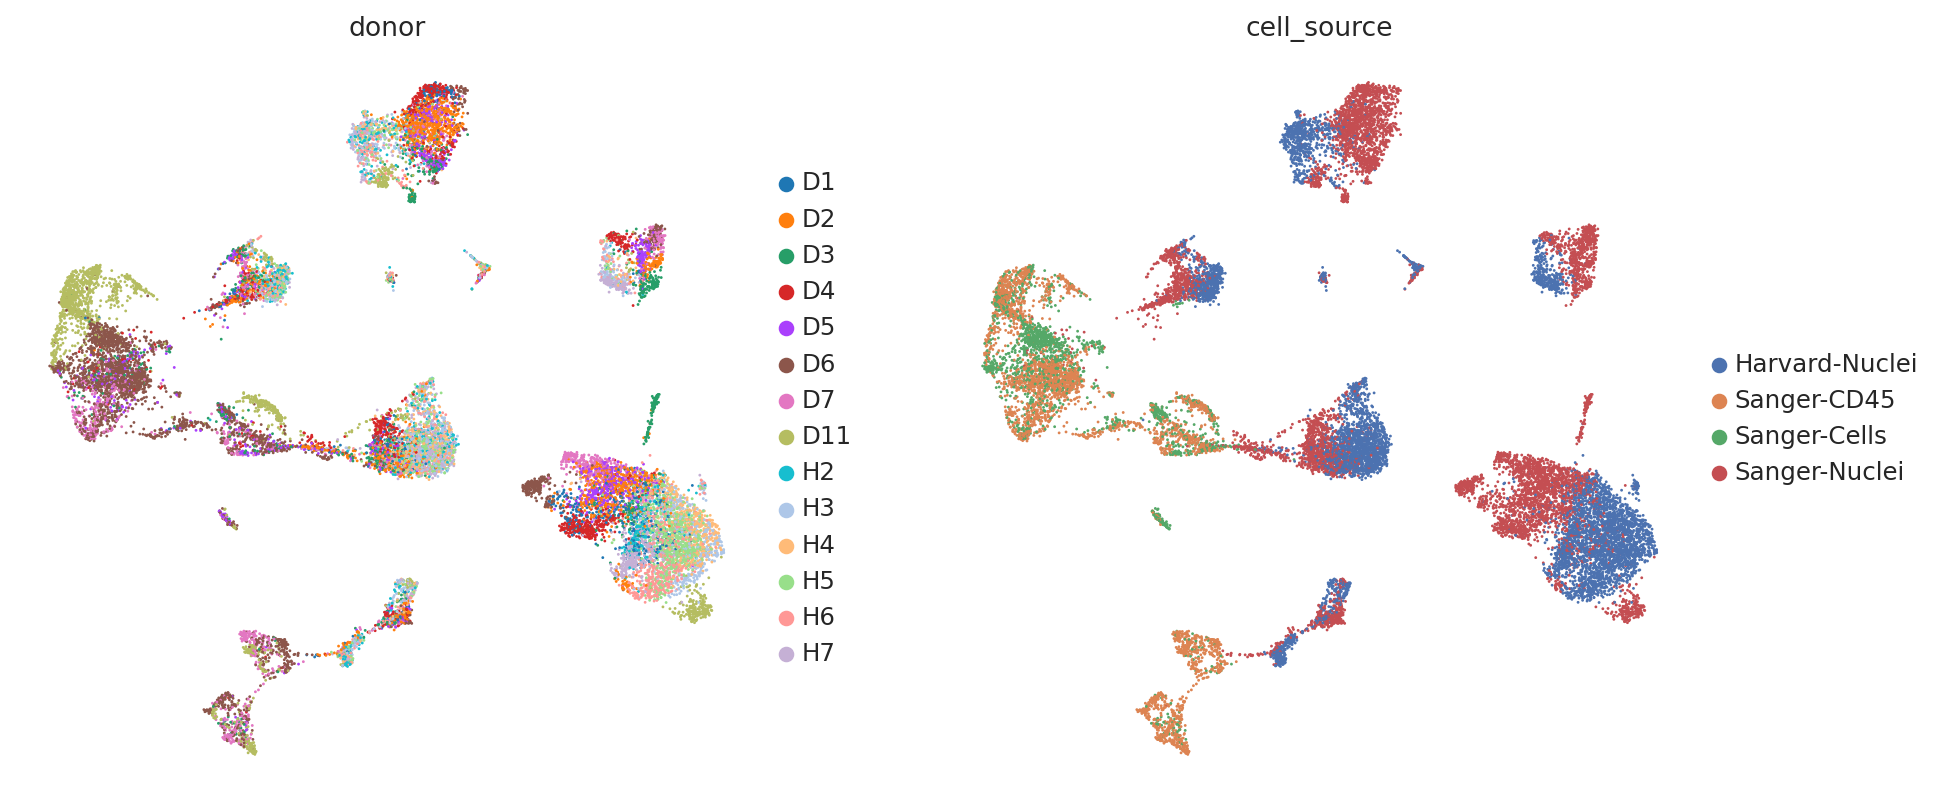

In [20]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

We see that while the cell types are generally well separated, nuisance variation plays a large part in the variation of the data.

### Visualization with batch correction (scVI)

Now, let us try using the scVI latent space to generate the same UMAP plots to see if scVI successfully accounts for batch effects in the data.

In [21]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


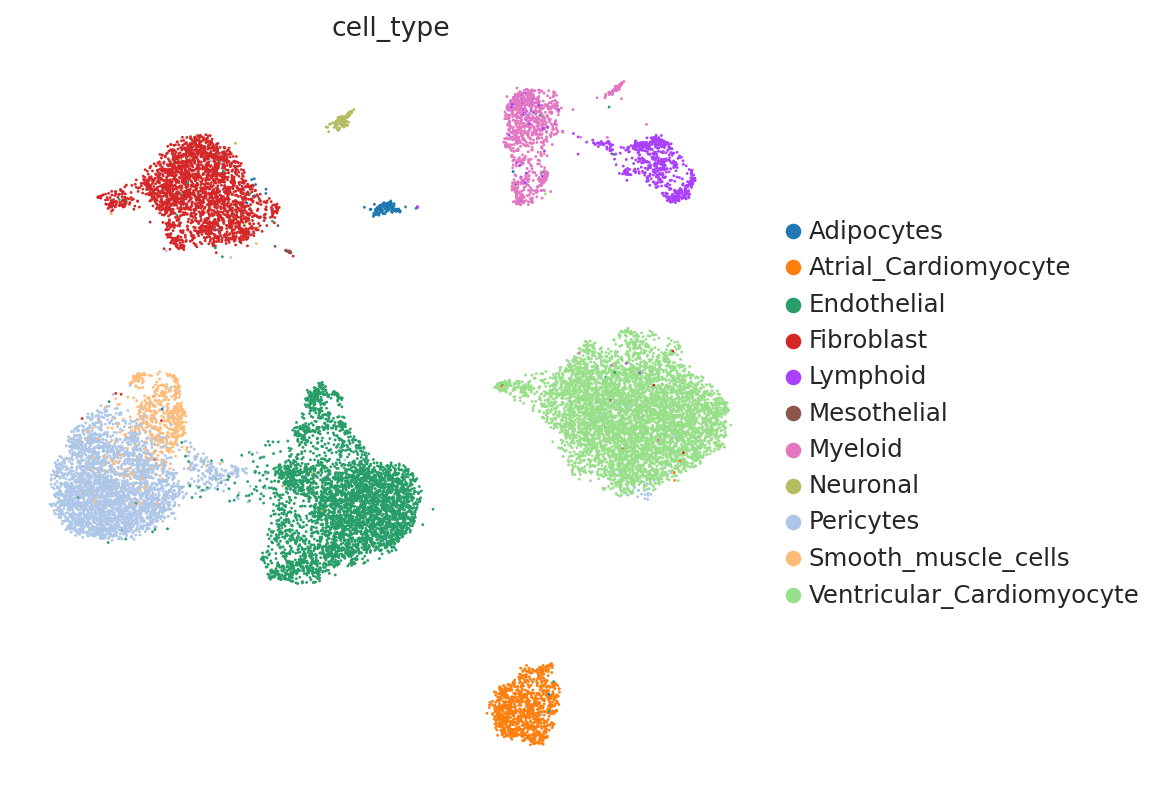

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

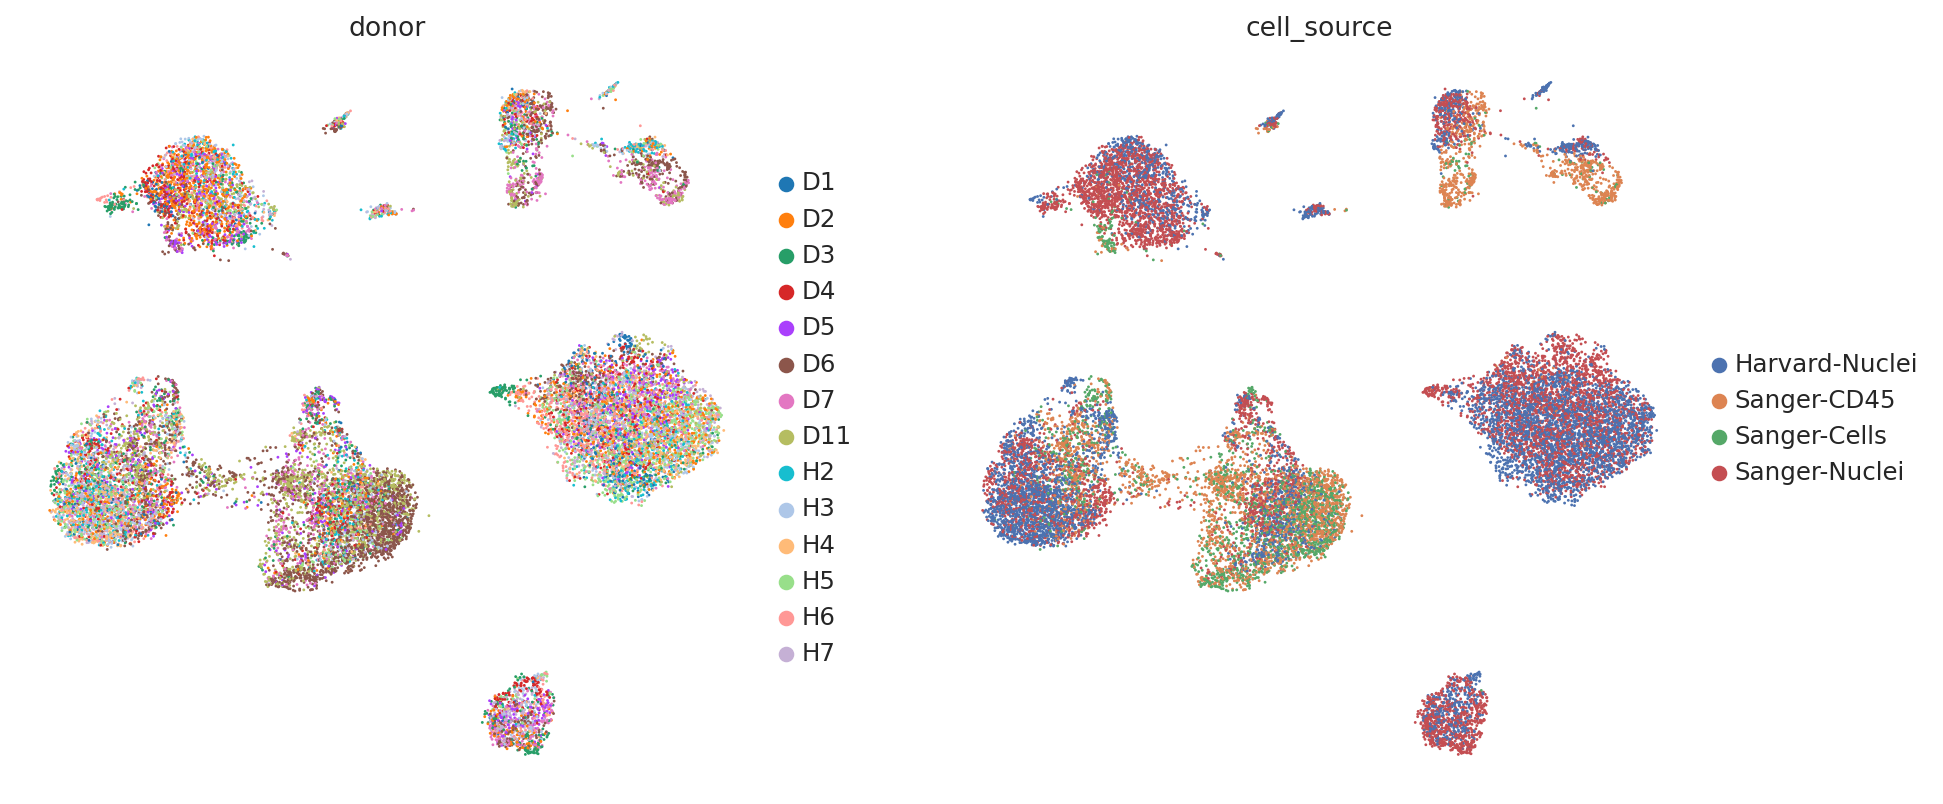

In [22]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

We can see that scVI was able to correct for nuisance variation due to nuclei/whole cell, age group, and donor, while maintaining separation of cell types.

### Clustering on the scVI latent space

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression).

In [23]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


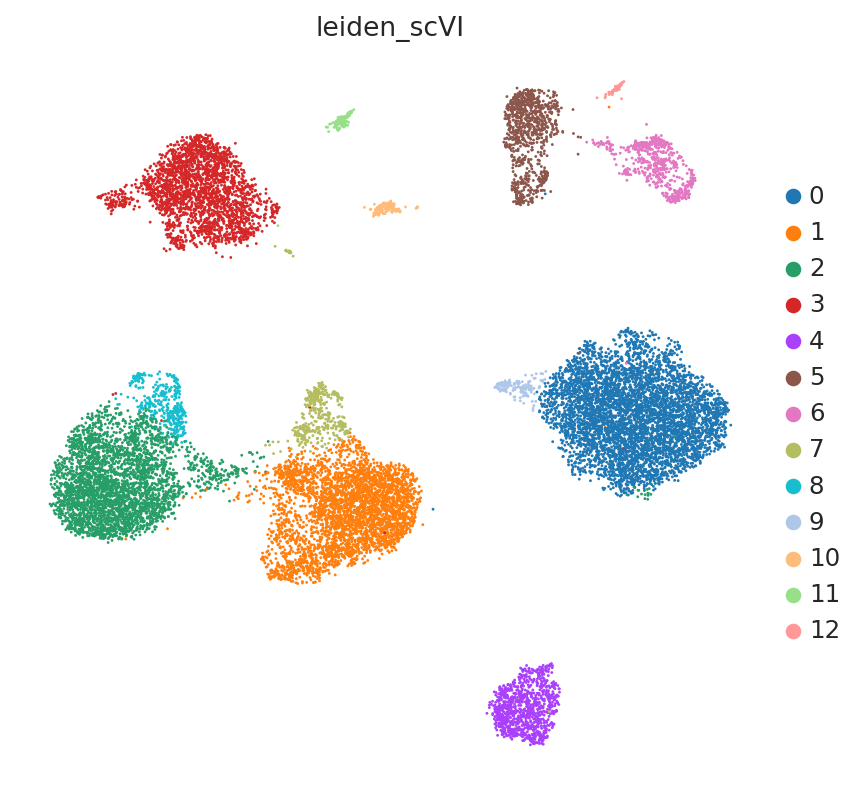

In [24]:
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

## Differential expression

We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see the [API docs](https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.differential_expression.html#scvi.model.SCVI.differential_expression).

In [25]:
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ..., 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']

For example, a 1-vs-1 DE test is as simple as:

In [26]:
de_df = model.differential_expression(
    groupby="cell_type", group1="Endothelial", group2="Fibroblast"
)
de_df.head()


DE...:   0%|          | 0/1 [00:00<?, ?it/s]


DE...: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


DE...: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
COL6A3,0.9990,0.0010,6.906745,0.000163,0.004593,0.0,0.25,-5.430220,-5.484797,1.701298,...,0.026284,1.228131,0.021903,0.498365,1.195808,54.193195,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
CDH19,0.9988,0.0012,6.724225,0.000219,0.011687,0.0,0.25,-7.452348,-7.609721,2.549751,...,0.049890,3.217938,0.014359,0.672527,1.843119,137.330276,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
SCARA5,0.9984,0.0016,6.436144,0.000024,0.001332,0.0,0.25,-7.112072,-7.250882,2.703943,...,0.003407,0.332787,0.003164,0.206868,0.162181,14.315285,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
EGFL7,0.9982,0.0018,6.318161,0.007025,0.000413,0.0,0.25,4.408015,4.382269,1.527345,...,2.376779,0.036795,0.741543,0.025756,89.507553,1.169474,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
DPT,0.9980,0.0020,6.212601,0.000048,0.001607,0.0,0.25,-5.796852,-5.835129,2.243012,...,0.005841,0.453392,0.004381,0.223222,0.300343,18.271797,True,Endothelial vs Fibroblast,Endothelial,Fibroblast


We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [27]:
de_df = model.differential_expression(
    groupby="cell_type",
)
de_df.head()


DE...:   0%|          | 0/11 [00:00<?, ?it/s]


DE...:   9%|▉         | 1/11 [00:00<00:04,  2.04it/s]


DE...:  18%|█▊        | 2/11 [00:00<00:04,  2.06it/s]


DE...:  27%|██▋       | 3/11 [00:01<00:03,  2.06it/s]


DE...:  36%|███▋      | 4/11 [00:01<00:03,  2.06it/s]


DE...:  45%|████▌     | 5/11 [00:02<00:02,  2.06it/s]


DE...:  55%|█████▍    | 6/11 [00:02<00:02,  2.08it/s]


DE...:  64%|██████▎   | 7/11 [00:03<00:01,  2.10it/s]


DE...:  73%|███████▎  | 8/11 [00:03<00:01,  2.11it/s]


DE...:  82%|████████▏ | 9/11 [00:04<00:00,  2.09it/s]


DE...:  91%|█████████ | 10/11 [00:04<00:00,  2.11it/s]


DE...: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


DE...: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
GPAM,0.9992,0.0008,7.130086,0.021934,0.000187,0.0,0.25,7.298192,7.284117,2.337233,...,17.372416,0.035791,0.896552,0.031520,280.340485,1.565905,True,Adipocytes vs Rest,Adipocytes,Rest
FASN,0.9990,0.0010,6.906745,0.012694,0.000150,0.0,0.25,6.727019,6.796301,2.164180,...,7.062068,0.025086,0.841379,0.022167,129.074371,1.084626,True,Adipocytes vs Rest,Adipocytes,Rest
SLC19A3,0.9986,0.0014,6.569875,0.005144,0.000039,0.0,0.25,8.291973,8.206144,2.887105,...,2.910343,0.004650,0.572414,0.004325,51.325165,0.268085,True,Adipocytes vs Rest,Adipocytes,Rest
PLIN1,0.9982,0.0018,6.318161,0.005420,0.000050,0.0,0.25,7.838456,7.689051,2.797599,...,2.799999,0.004379,0.806897,0.004325,52.921761,0.196486,True,Adipocytes vs Rest,Adipocytes,Rest
LGALS12,0.9982,0.0018,6.318161,0.001333,0.000014,0.0,0.25,7.766857,7.723073,2.992604,...,0.689655,0.000973,0.351724,0.000973,10.667459,0.059477,True,Adipocytes vs Rest,Adipocytes,Rest


We now extract top markers for each cluster using the DE results.

In [28]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for c in cats:
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [29]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

/env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


/env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


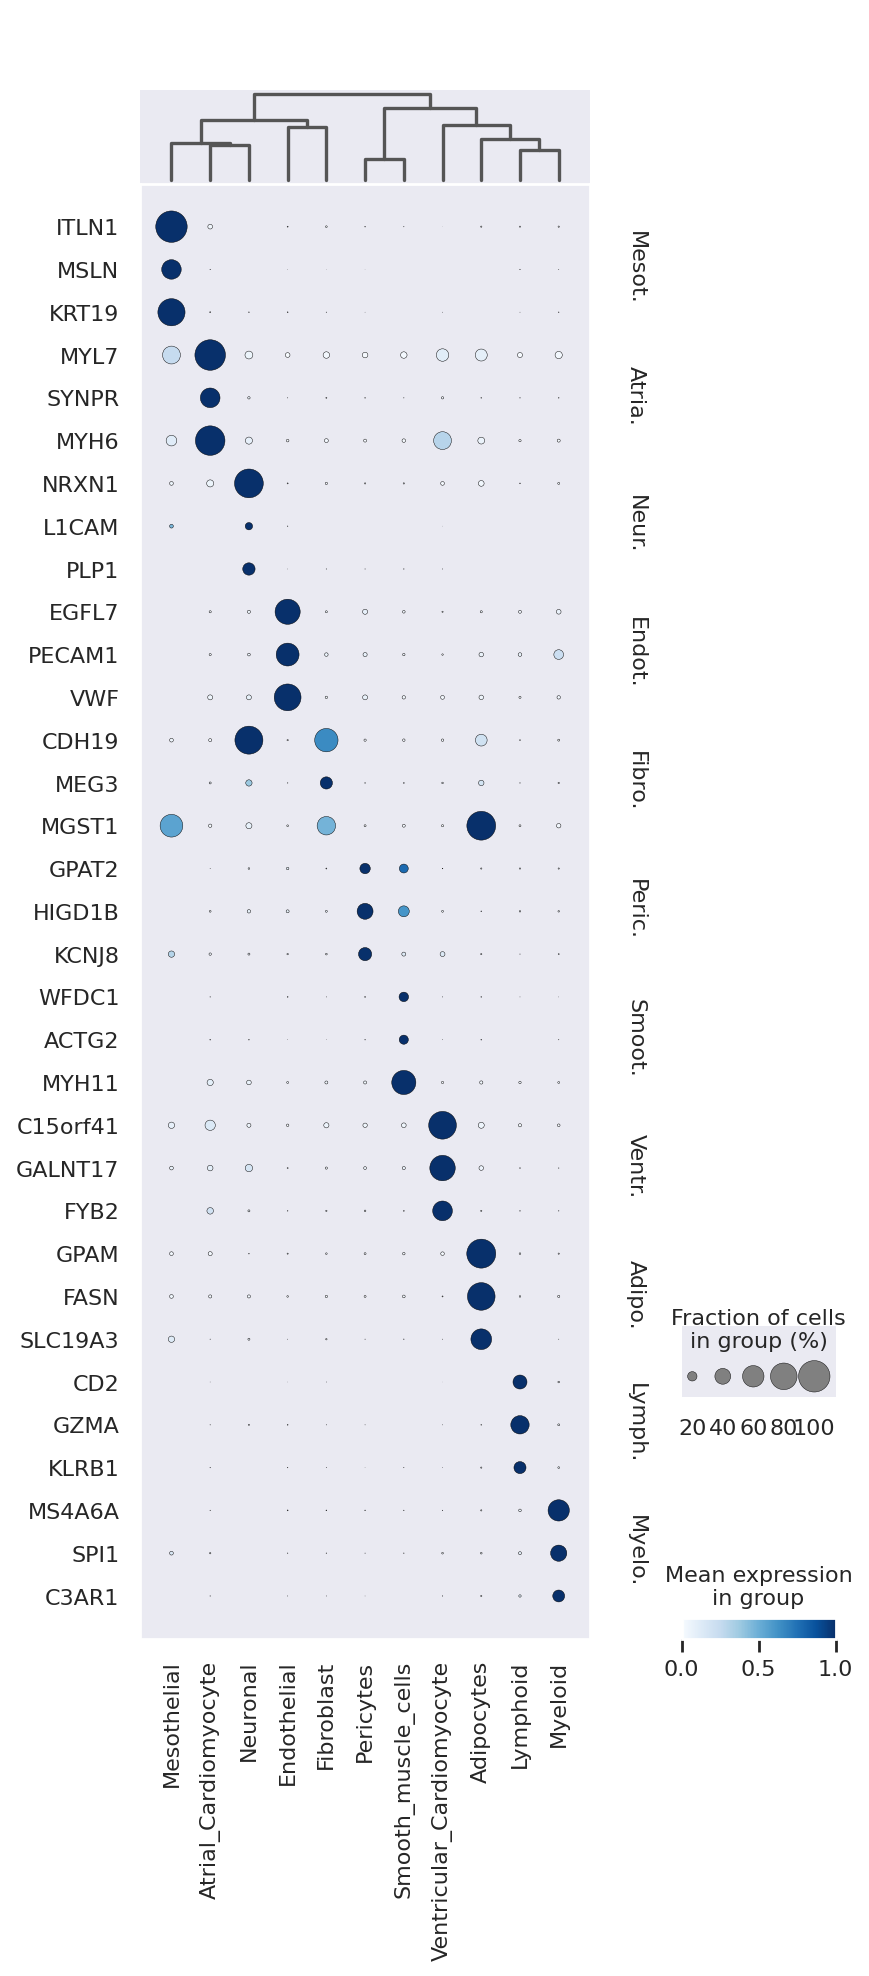

In [30]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="cell_type",
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

We can also visualize the scVI normalized gene expression values with the `layer` option.

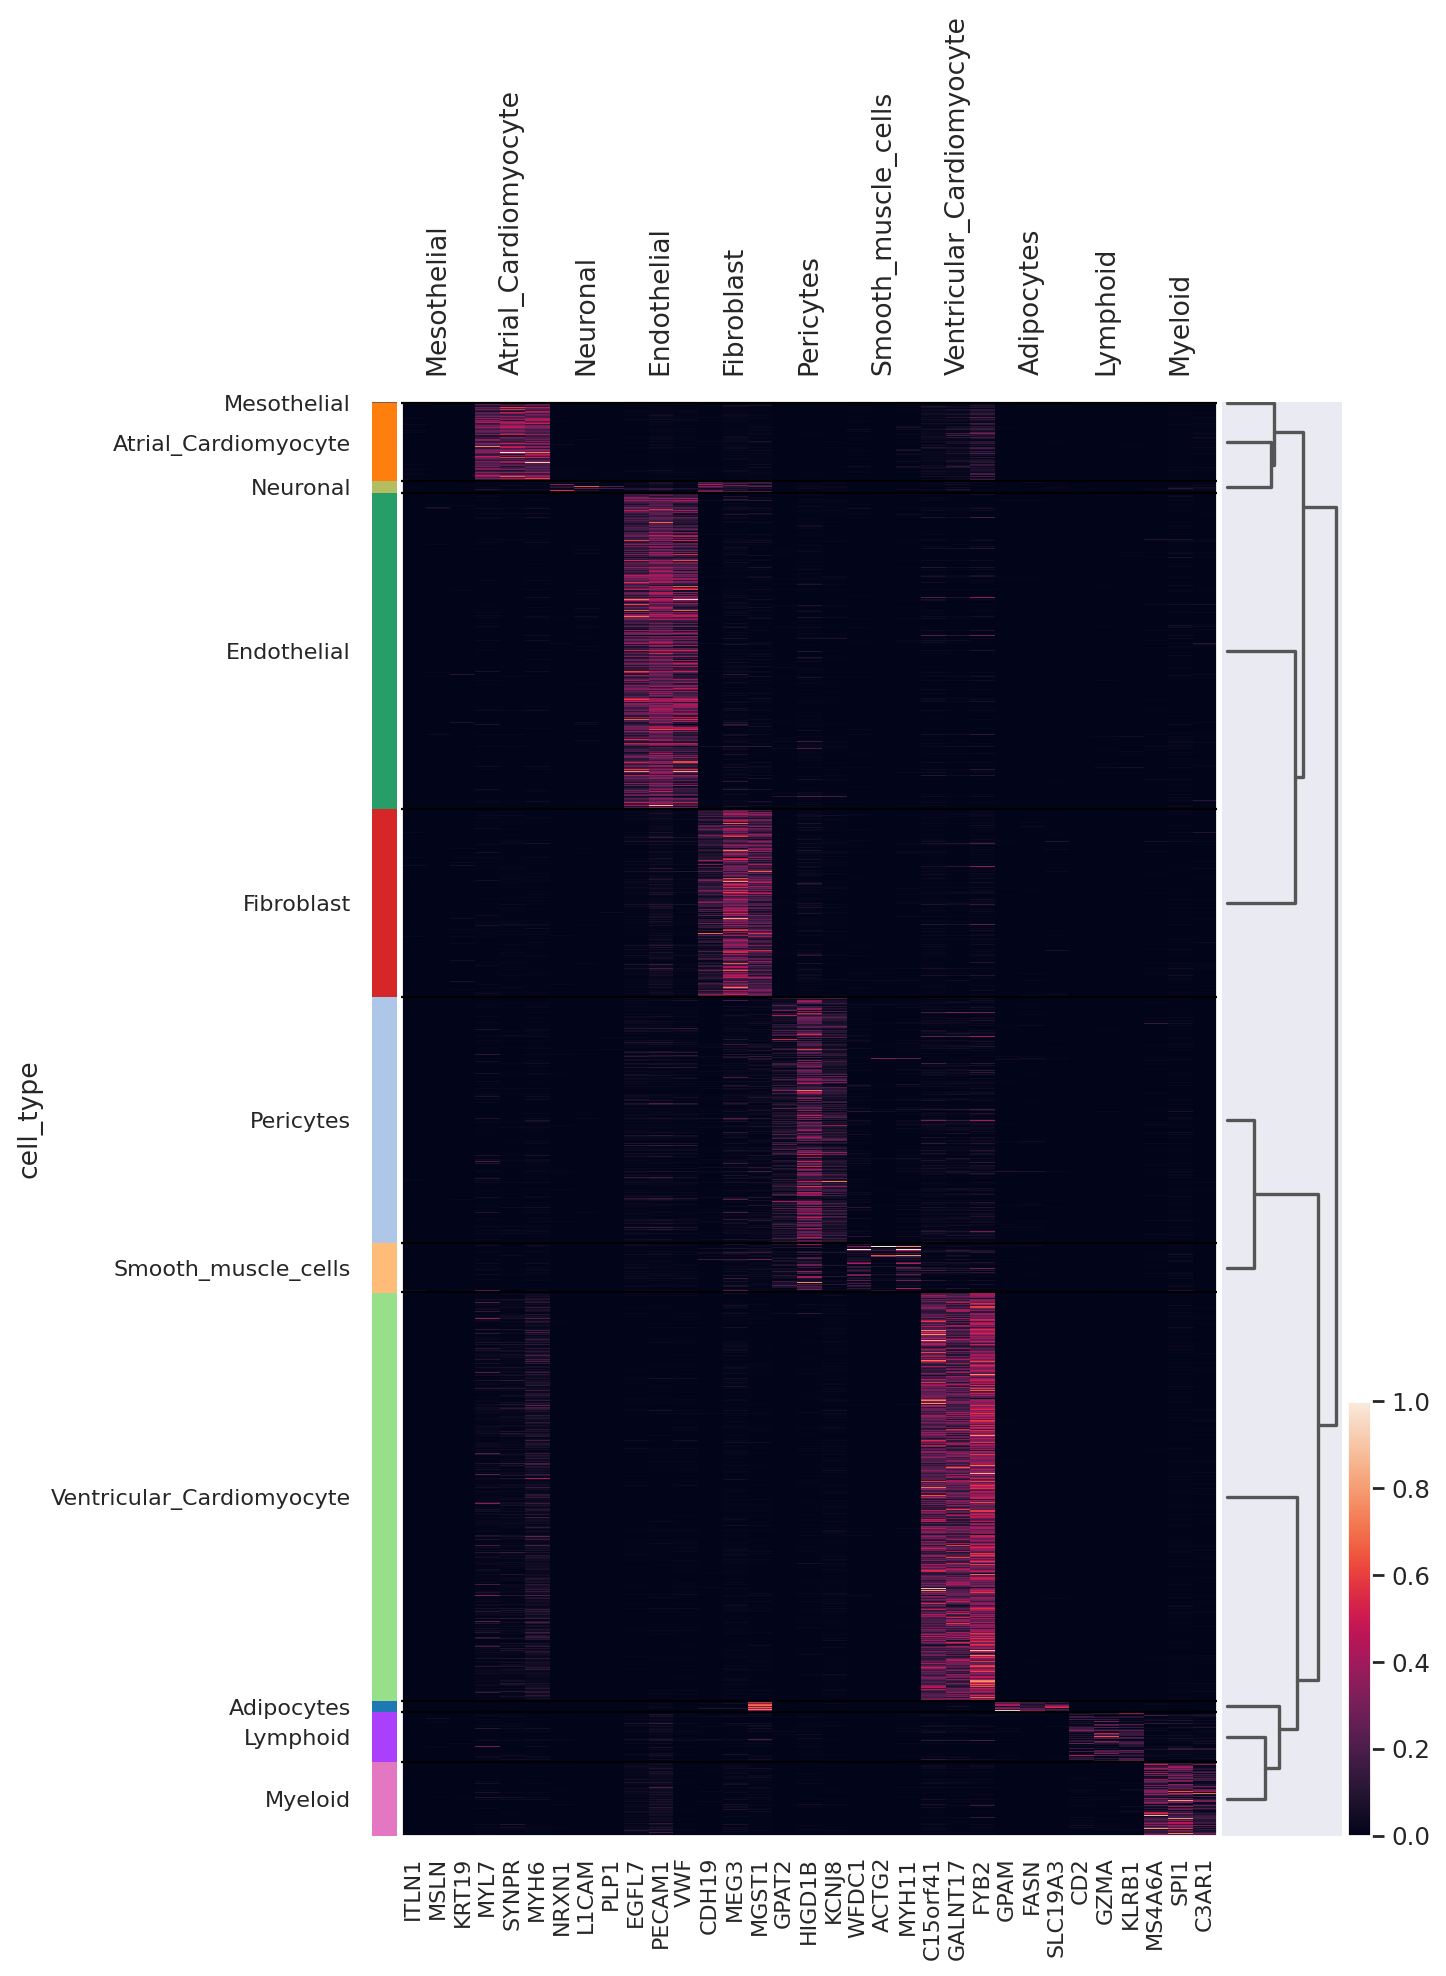

In [31]:
sc.pl.heatmap(
    adata,
    markers,
    groupby="cell_type",
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12),
)

## Logging information

Verbosity varies in the following way:

- `logger.setLevel(logging.WARNING)` will show a progress bar.
- `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
- `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.settings.verbosity` to set the verbosity of the scvi package.
Note that `verbosity` corresponds to the logging levels of the standard python `logging` module. By default, that verbosity level is set to `INFO` (=20).
As a reminder the logging levels are:

<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>